In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(dplyr) 
    library(ggpmisc)
    library(quantmod)
    library(showtext) 
    library(readxl)
})

Warning message:
“package ‘quantmod’ was built under R version 3.6.3”Warning message:
“package ‘xts’ was built under R version 3.6.3”Warning message:
“package ‘zoo’ was built under R version 3.6.3”Warning message:
“package ‘TTR’ was built under R version 3.6.3”Warning message:
“package ‘showtext’ was built under R version 3.6.3”Warning message:
“package ‘sysfonts’ was built under R version 3.6.3”Warning message:
“package ‘showtextdb’ was built under R version 3.6.3”Warning message:
“package ‘readxl’ was built under R version 3.6.3”

In [2]:
options(repr.plot.width=15, repr.plot.height=10)
showtext_auto(enable = TRUE)
options("getSymbols.warning4.0"=FALSE)

In [3]:
#plot function

In [59]:
plot = function(Name,Code,onlyplot='No',start_date='1900-01-01',end_date=Sys.Date(),Interval=NA){
    tryCatch(
        expr = {Stock  = suppressWarnings(getSymbols(
                    Code, src = "yahoo",from = start_date, 
                    to = end_date, auto.assign = FALSE))


    v <- data.frame("Date" = index(Stock), "Price" =  Stock[,6])
    names(v) <- c("Date","Price")
    v = na.omit(v)

    # Get the actual start date
    start_date = v[1,1]
    if(is.na(Interval)){
        interval = as.numeric(end_date-start_date)/365/10
        if (interval<1){
            interval = 1
        }
        Interval = paste(round(interval),'years')
    }
    
    ##Get current price and previous trading day price
    current_price = v[nrow(v),2]
    previous_price = v[nrow(v)-1,2]
    day_change = current_price/previous_price-1
    if(day_change>0){
        change_color="red"
    }
    else if(day_change<0){
        change_color = "darkgreen"
    }
    else{
        change_color="grey"
    }
    day_change = paste(round(100*day_change, 2), "%", sep="")
    
    
    #Get the linear regression model
    model = lm(log(Price) ~ Date, data = v)
    #Get the predict price at current date
    predict = predict(model,data.frame(Date=end_date),interval='confidence',level=0.98)
    predict_price = predict[1,1]
    times = exp(predict_price)/current_price

    ###Get the predict date at current price
    cc=coef(model)
    r_squared = summary(model)$r.squared
    predict_date= as.Date((log(current_price)-cc[1])/cc[2])
    

    sp = ggplot(data= v, aes(x =Date , y = log( Price))) + 
    geom_smooth(method = 'lm', formula = y ~ x,fullrange = T) + #绘制回归直线
    geom_line(color = "darkblue") + ggtitle(paste(Code,Name, " From ",start_date)) + 
    stat_poly_eq(aes(label = paste(..eq.label.., ..adj.rr.label.., sep = '~~~~')), formula = y ~ x, parse = T,
            size=8,label.x = 0.5,label.y = 0.99) + #添加回归方程和调整R方
    #stat_fit_tb(tb.type = 'fit.anova',size=5)+

        
    geom_segment(aes(x = as.Date(end_date), y = log(current_price), 
                 xend = as.Date(predict_date), yend = log(current_price)),
                 size=1.5,colour='red')+

    geom_segment(aes(x = as.Date(end_date), y = log(current_price), 
                 xend = as.Date(end_date), yend = predict_price),
                 size=1.5,colour='darkgreen')+

    ###Add the difference between predicted price and current price
    annotate("text", x =end_date+(end_date-start_date)/50, y = (log(current_price)+predict_price)/2, 
         label = round(times,2),size=6)+

    ###Add the cuttren price and day change
    annotate("text", x =start_date+(end_date-start_date)/2, y = Inf,vjust=4,
         label = paste("current price: ",round(current_price,2),",",day_change),size=8,colour=change_color)+

    ###Add the predicted date
    annotate("text", x =predict_date, y = log(current_price),  
         label = predict_date,size=5)+

    theme_bw()+
    xlab("Date") + ylab("Log(Price)") + 
    theme(plot.title = element_text(hjust = 0.5,size=30)) + 
    scale_x_date(date_labels = "%Y", date_breaks = Interval)+
    theme(axis.text = element_text(size=20),axis.title = element_text(size=30),legend.text=element_text(size=30))
    
    #print(sp)
    interval = as.numeric(end_date-start_date)/365
    if(onlyplot=="No"){
        return(list(sp,times,toString(cc[2]),r_squared,interval))
    }
    else{
        return(sp)
    }
   },
    error = function(e){
        message(paste("error occur, could not find stock",Code,Name))
        message(start_date)
        message(end_date)
        #return(list(0,-10000,-10000))
    },
    warning = function(w){
        message('Caught an warning!')
        #return(list(0,-10000,-10000))
    })
}

In [5]:
# get stock list 

In [6]:
get_stock_list = function(file,file_type){
    plots_list <- list()
    times_list = list()
    slope_list = list()
    rsqua_list = list()
    inter_list = list()
    index = 0
    count = 0
    
    if(file_type == "xls"){
        data <- read_excel(file)
    }
    else if (file_type == "csv"){
        data = read.csv(file,header=TRUE)
    }
    else if (file_type == "cb"){
        data = read.csv(file,header=TRUE)
    }
    else{
        stop("Invalid file type")
    }
    
    
    for(i in 1:nrow(data)) {
        if(file_type == "xls"){
            id = toString(data[i,5])
            name = toString(data[i,6])
            exchange = toString(data[i,8])
    
            if(exchange == "SHH"){
                id = paste(id,'.ss',sep='') 
            }
            else if (exchange == "SHZ"){
                id = paste(id,'.sz',sep='')
            }
            else{
                warning("Warnings: exchange is neighter SHH nor SHZ")
            }
        }
        else if (file_type == "csv"){
            name = toString(data[i,1])
            id = toString(data[i,2])
            sector = toString(data[i,3])
        }
        else if (file_type == "cb"){
            name = toString(data[i,4])
            id = toString(data[i,3])
        }
        else{
            stop("Invalid file type")
        }
        lists = plot(name,id)
        if(!is.null(lists)){
            index = index+1
            plots_list[index] = lists[1]
            times_list[index] = lists[2]
            slope_list[index] = lists[3]
            rsqua_list[index] = lists[4]
            inter_list[index] = lists[5]
            
           
        }
        count = count+1
        if(count%%10==0){
            message(paste("Processing",count,"items"))
        }
    }
    message(paste("Finished processing",count,"items",index,"succeed"))
    #order_list = order(unlist(times_list),decreasing = TRUE)
    #return(list(plots_list[order_list],times_list[order_list],slope_list[order_list]))
    return(list("plot"=plots_list,"times"=times_list,
                "slope"=slope_list,"rsqua"=rsqua_list,"interval"=inter_list))
}
    

In [7]:
# show

In [8]:
show = function(mylists,start_index,number,rsquare_threshold=0){

    interval_threshold = 5
    plot_list = mylists$plot
    times_list = as.numeric(unlist(mylists$times))
    slope_list = as.numeric(unlist(mylists$slope))
    rsqua_list = as.numeric(unlist(mylists$rsqua))
    inter_list = as.numeric(unlist(mylists$interval))

    timeslope = times_list*slope_list*1000
    order_list = order(timeslope,decreasing=TRUE)
    if(start_index<1 && start_index+number > length(times_list)){
        stop("input number out of range")
    }
    i = start_index
    count = 0
    while(count<=number){
        index = order_list[i]
        rsquare = rsqua_list[index]
        interval = inter_list[index]
        if(rsquare_threshold > rsquare){
            message(paste("r square lower than",rsquare_threshold))
        }
        else if(interval_threshold<interval){
            print(interval)
        #else{
            count = count+1
            print(plot_list[index])
        }
        i = i+1
    }
}

In [22]:
indexlists = get_stock_list("Indexlist.csv","csv")

error occur, could not find stock ^XNDX NASDAQ100TR
Finished processing 9 items 8 succeed


[1] 40.72329
[[1]]

[1] 34.72603
[[1]]


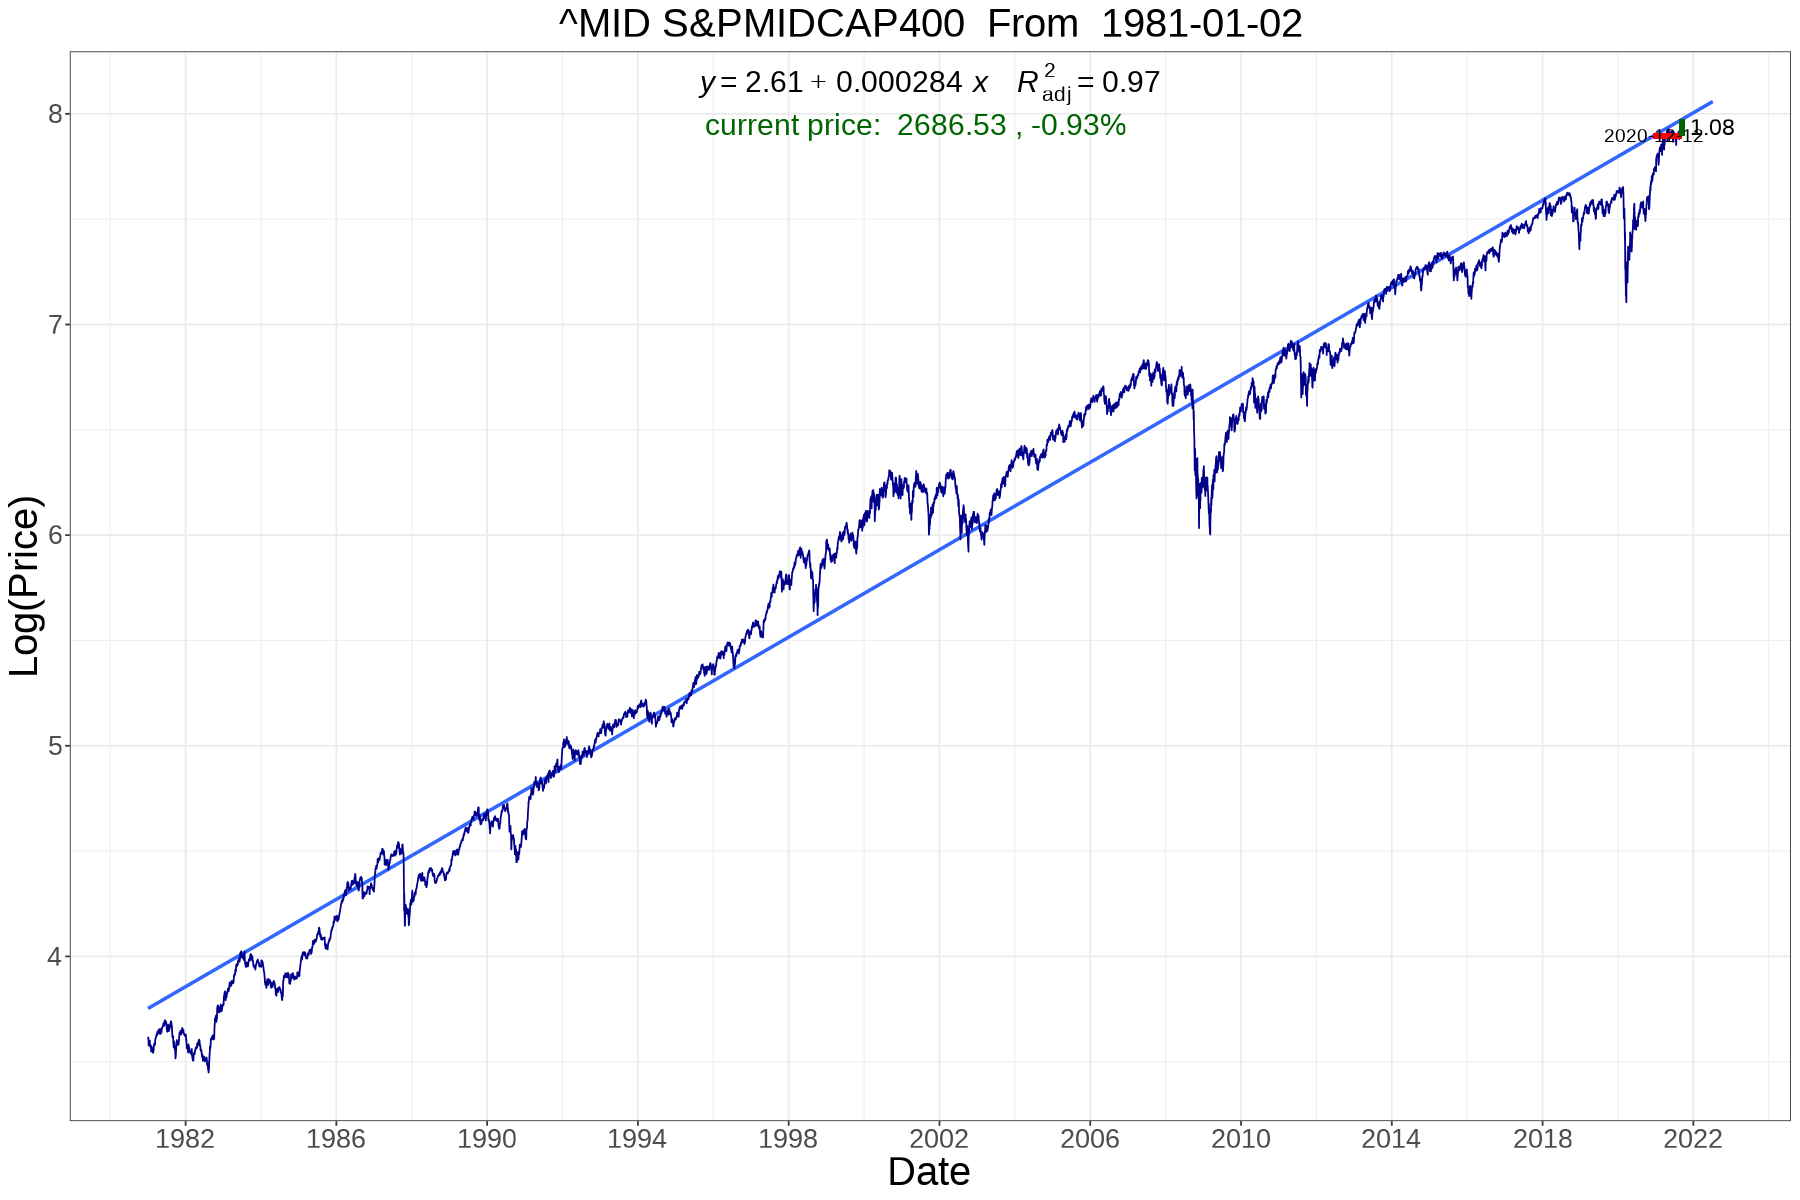


[1] 22.8137
[[1]]


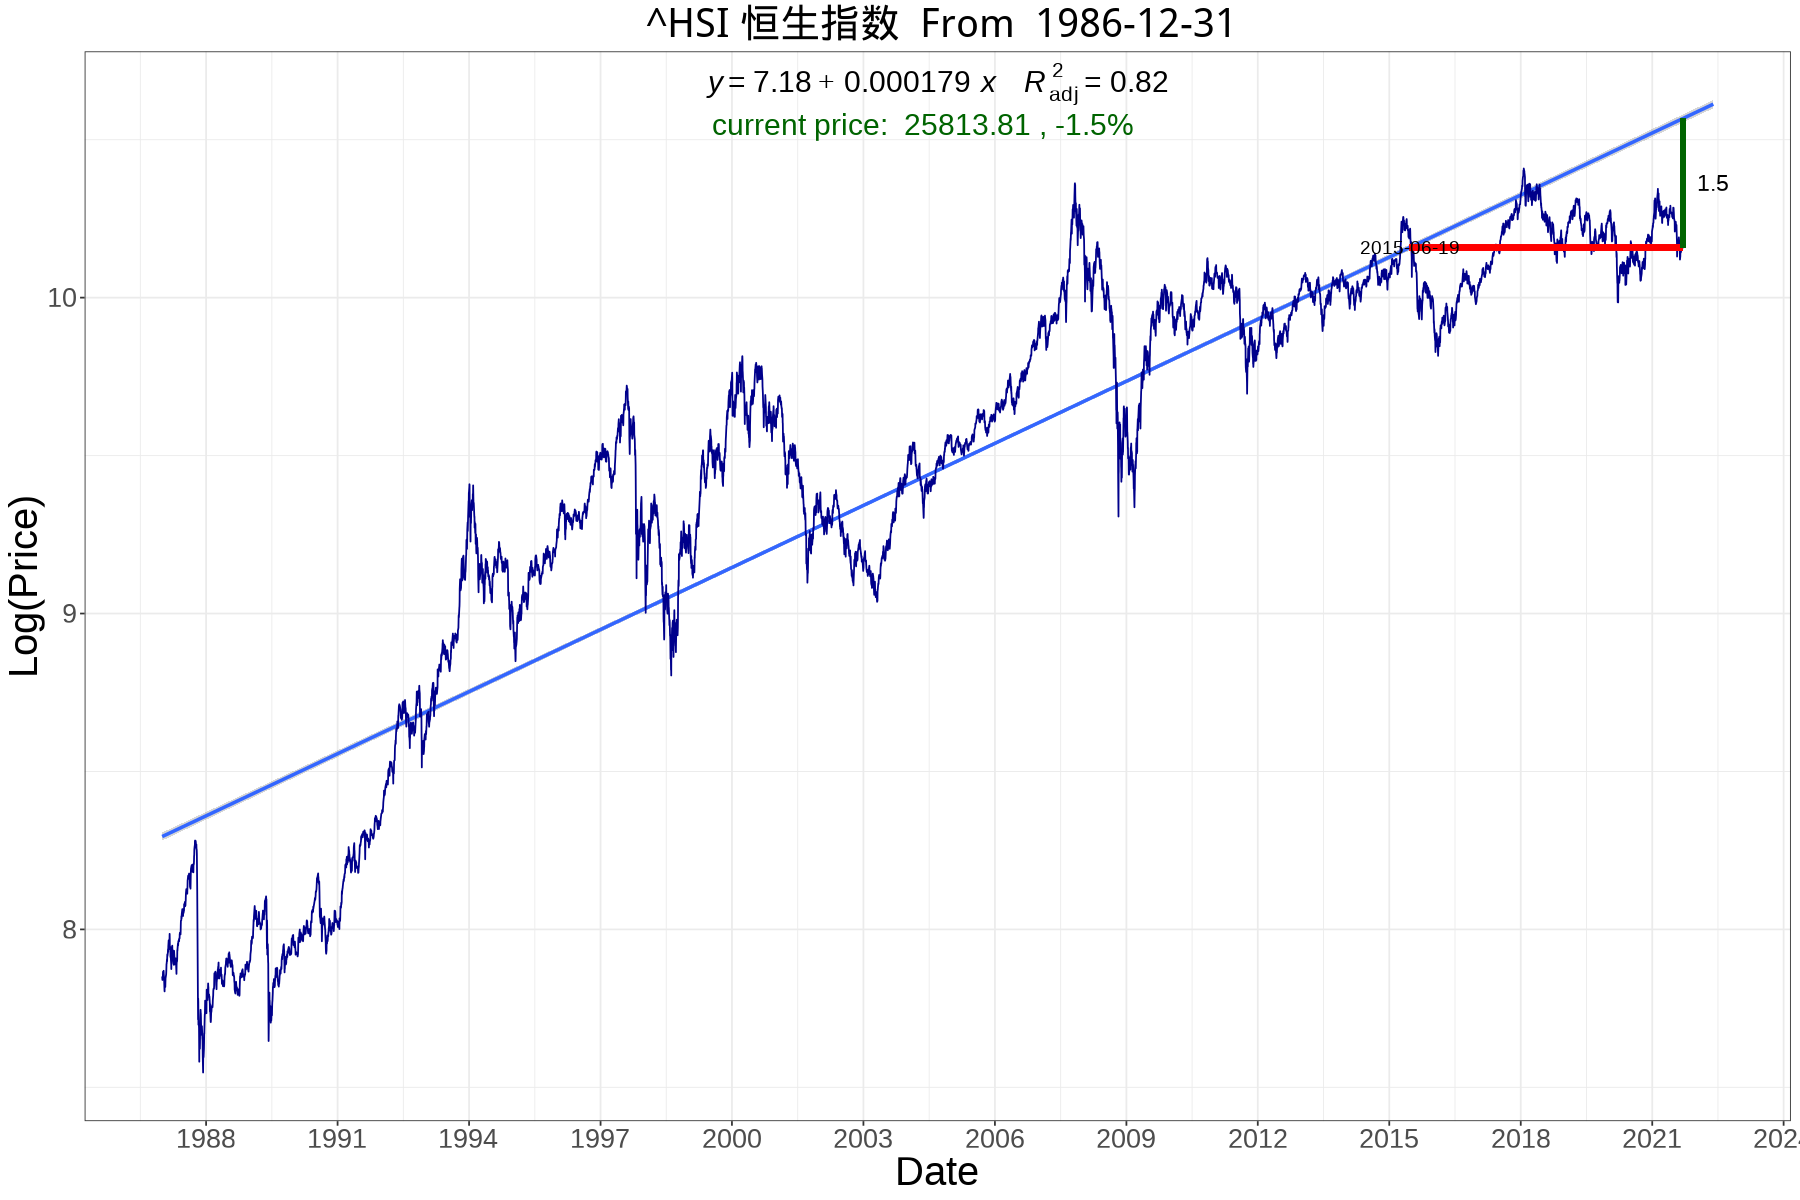


[1] 35.97534
[[1]]


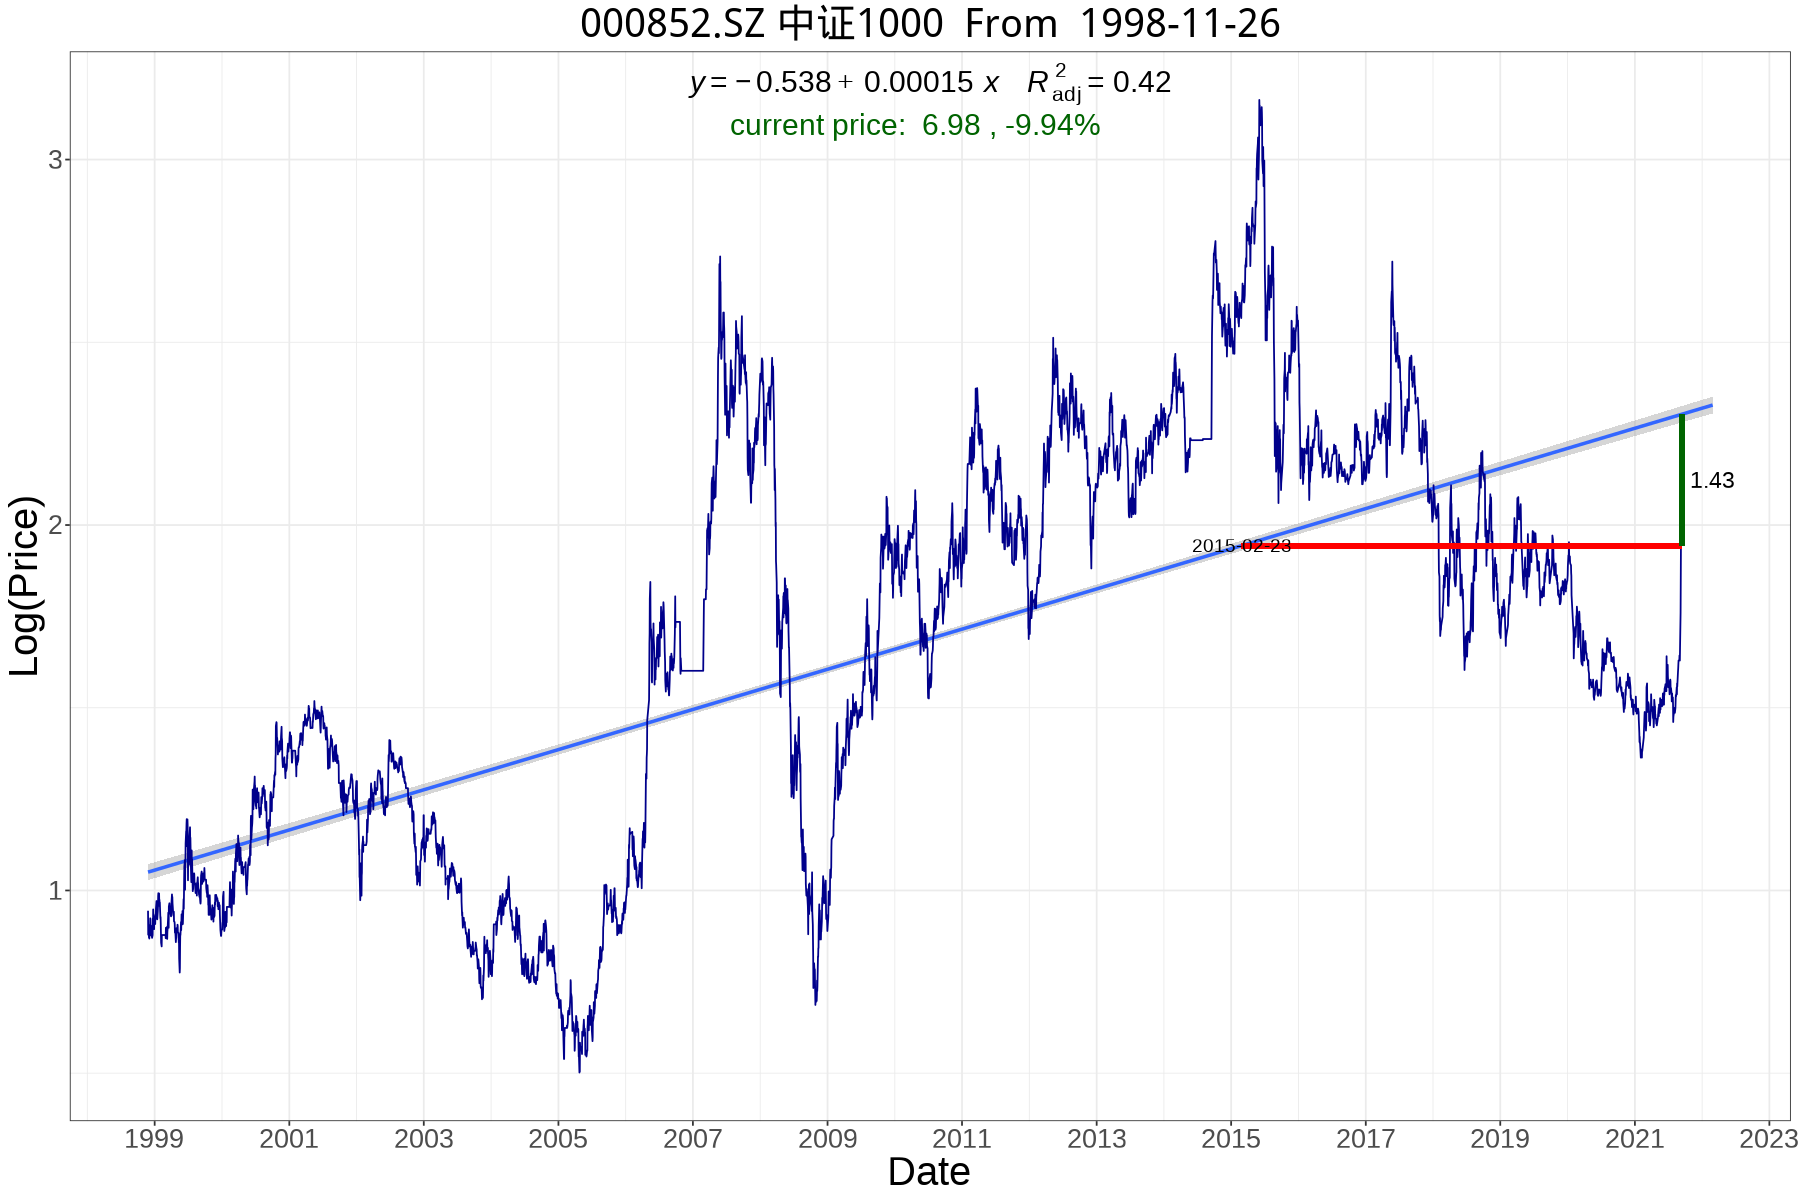


[1] 22.39178
[[1]]


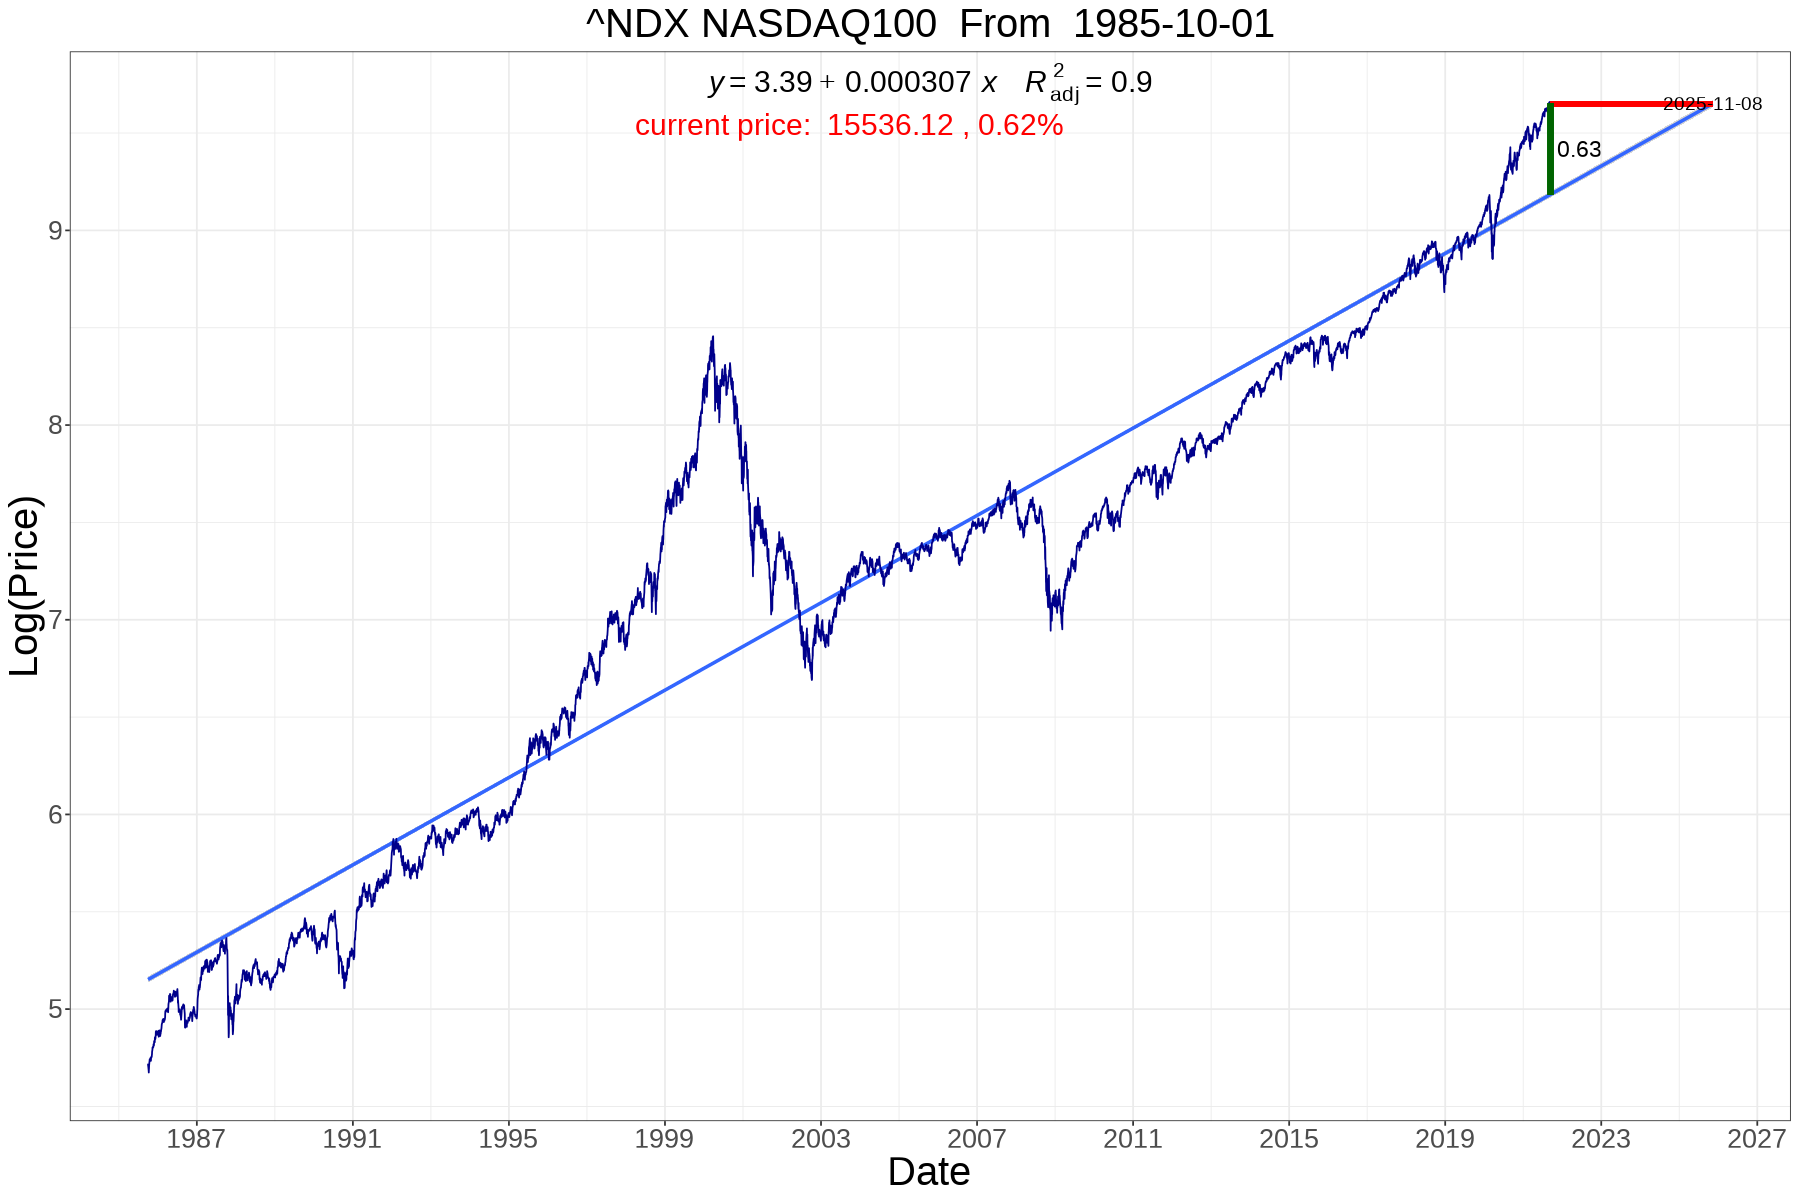


[1] 33.71507
[[1]]


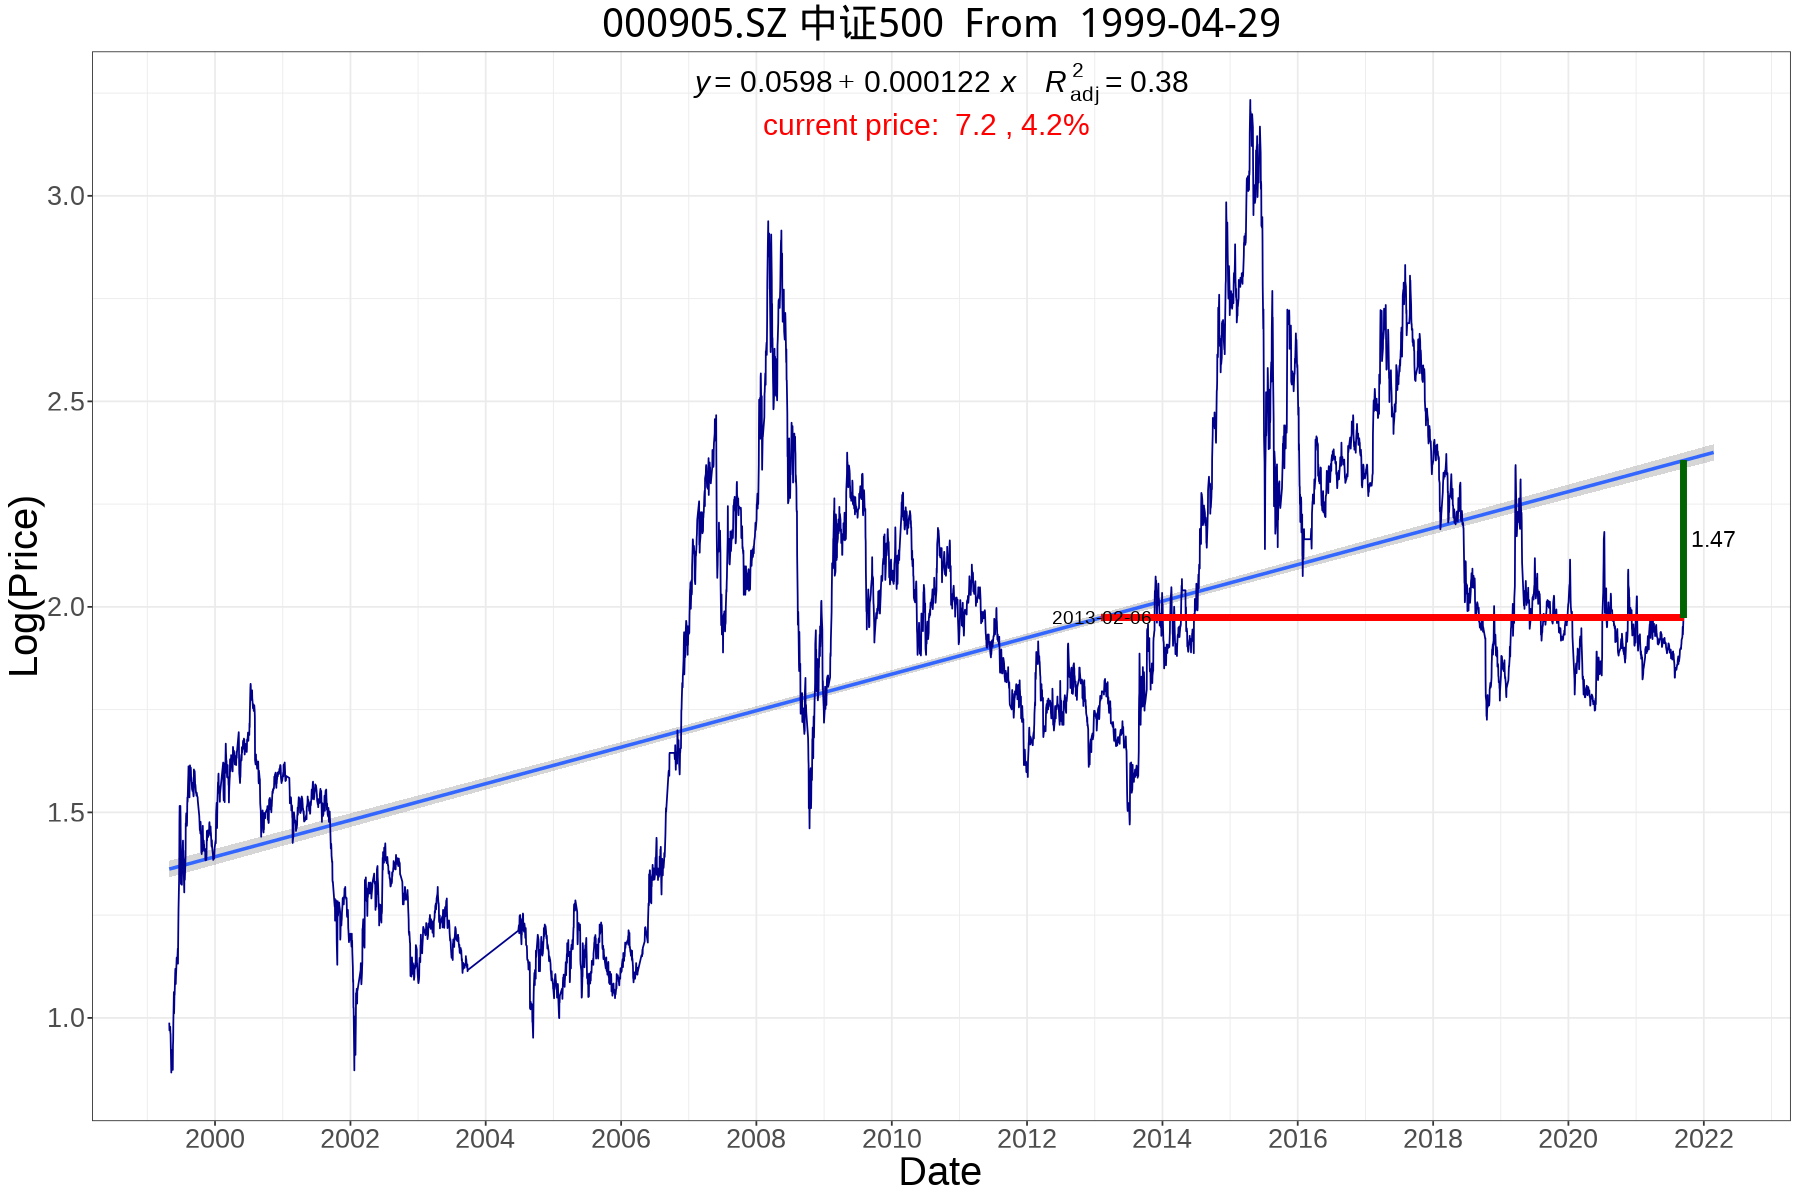


[1] 93.76986
[[1]]


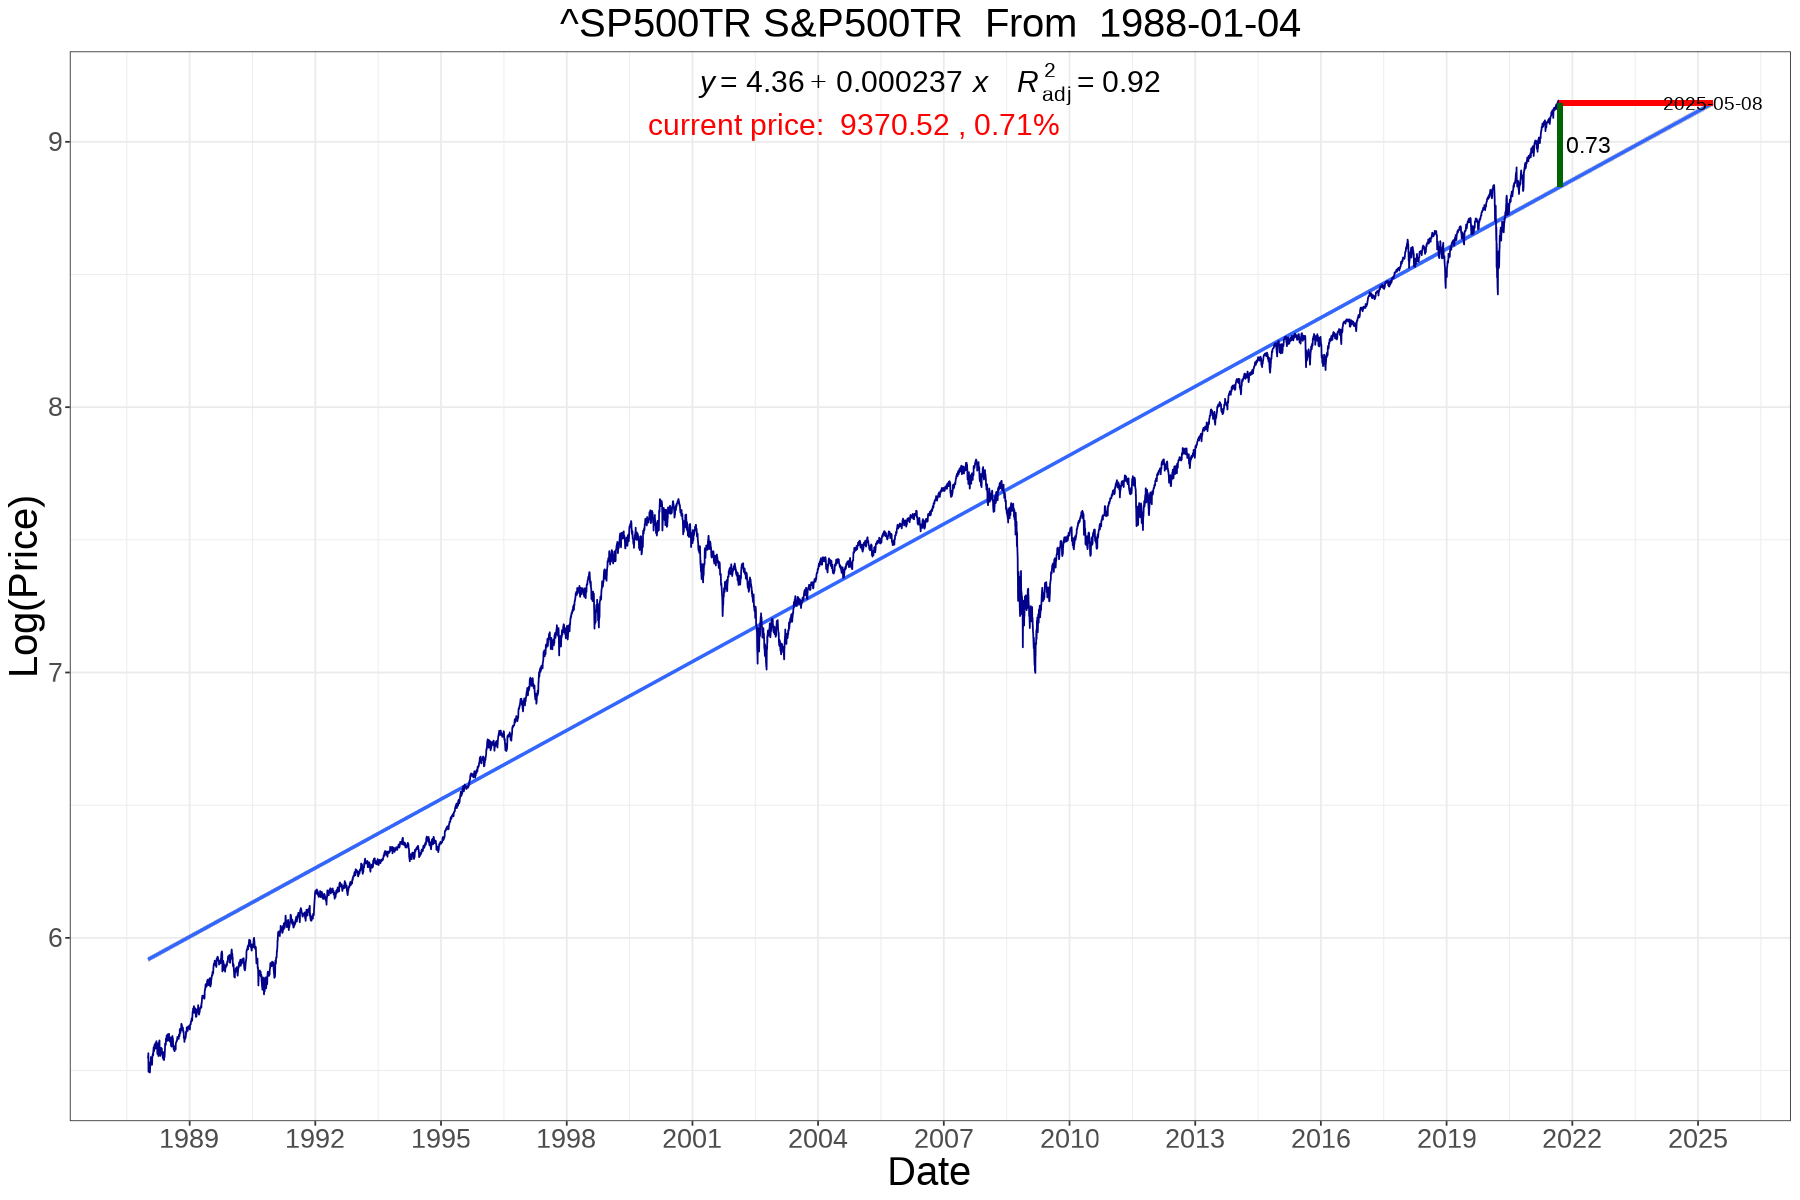


[1] 56.72603
[[1]]



ERROR: Error in if (rsquare_threshold > rsquare) {: missing value where TRUE/FALSE needed


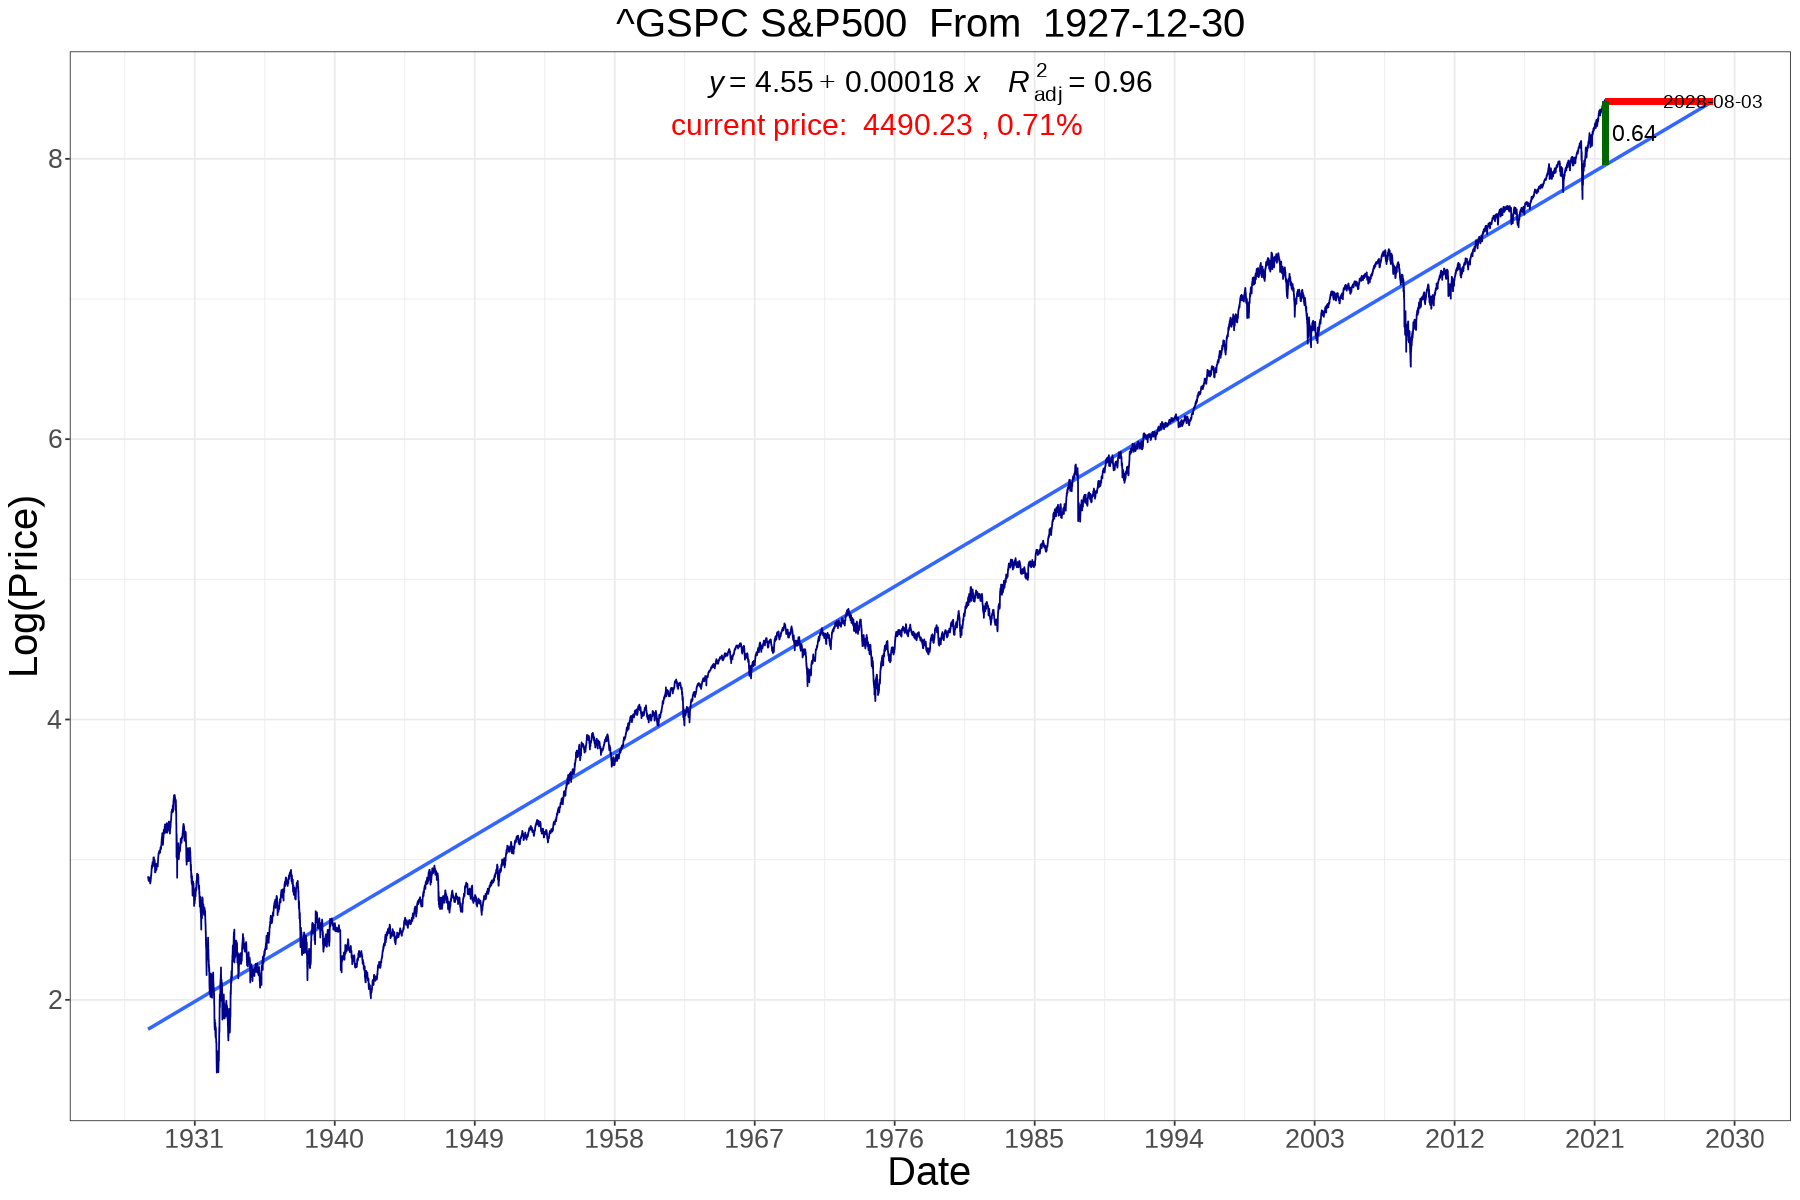

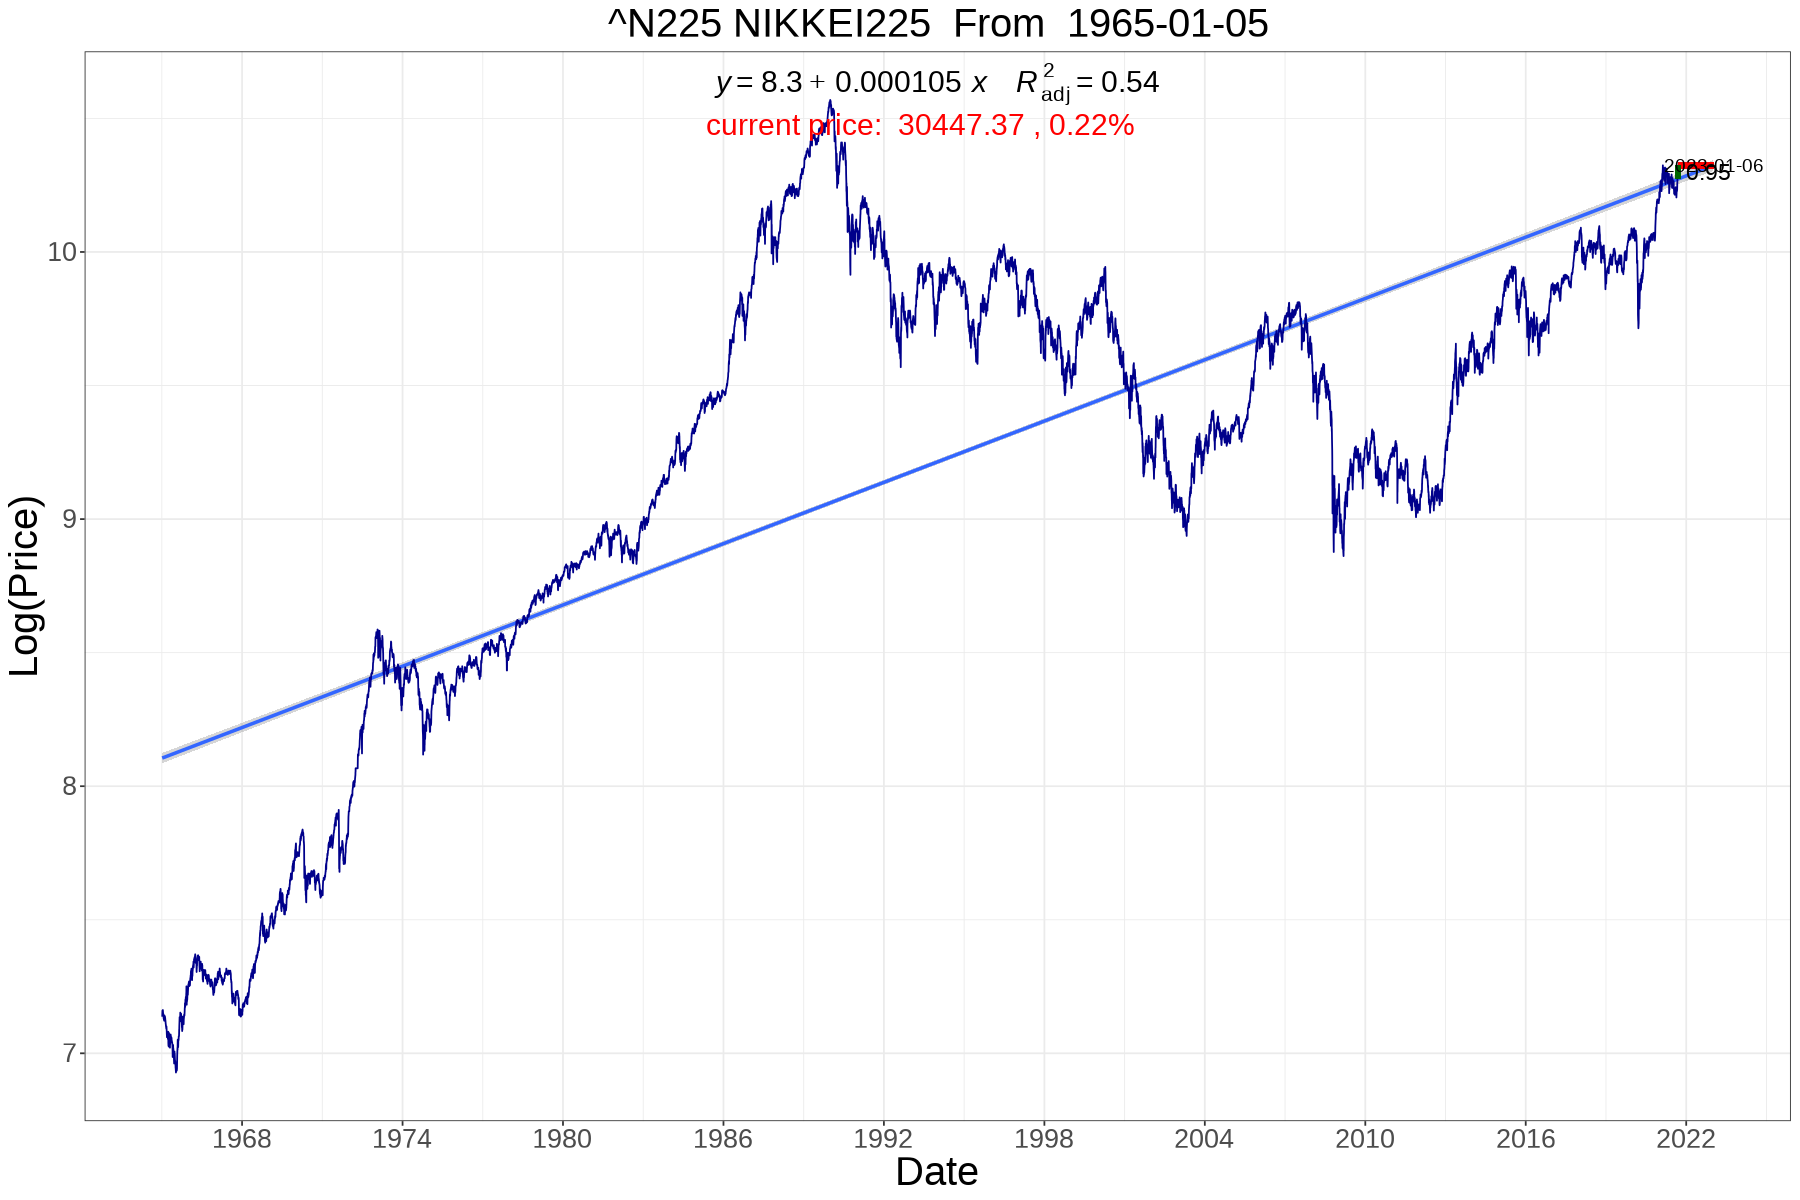

In [23]:
#恒生指数低估倍数到2才入手，不到就不入。
show(indexlists,1,10,0)

In [ ]:
#csi500_url  = 'http://www.csindex.com.cn/uploads/file/autofile/cons/000905cons.xls'
#download.file(csi500_url, "csi500.xls")

In [11]:
lists = get_stock_list("csi500.xls",'xls')

Processing 10 items
Processing 20 items
Processing 30 items
Processing 40 items
Processing 50 items
Processing 60 items
Processing 70 items
Processing 80 items
Processing 90 items
Processing 100 items
Processing 110 items
Processing 120 items
Processing 130 items
Processing 140 items
Processing 150 items
Processing 160 items
Processing 170 items
Processing 180 items
Processing 190 items
Processing 200 items
Processing 210 items
Processing 220 items
Processing 230 items
Processing 240 items
Processing 250 items
Processing 260 items
Processing 270 items
Processing 280 items
Processing 290 items
Processing 300 items
Processing 310 items
Processing 320 items
Processing 330 items
Processing 340 items
Processing 350 items
Processing 360 items
Processing 370 items
Processing 380 items
Processing 390 items
Processing 400 items
Processing 410 items
Processing 420 items
Processing 430 items
Processing 440 items
Processing 450 items
Processing 460 items
Processing 470 items
Processing 480 items
P

r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


[1] 9.353425
[[1]]

[1] 17.65479
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


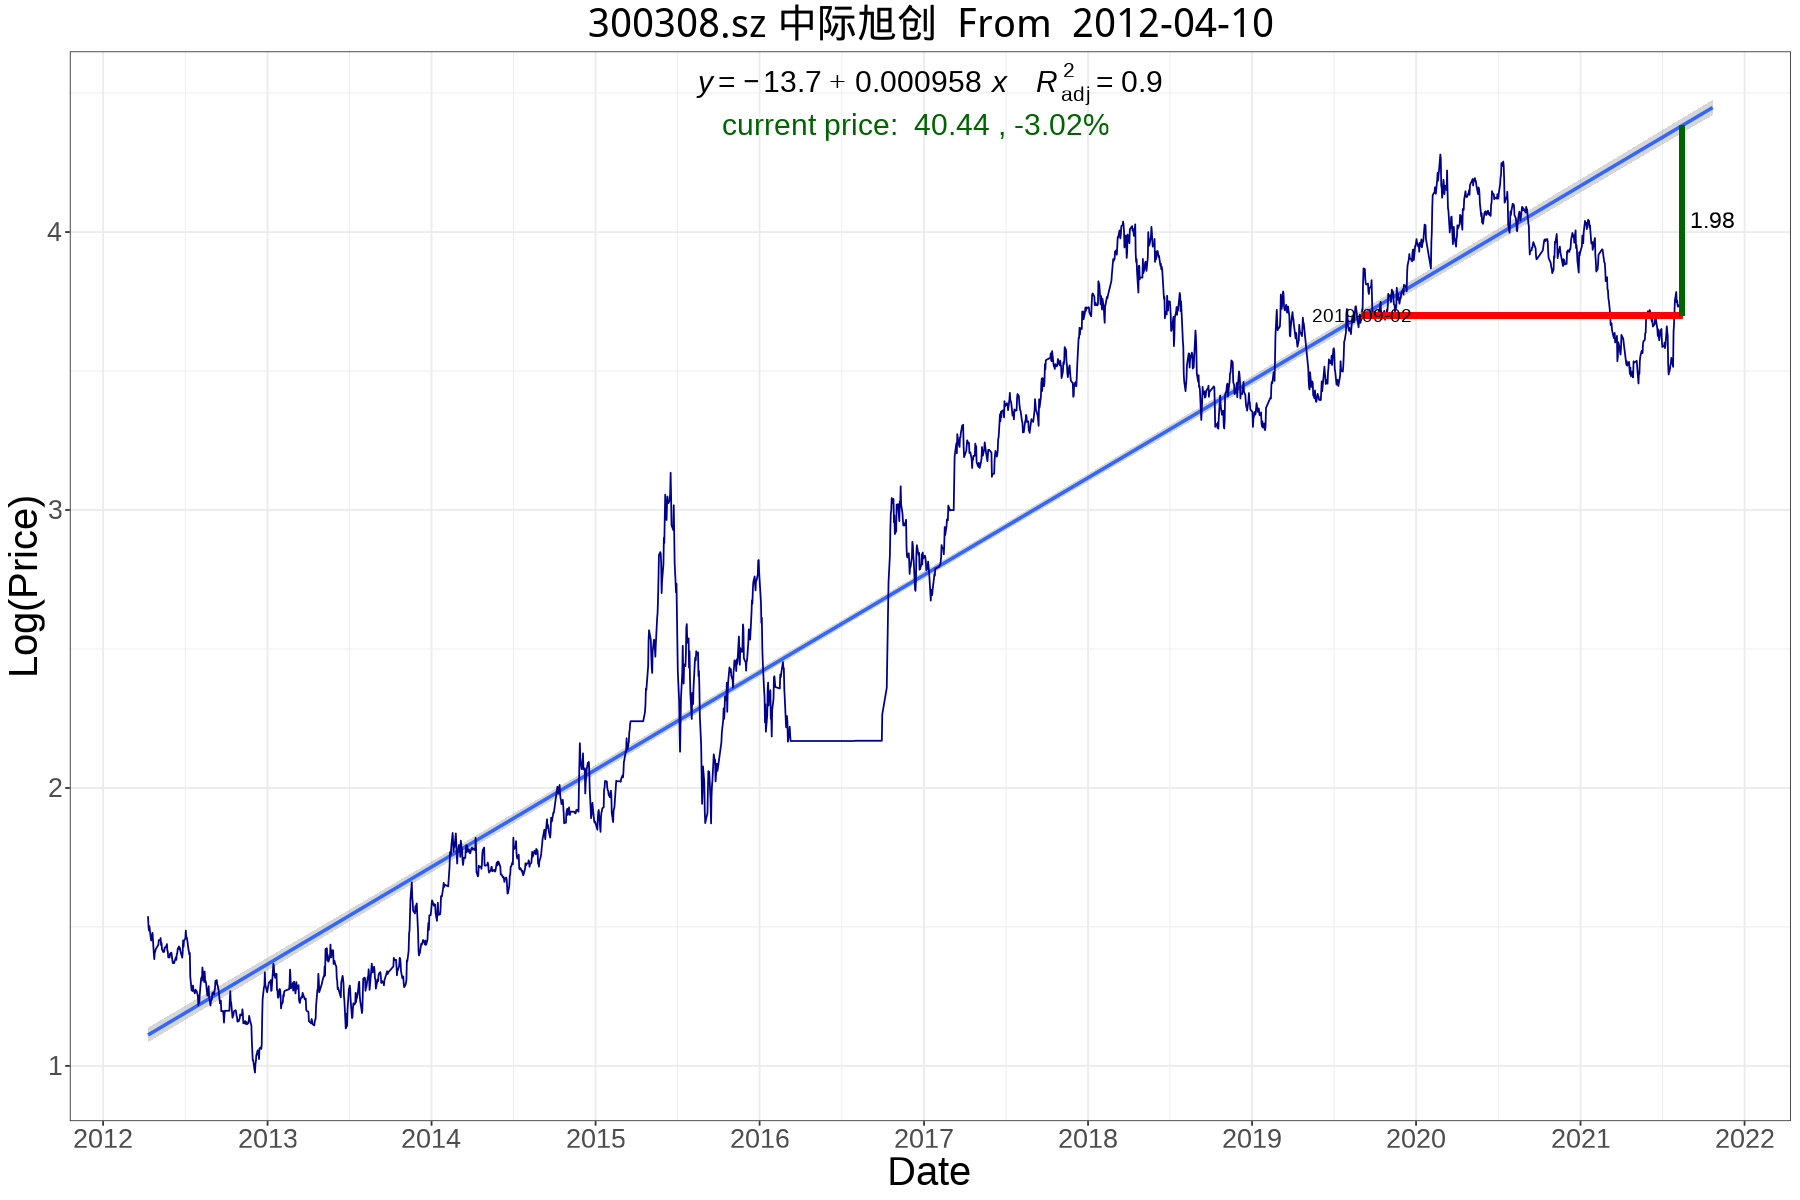

[1] 18.99178
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


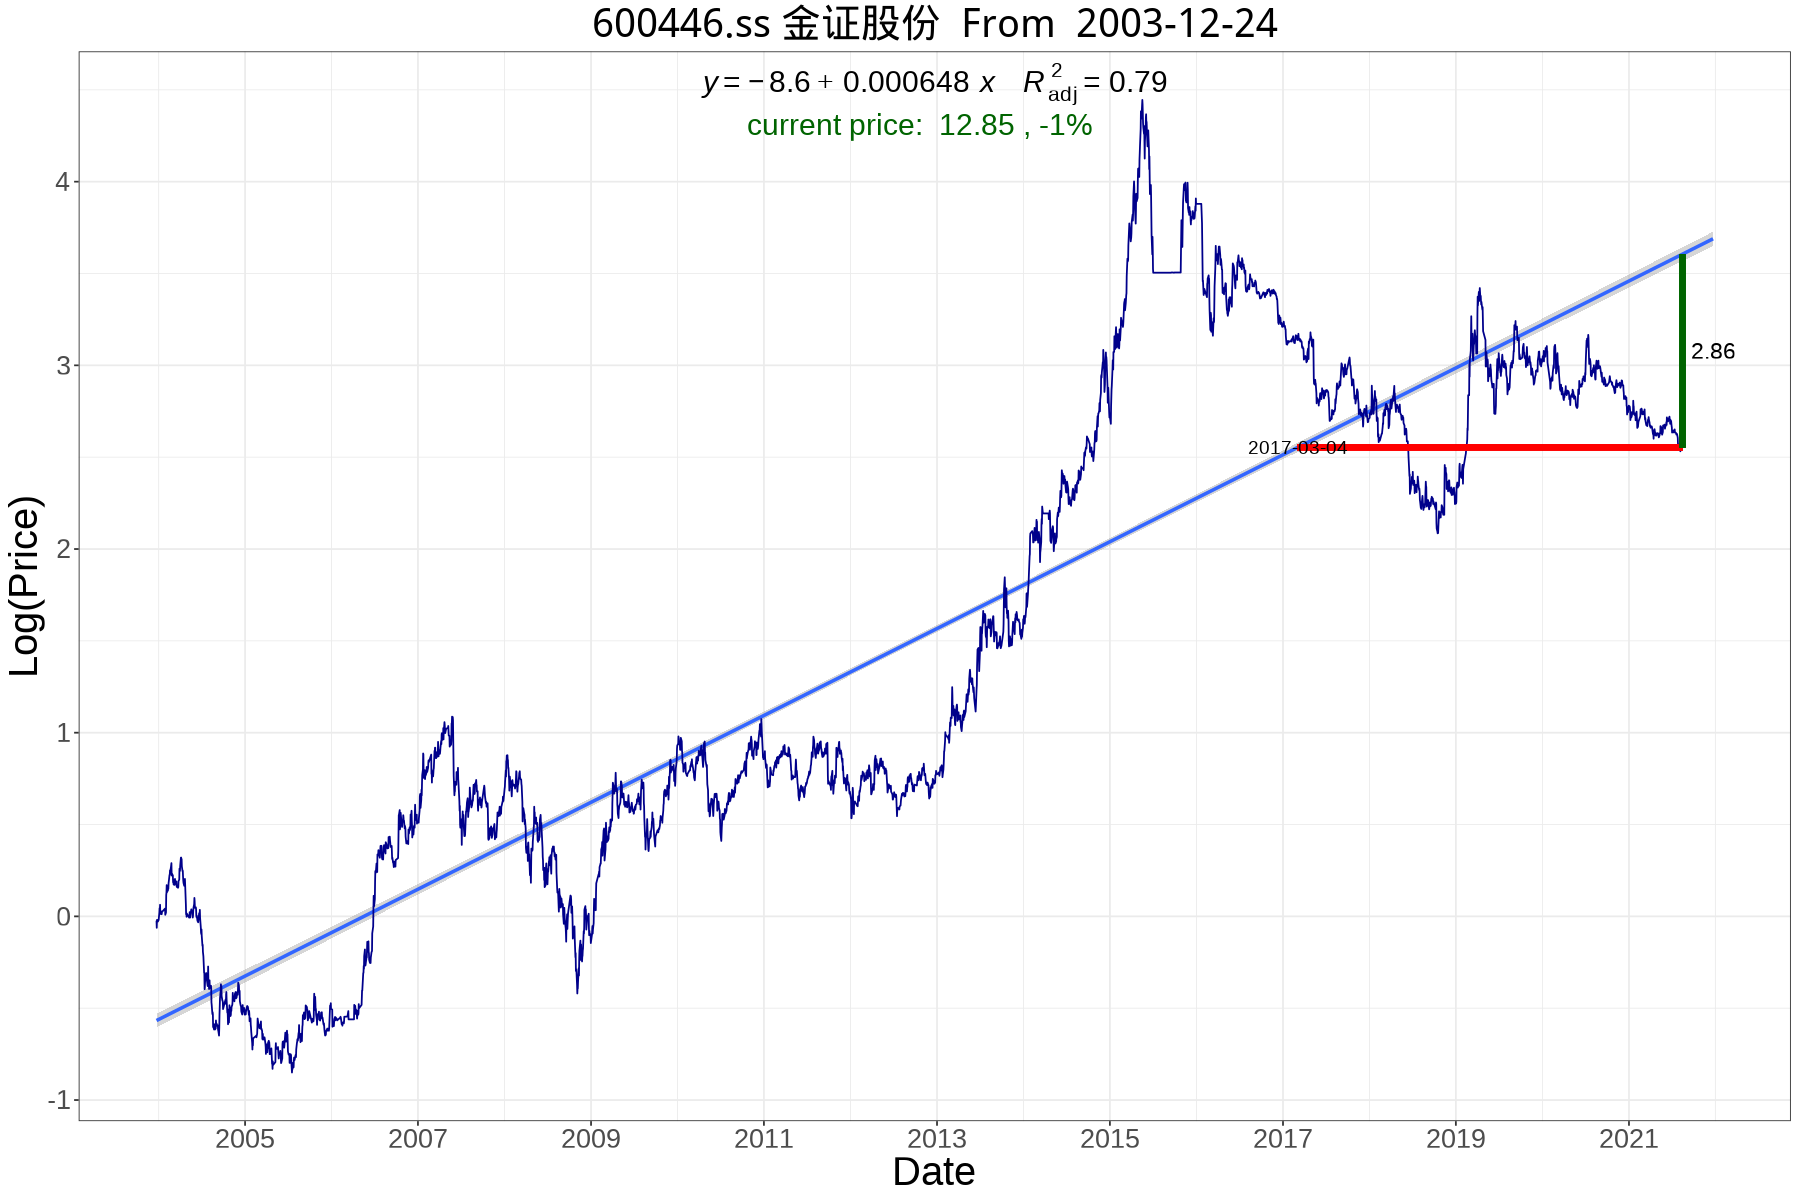

[1] 27.55068
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


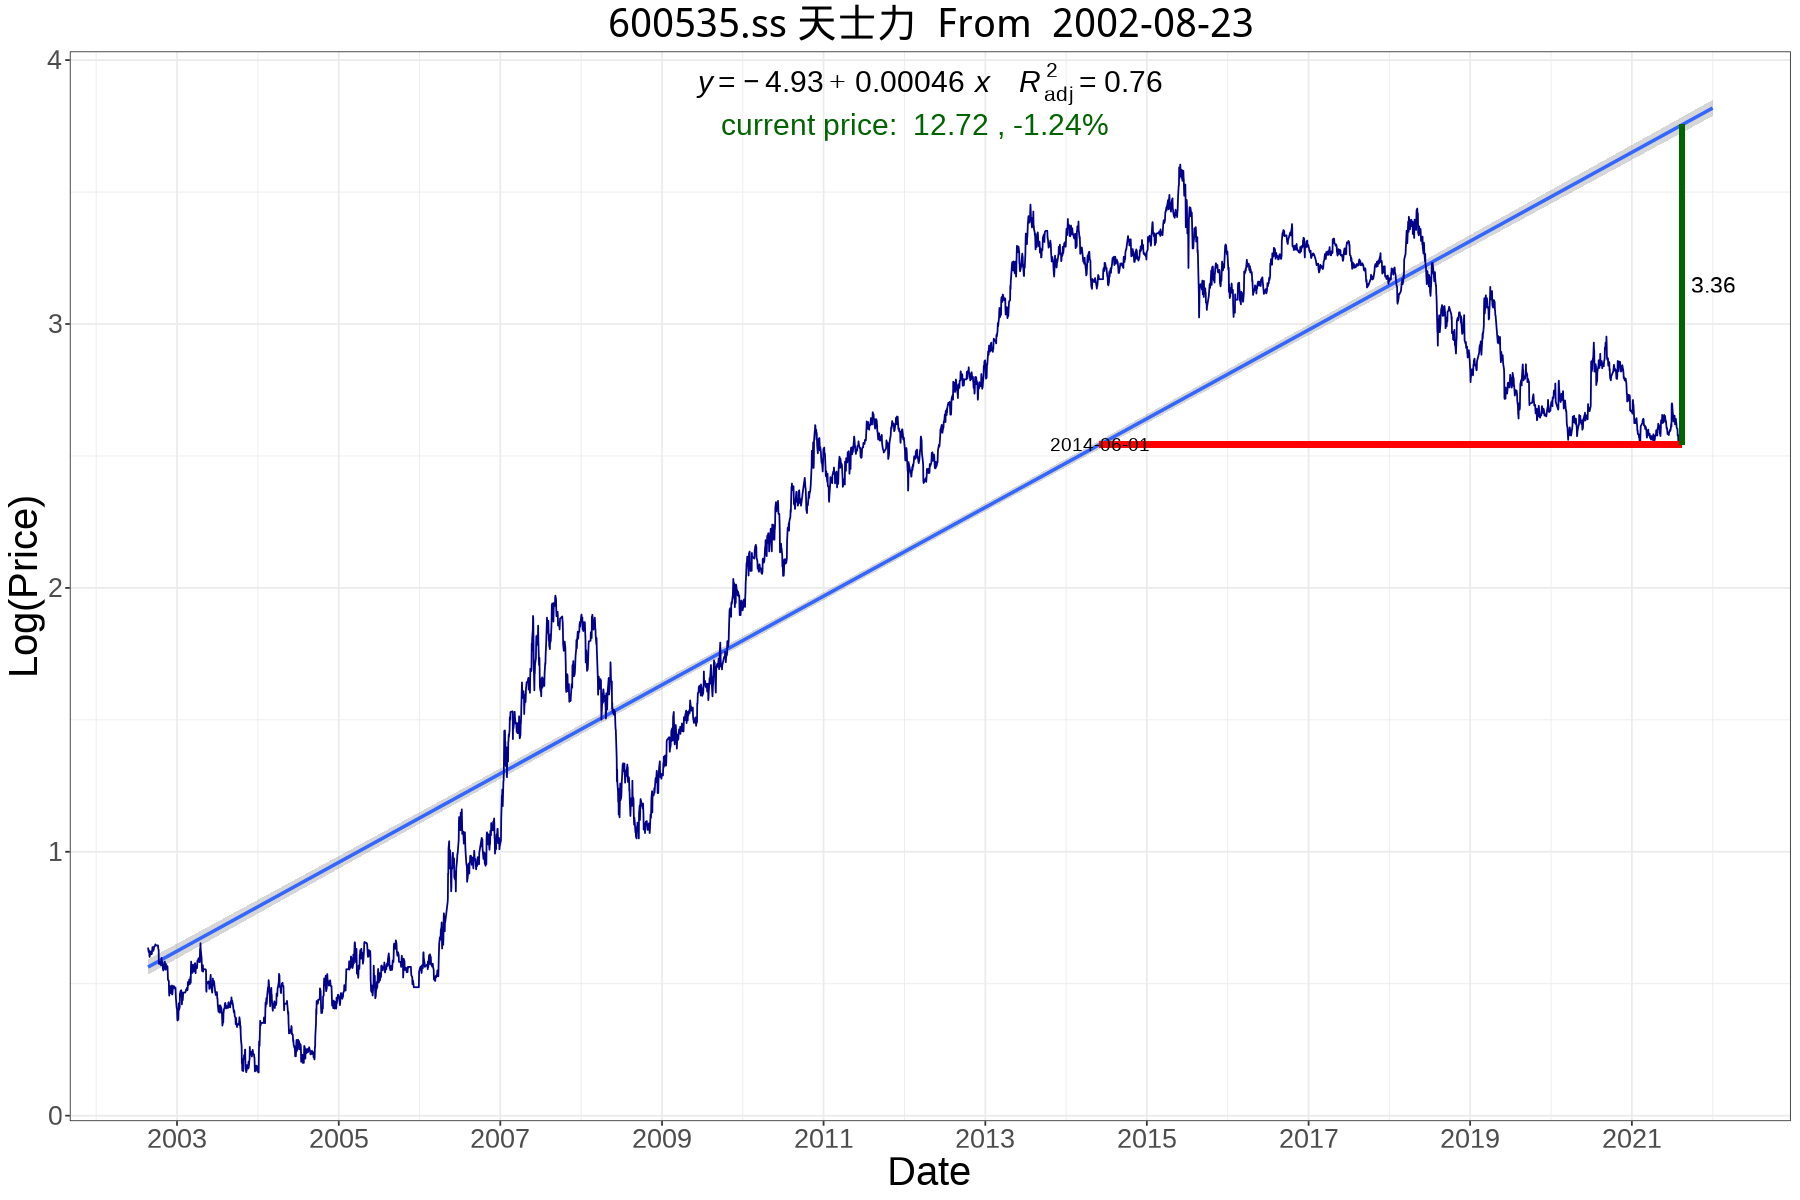

[1] 17.35342
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


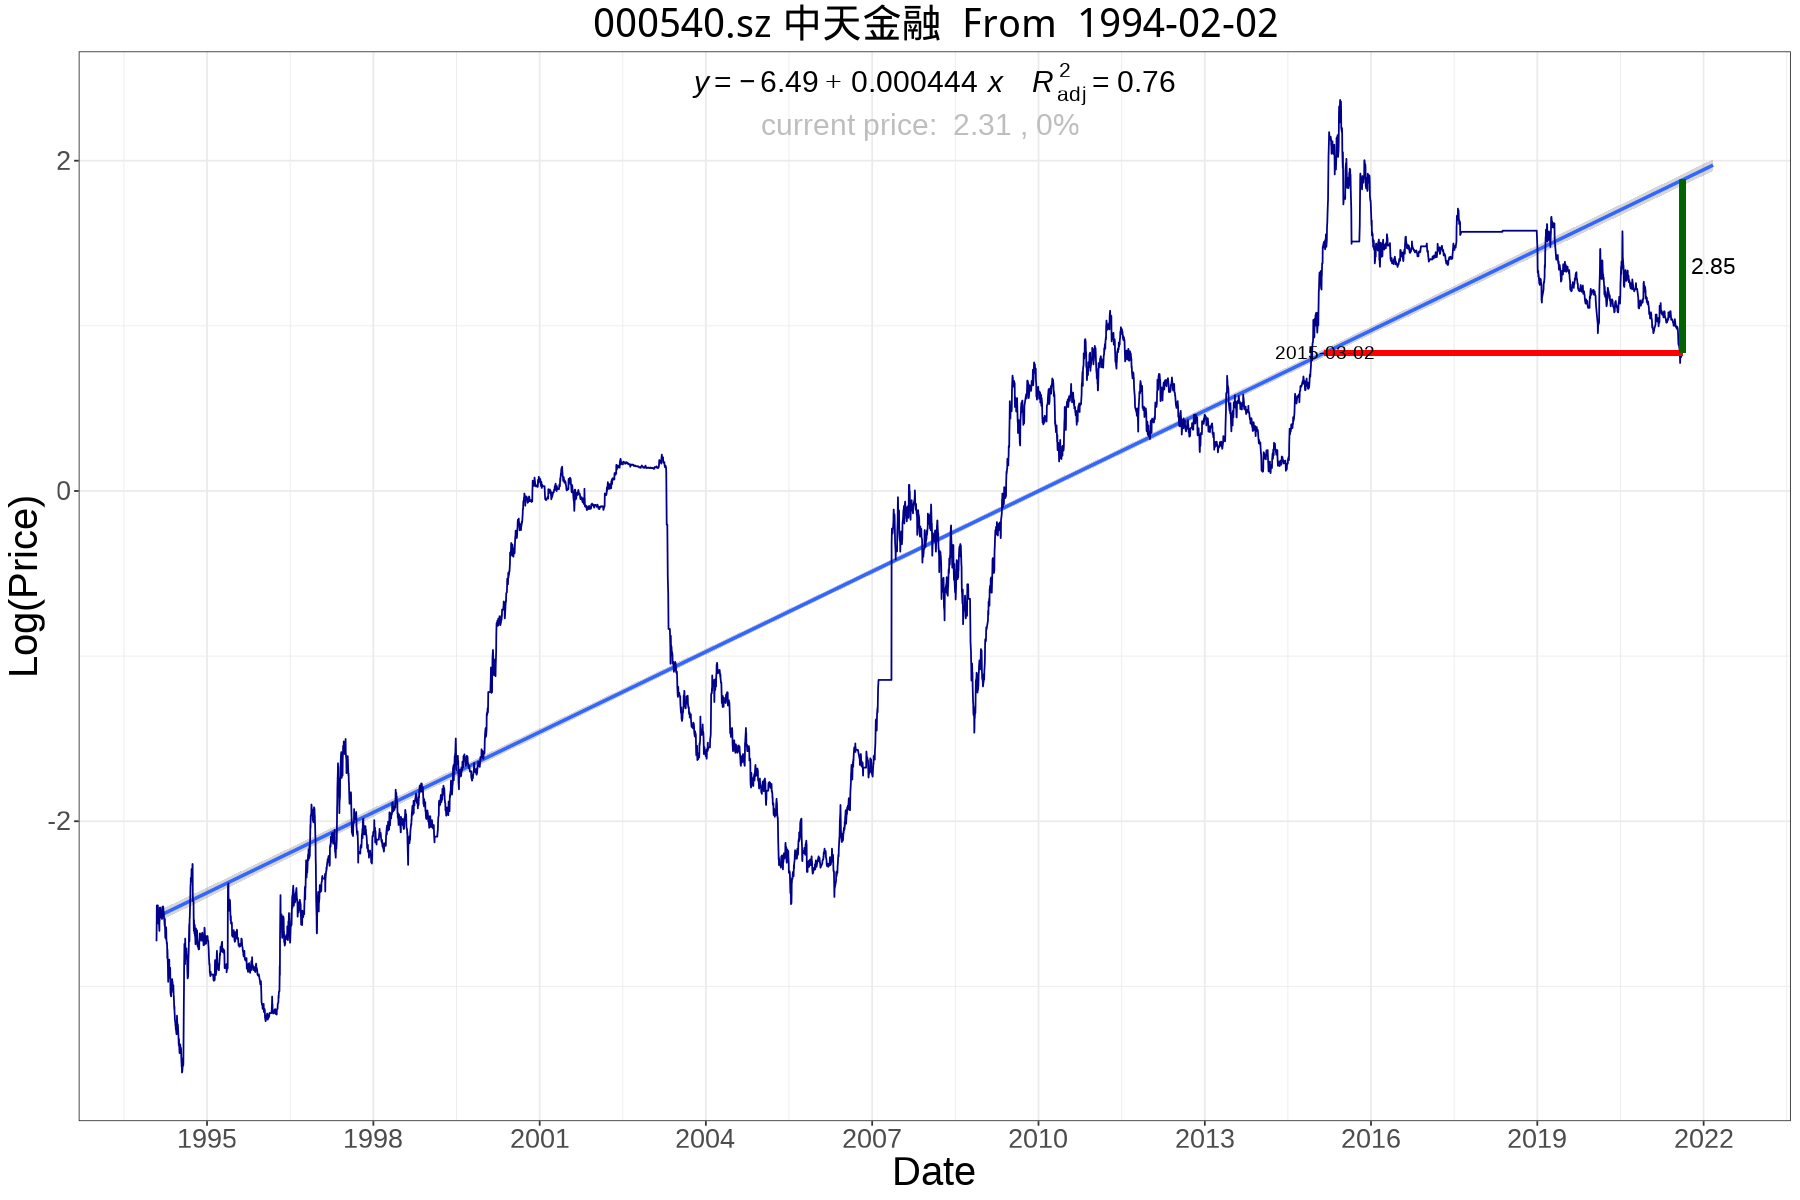

[1] 11.15342
[[1]]



r square lower than 0.75


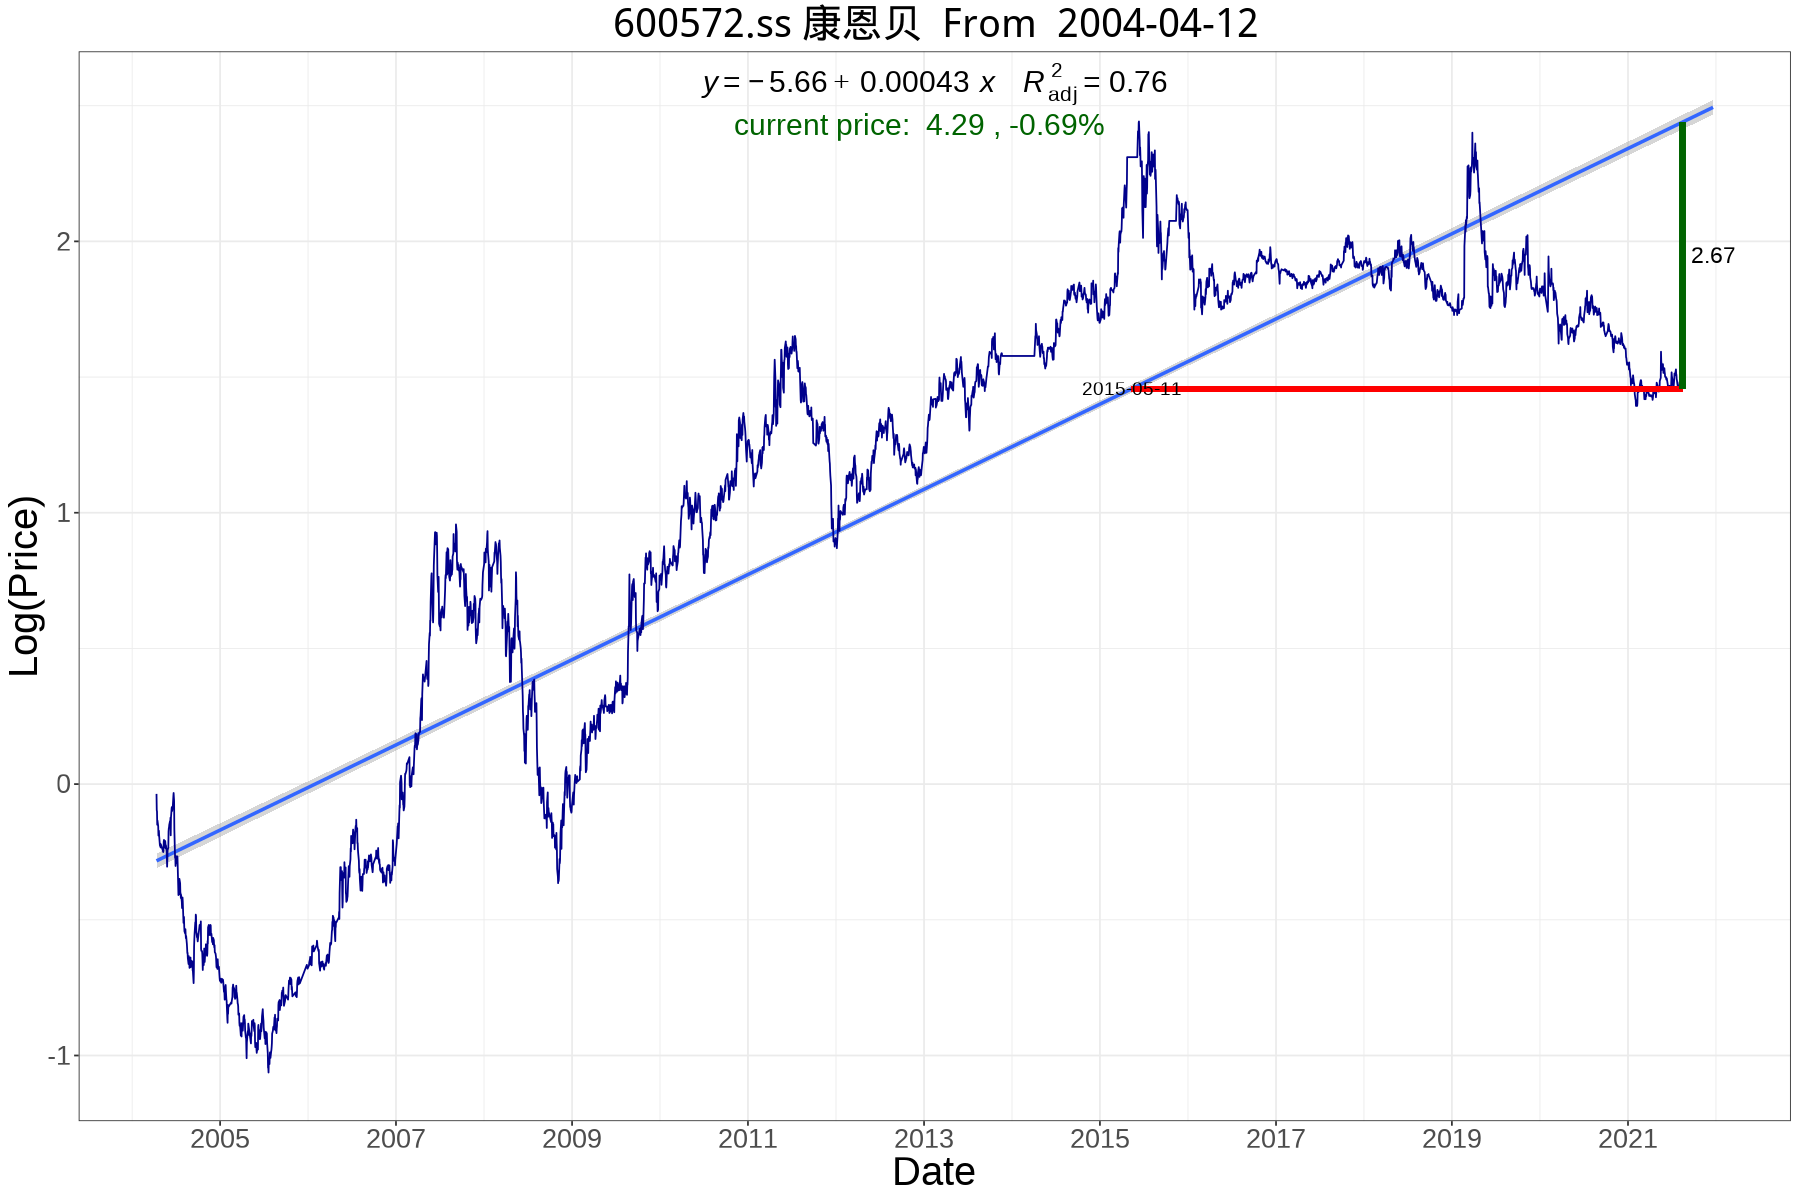

[1] 10.73425
[[1]]



r square lower than 0.75
r square lower than 0.75


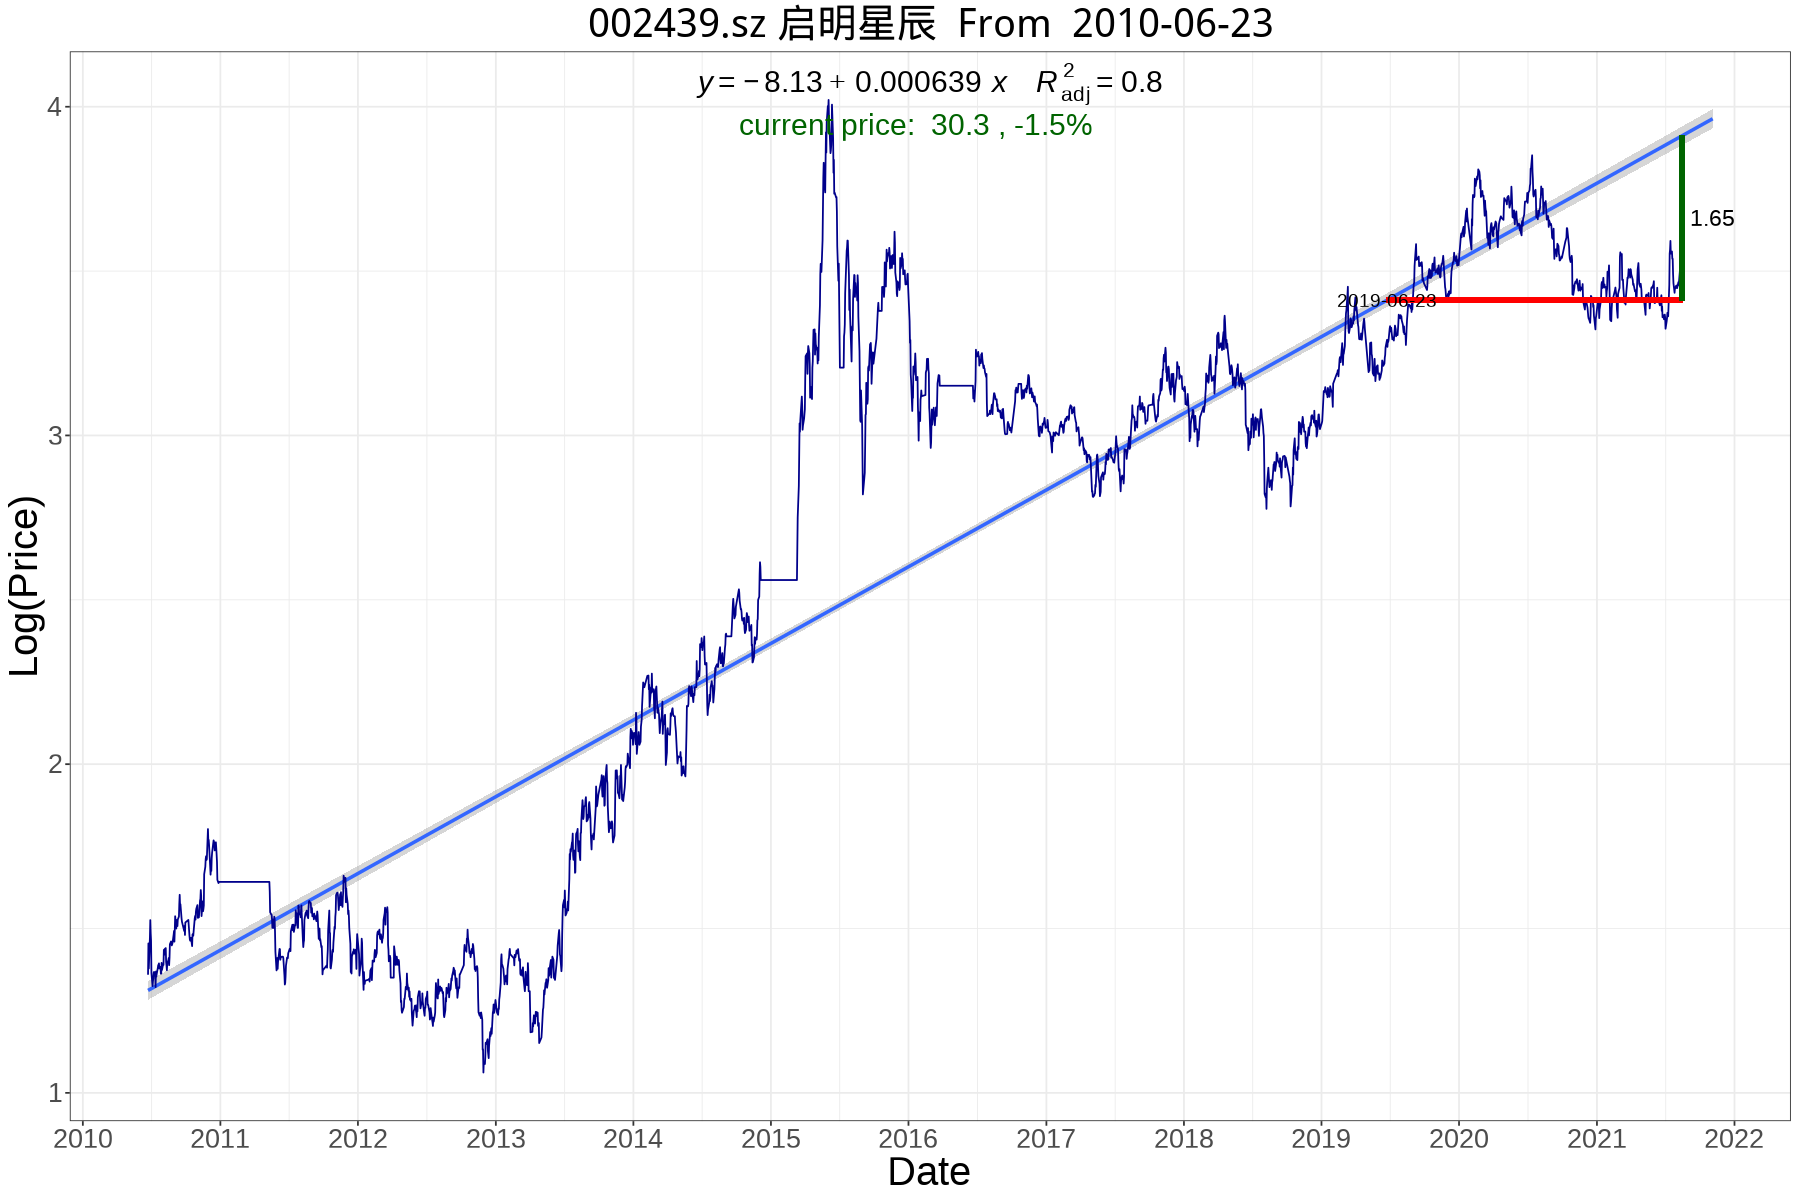

[1] 25.15342
[[1]]



r square lower than 0.75


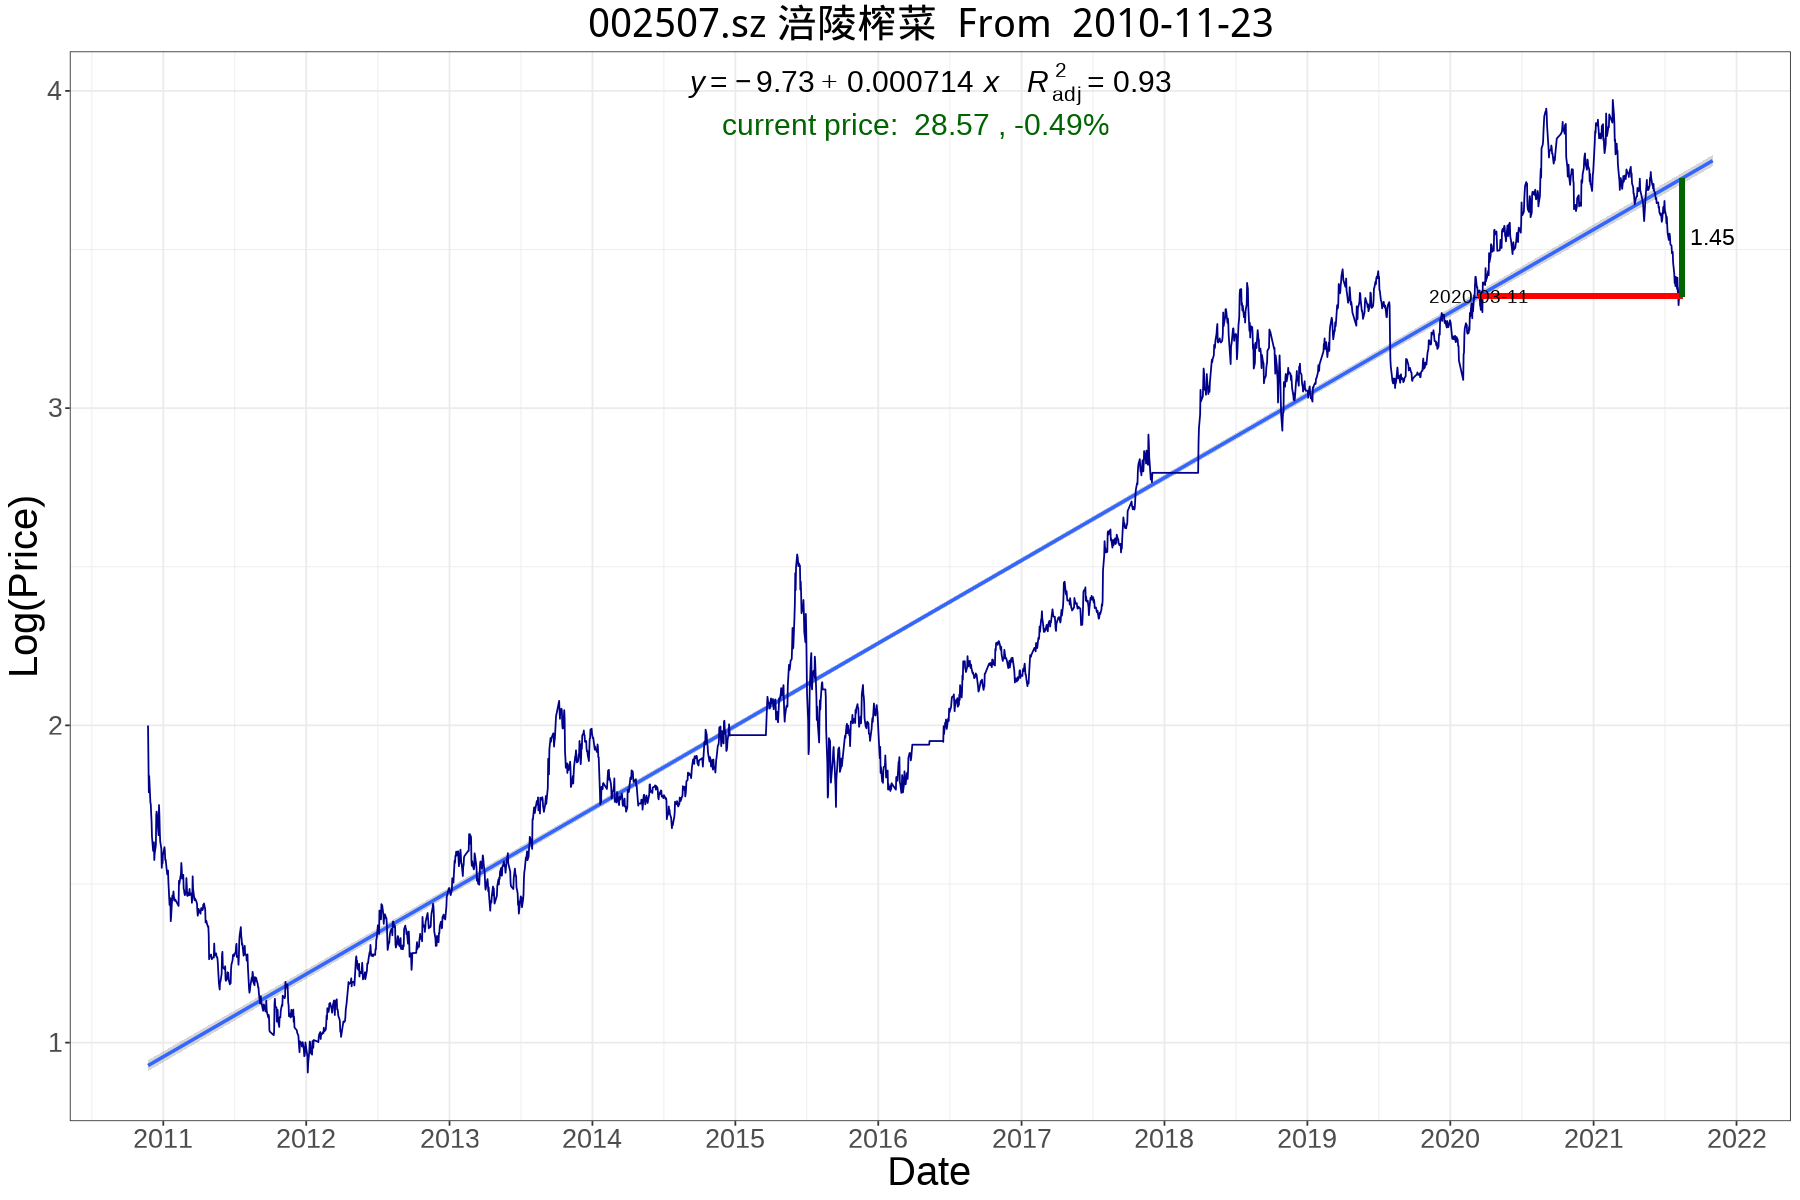

[1] 24.28767
[[1]]



r square lower than 0.75
r square lower than 0.75


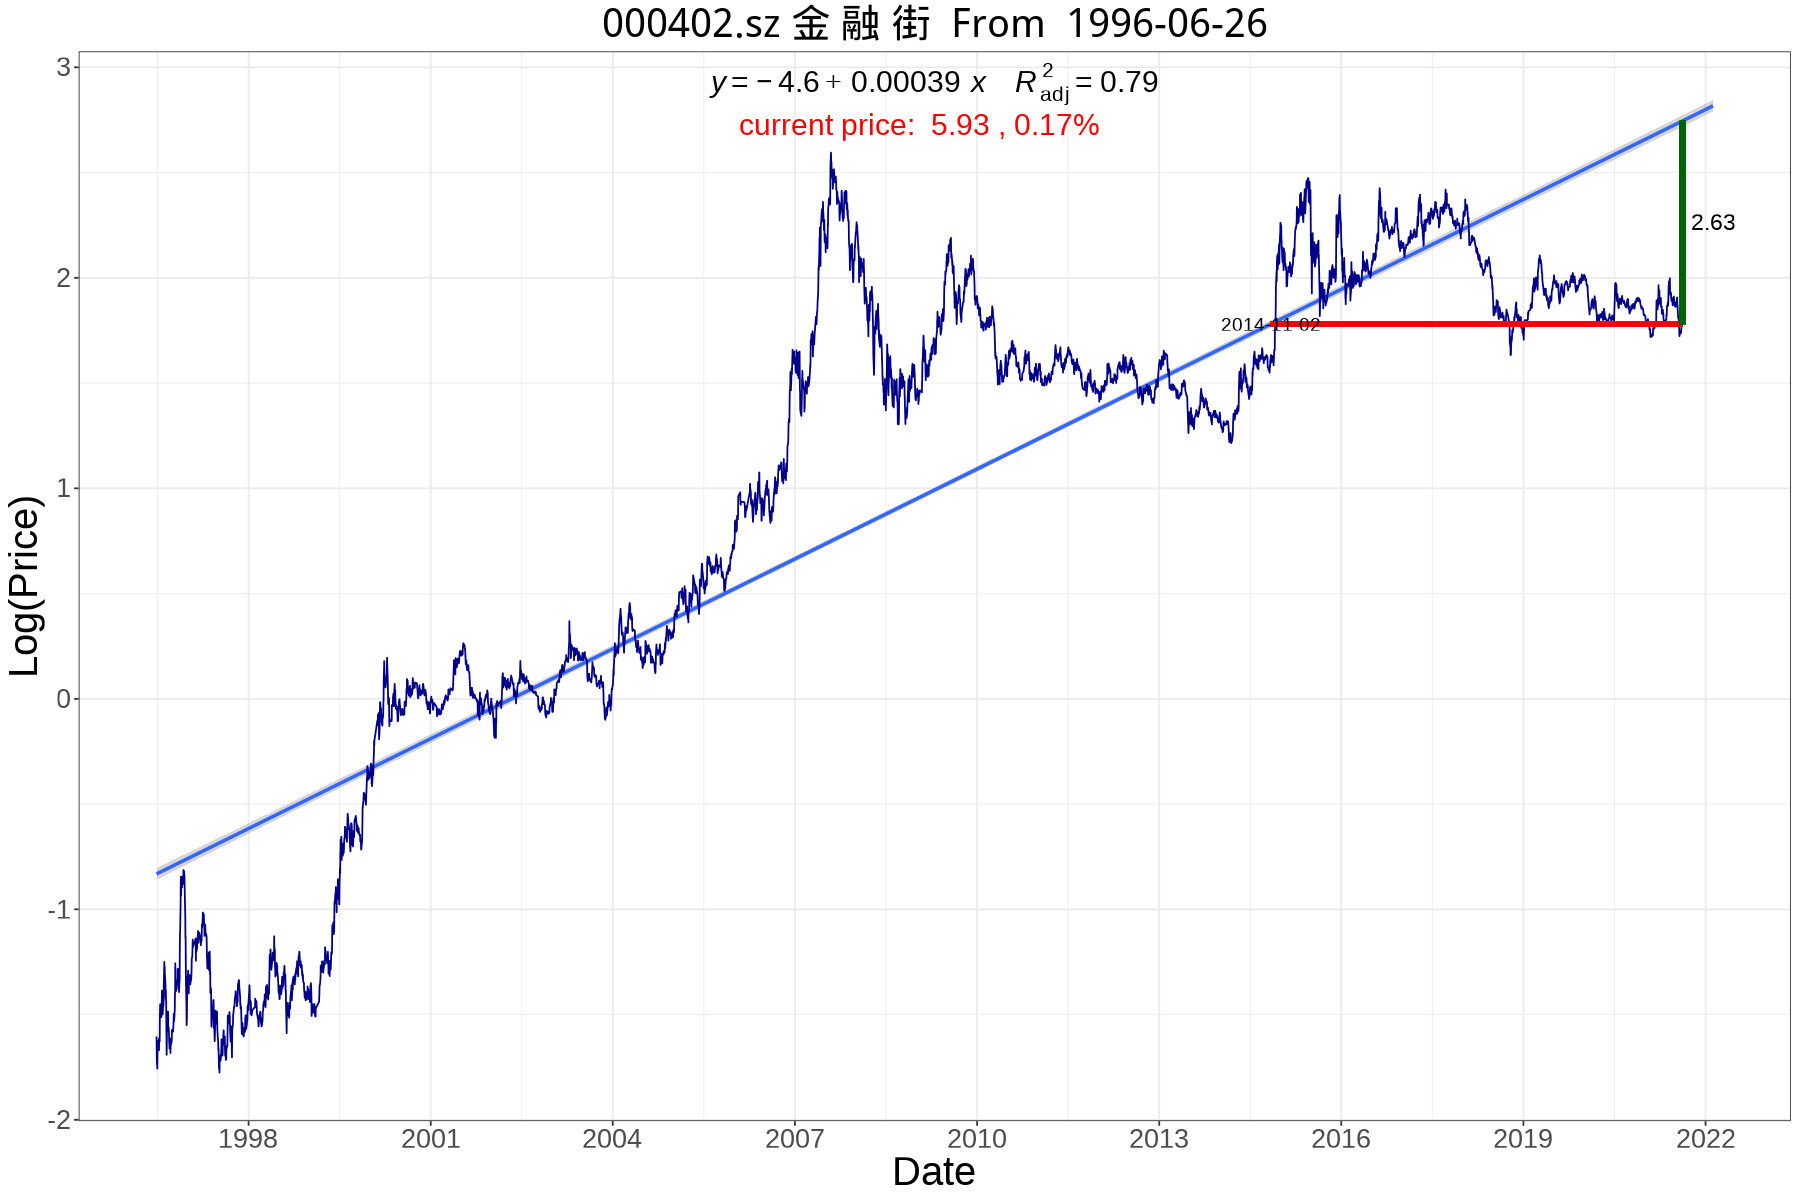

[1] 18.10959
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


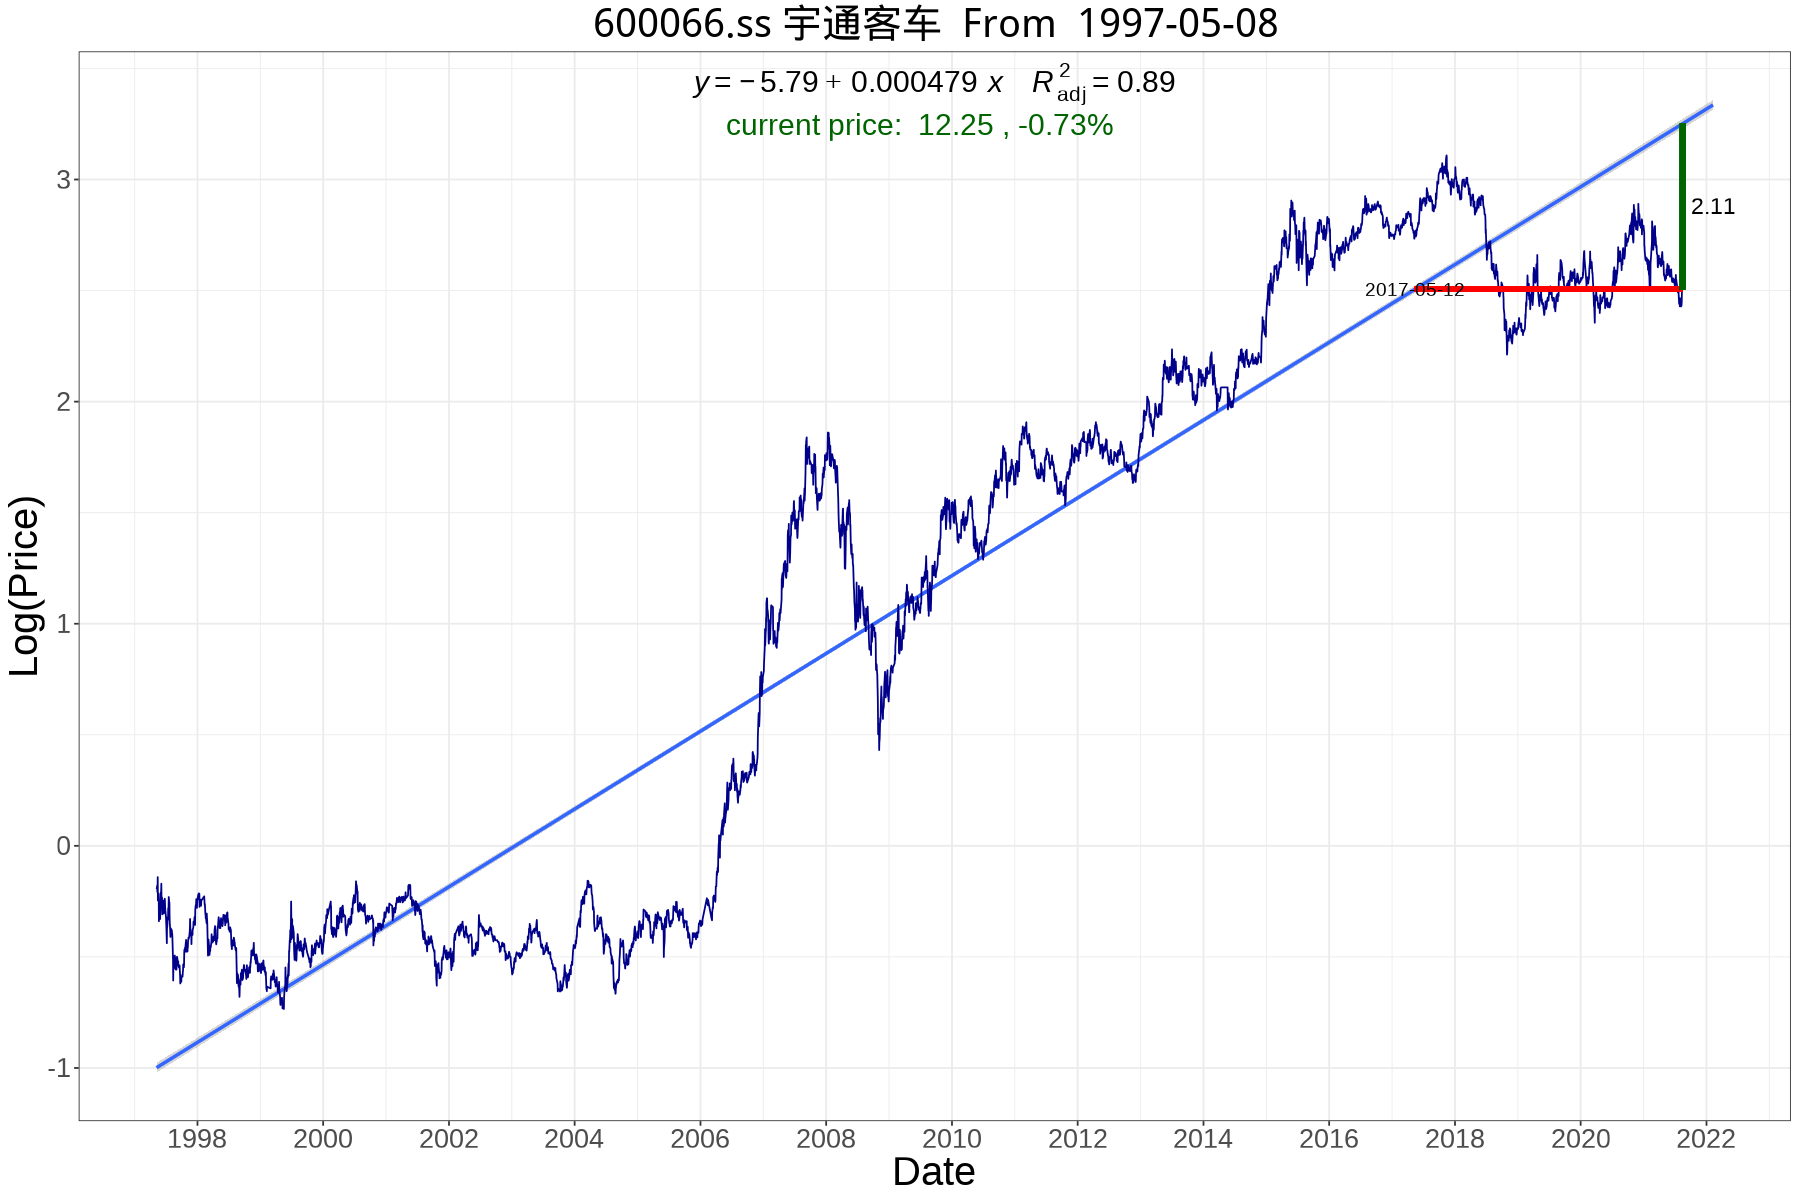

[1] 22.75342
[[1]]


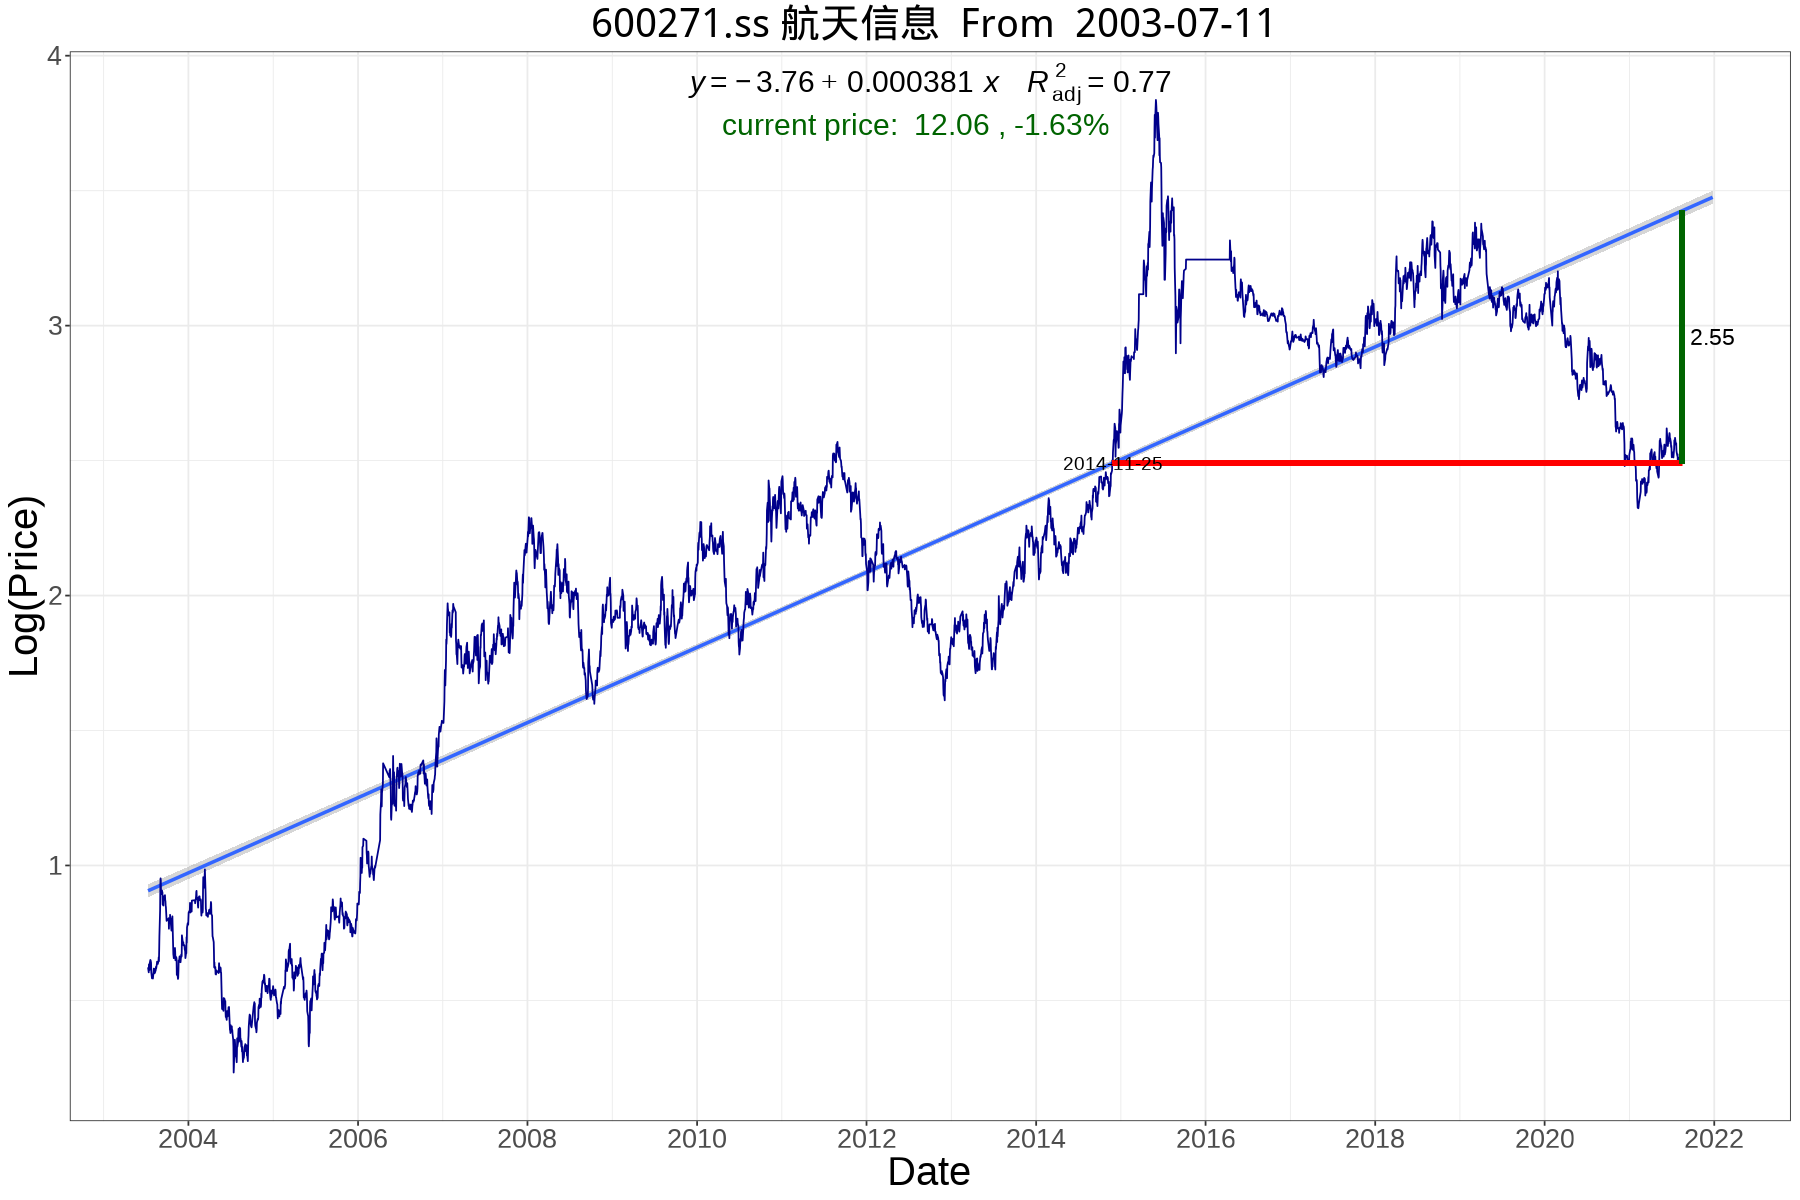

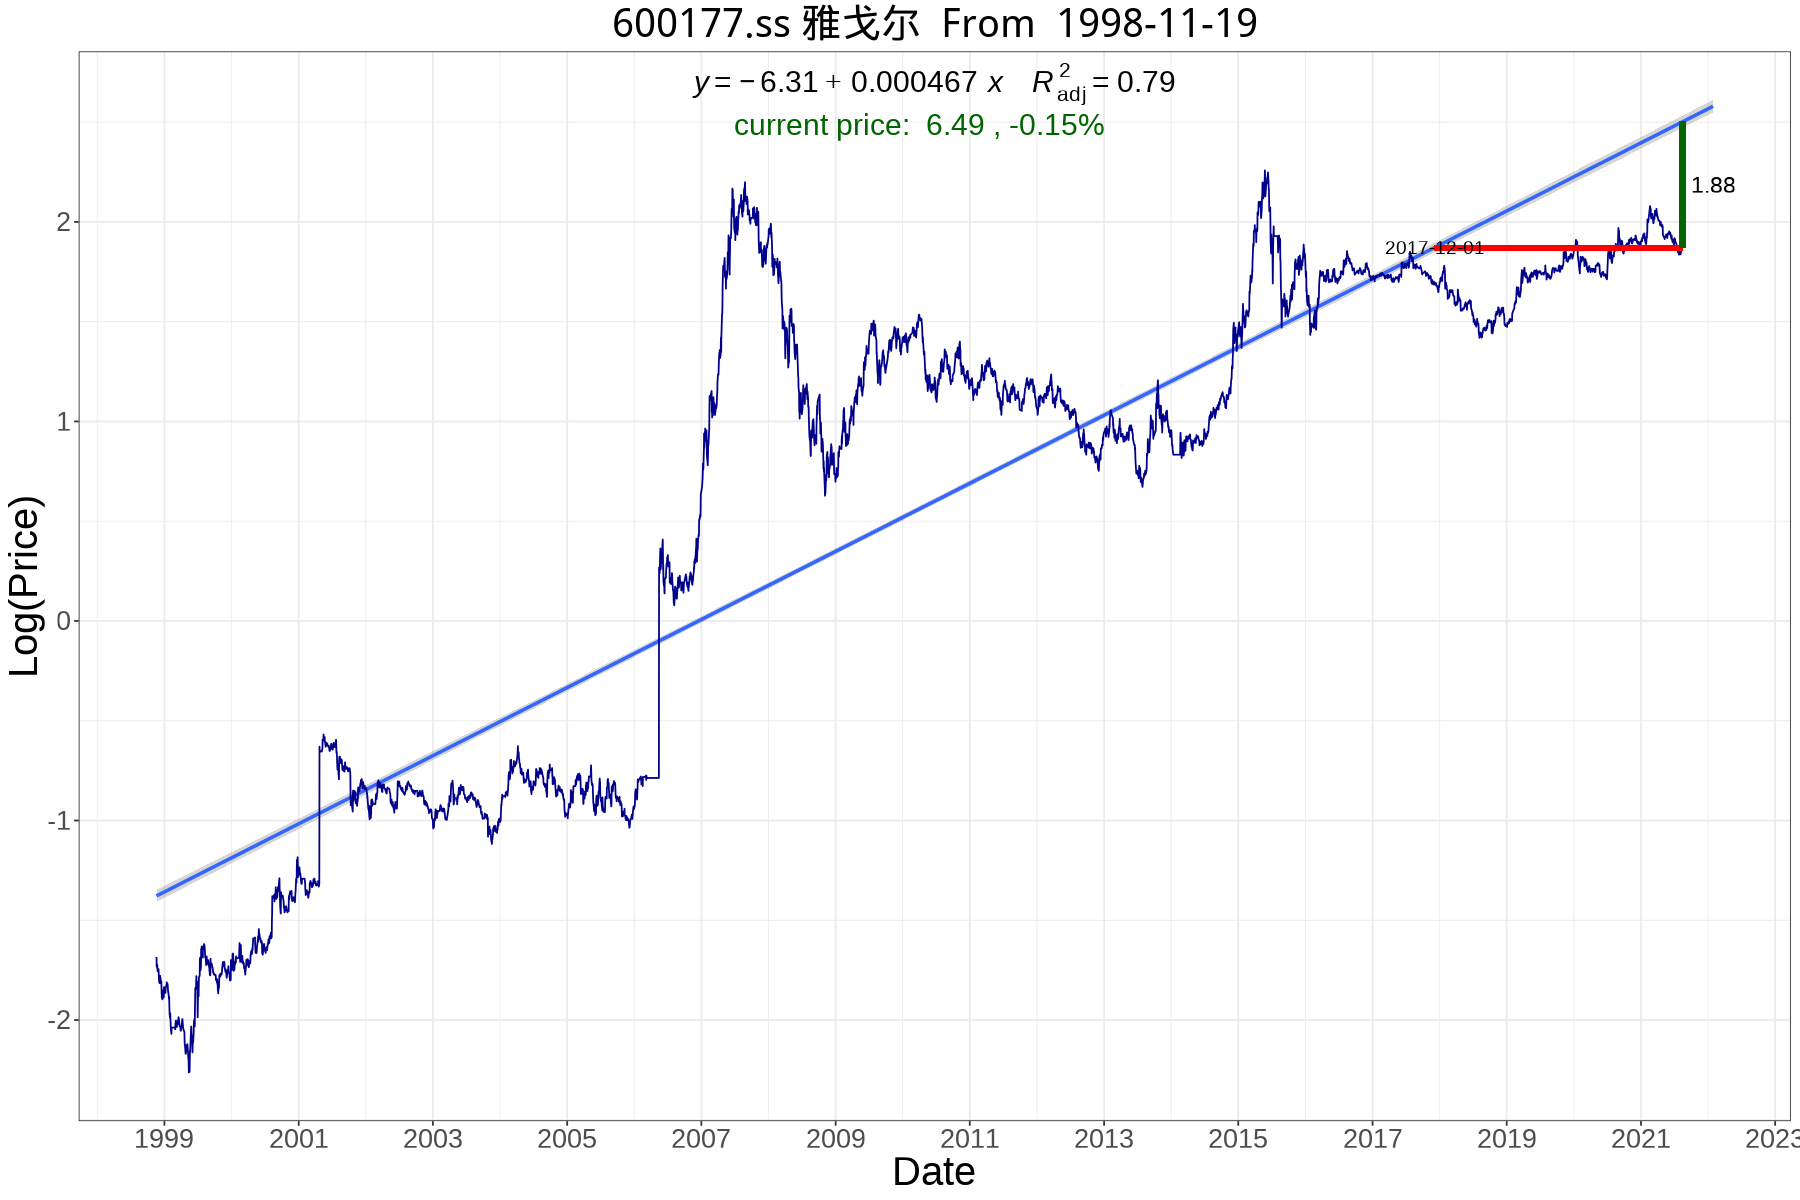

In [12]:
show(lists,1,10,0.75)

In [33]:
#csi1000_url  = 'http://www.csindex.com.cn/uploads/file/autofile/cons/000852cons.xls'
#download.file(csi1000_url, "csi1000.xls")
csi1000_lists = get_stock_list("csi1000.xls",'xls')

Processing 10 items
Processing 20 items
Processing 30 items
Processing 40 items
Processing 50 items
Processing 60 items
Processing 70 items
Processing 80 items
Processing 90 items
Processing 100 items
Processing 110 items
Processing 120 items
Processing 130 items
Processing 140 items
Processing 150 items
Processing 160 items
Processing 170 items
Processing 180 items
Processing 190 items
Processing 200 items
Processing 210 items
Processing 220 items
Processing 230 items
Processing 240 items
Processing 250 items
Processing 260 items
Processing 270 items
Processing 280 items
Processing 290 items
Processing 300 items
Processing 310 items
Processing 320 items
Processing 330 items
Processing 340 items
Processing 350 items
Processing 360 items
Processing 370 items
Processing 380 items
Processing 390 items
Processing 400 items
Processing 410 items
Processing 420 items
Processing 430 items
Processing 440 items
Processing 450 items
Processing 460 items
Processing 470 items
Processing 480 items
P

r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


[1] 18.56438
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


[1] 16.96986
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


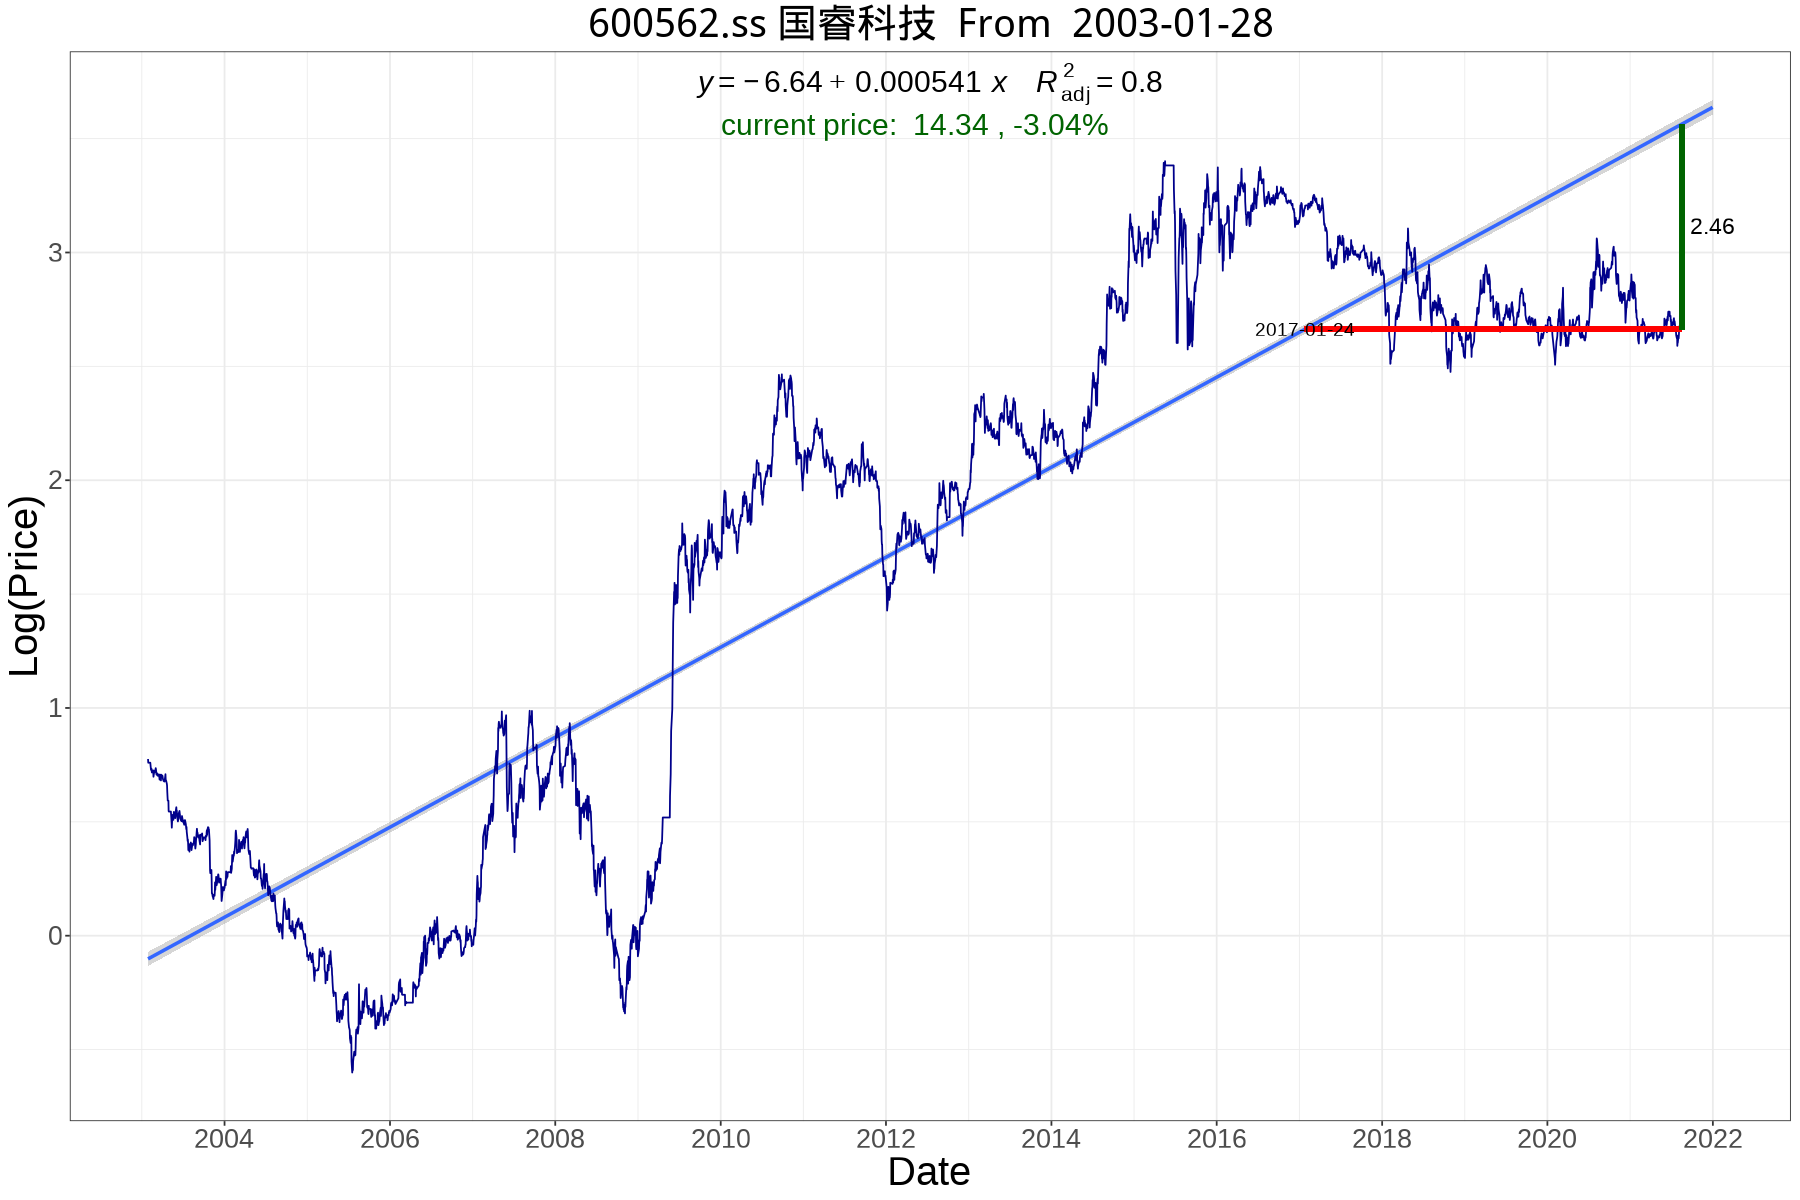

[1] 25.06849
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


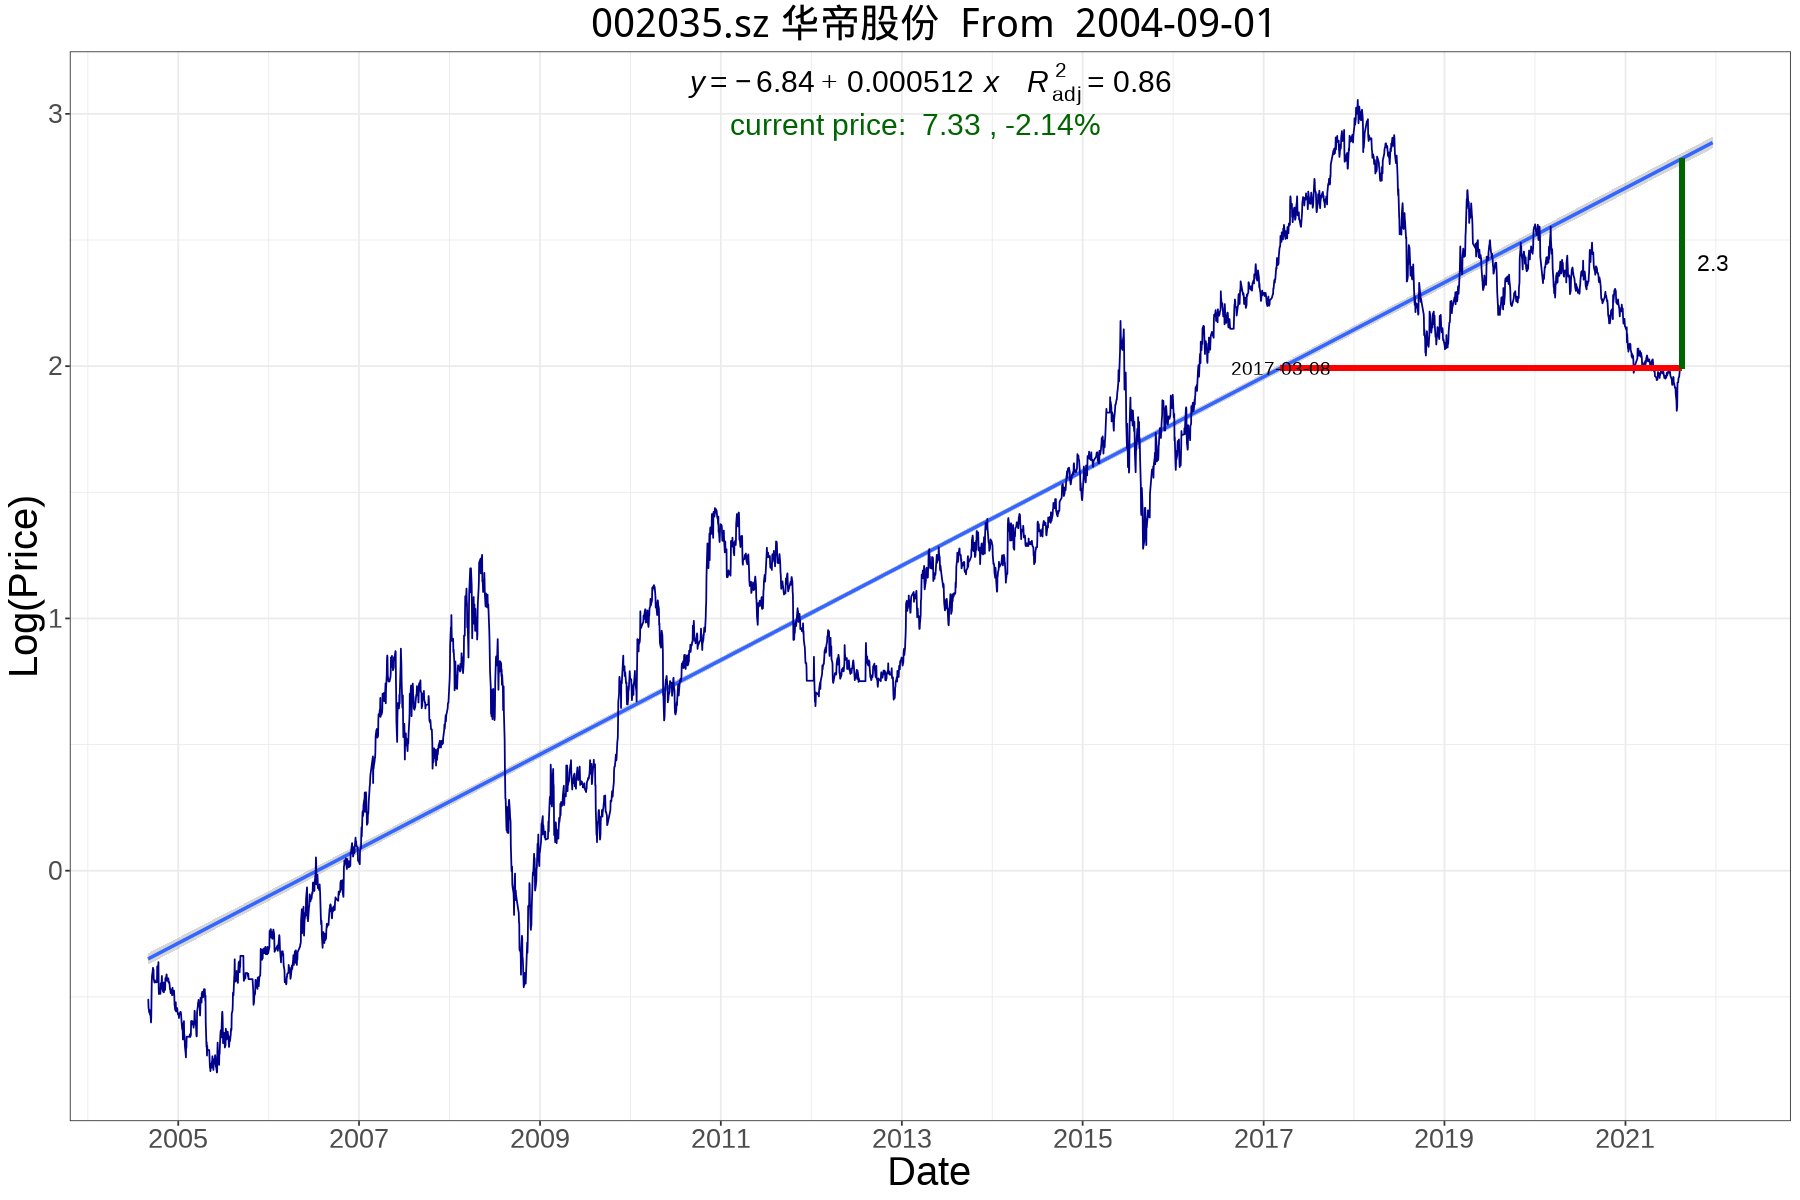

[1] 9.235616
[[1]]


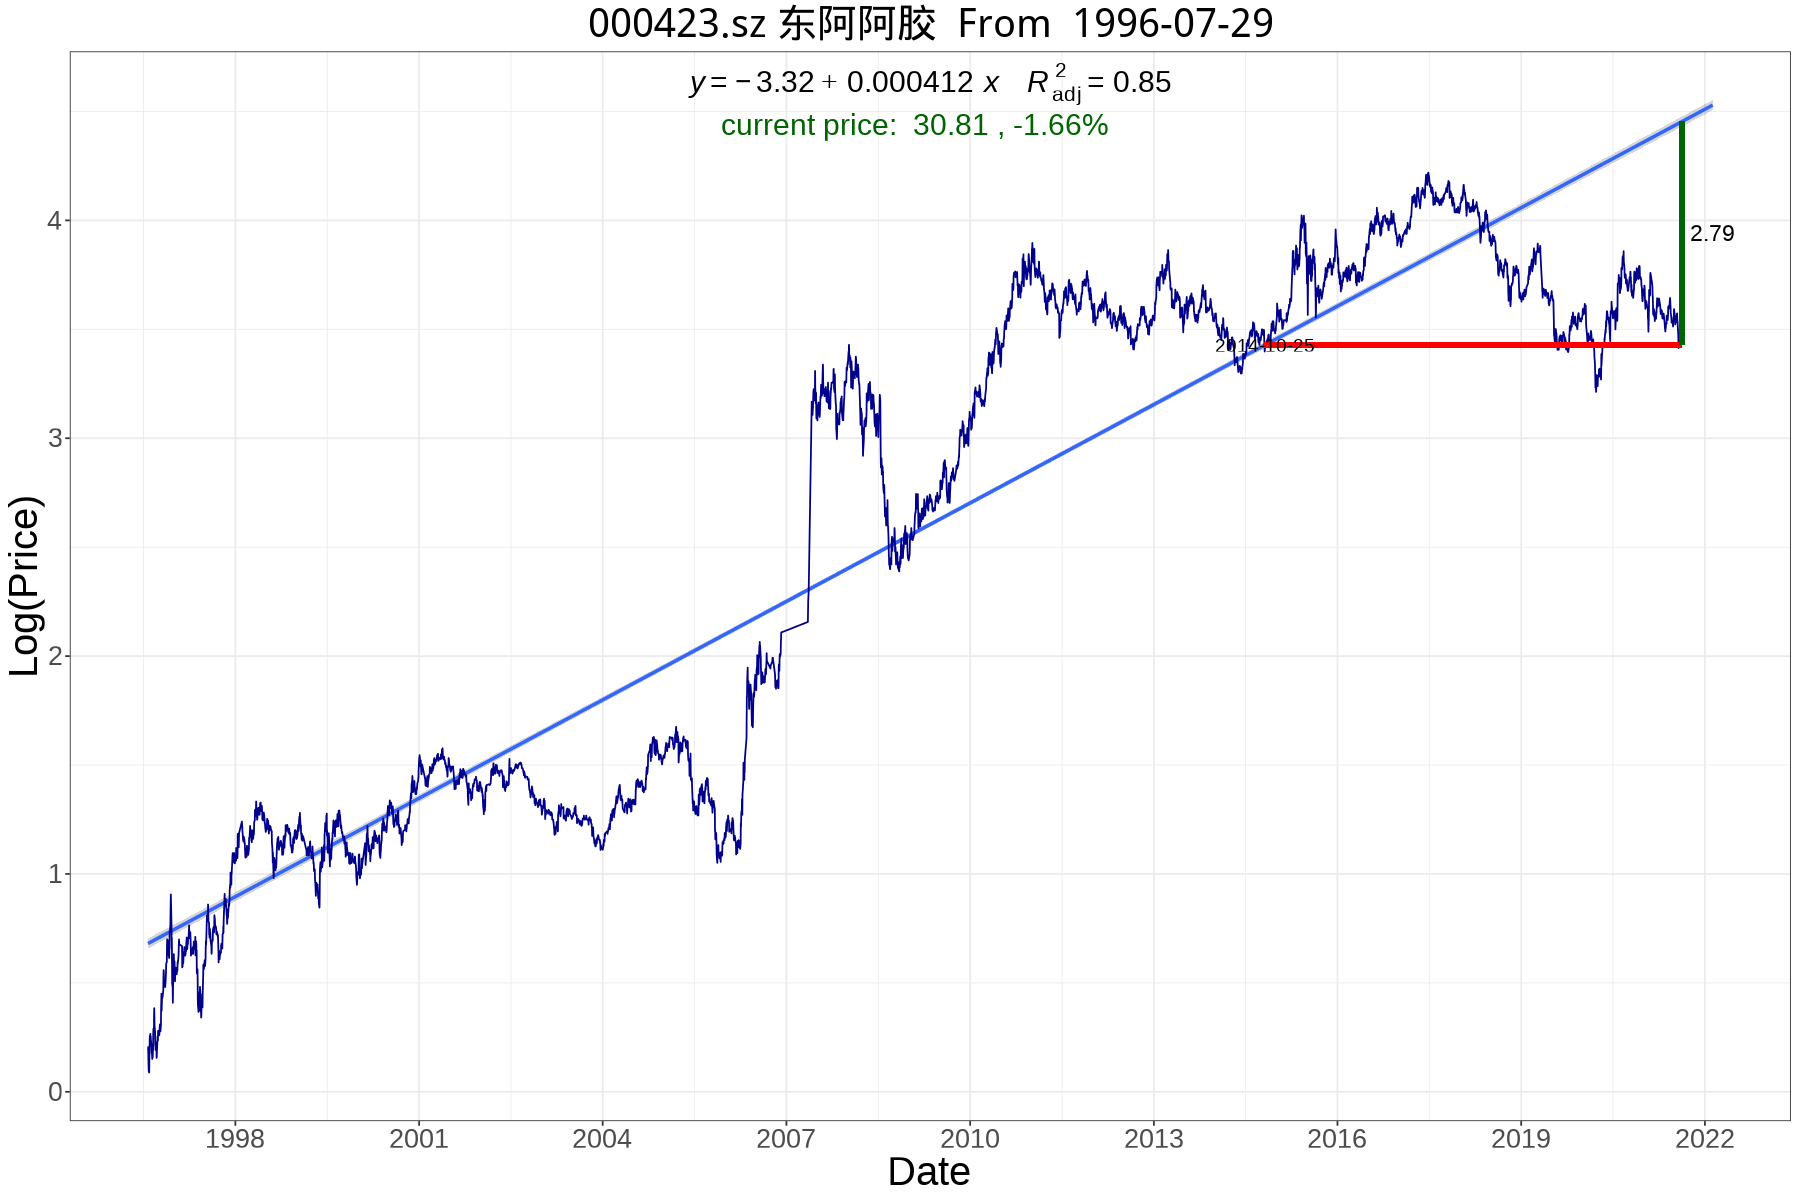


[1] 5.449315
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


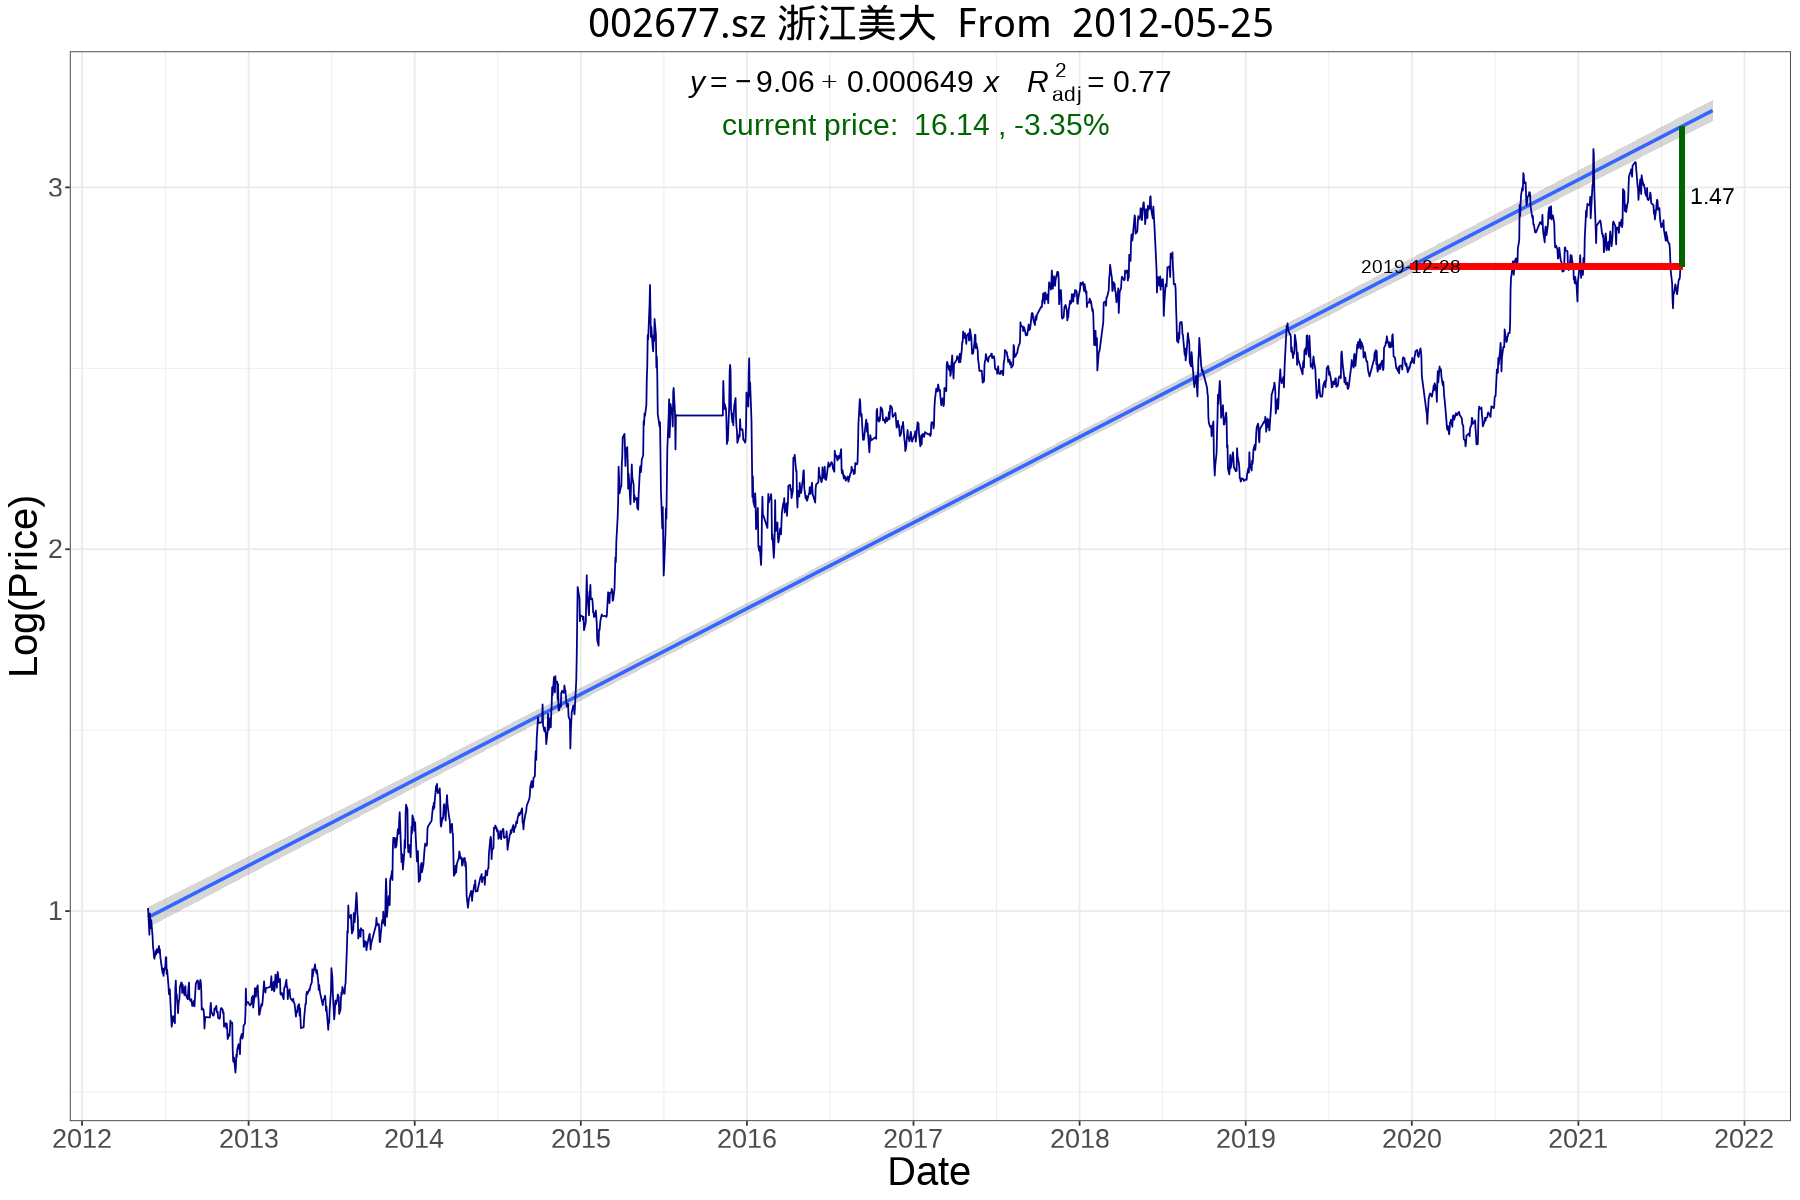

[1] 27.75342
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


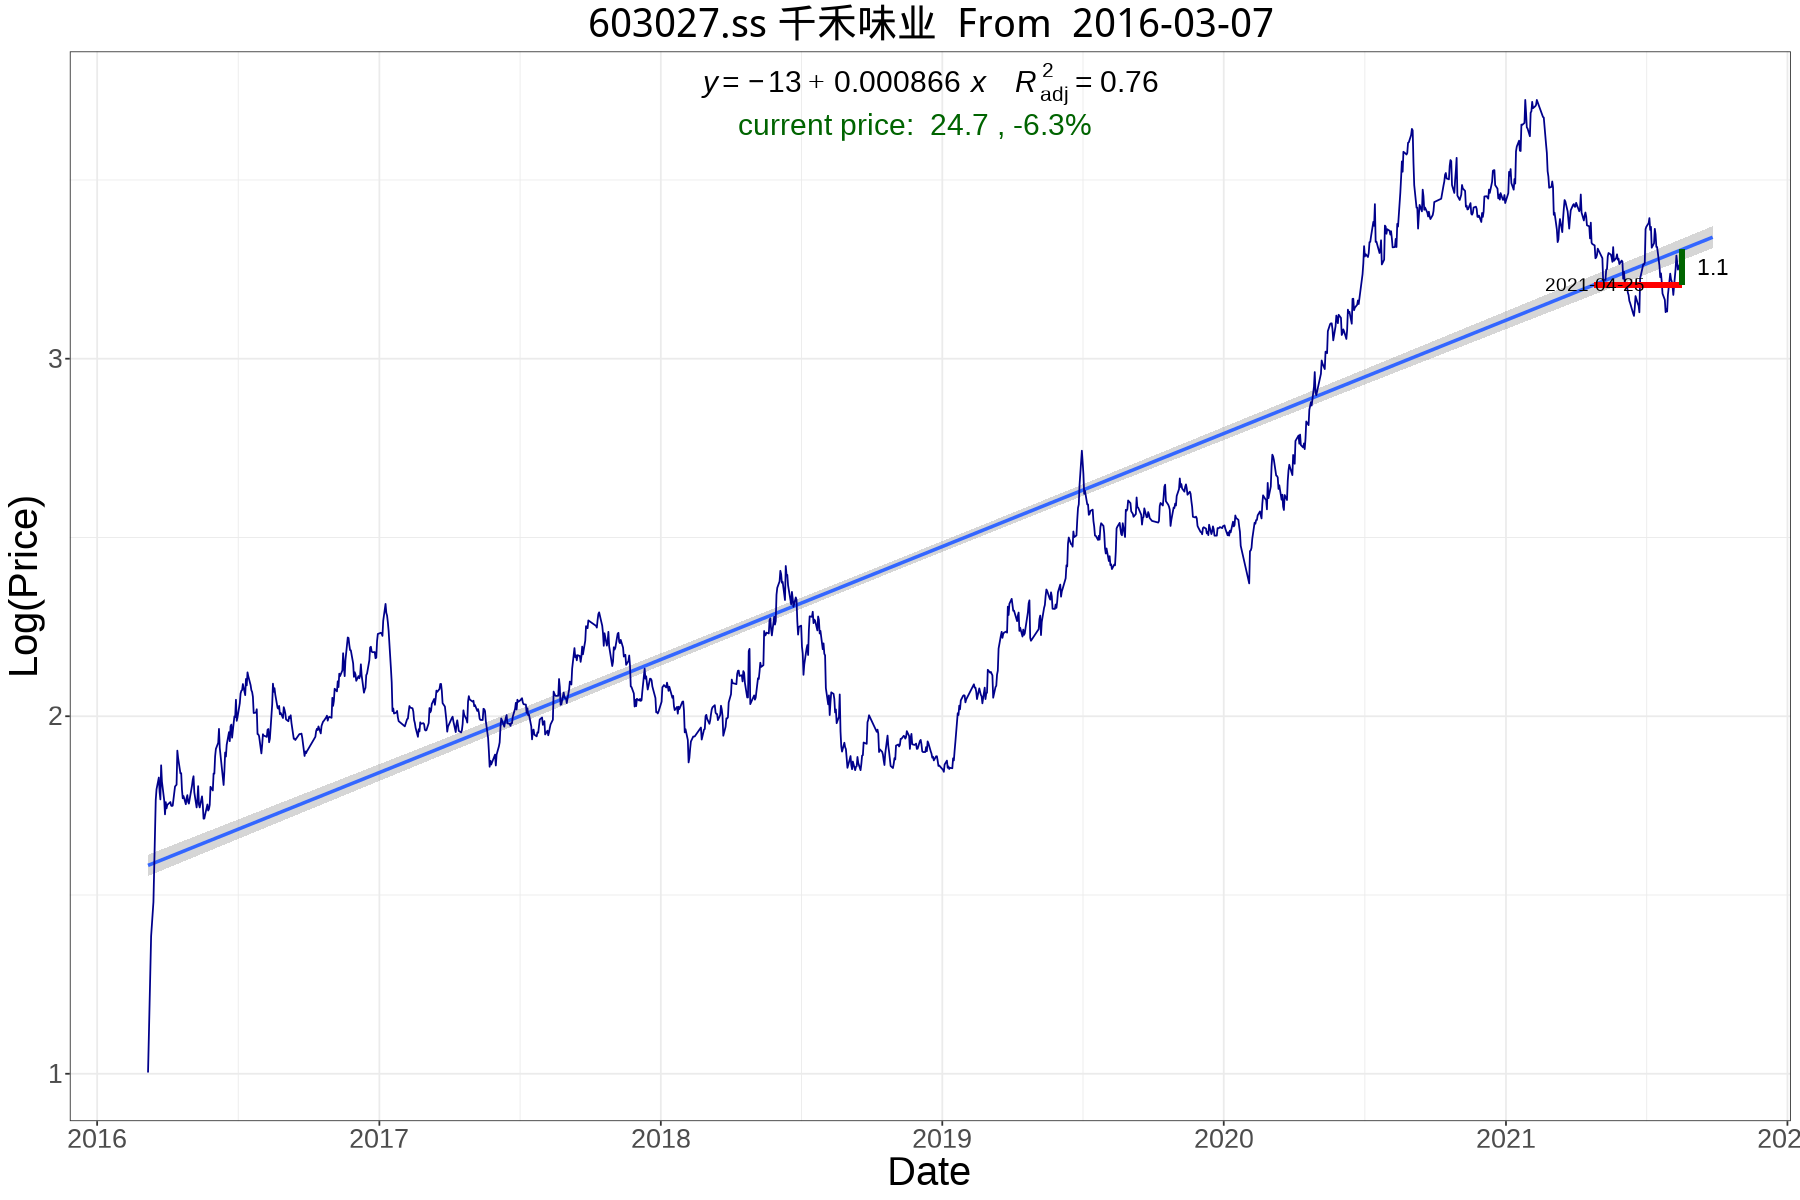

[1] 10.43014
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


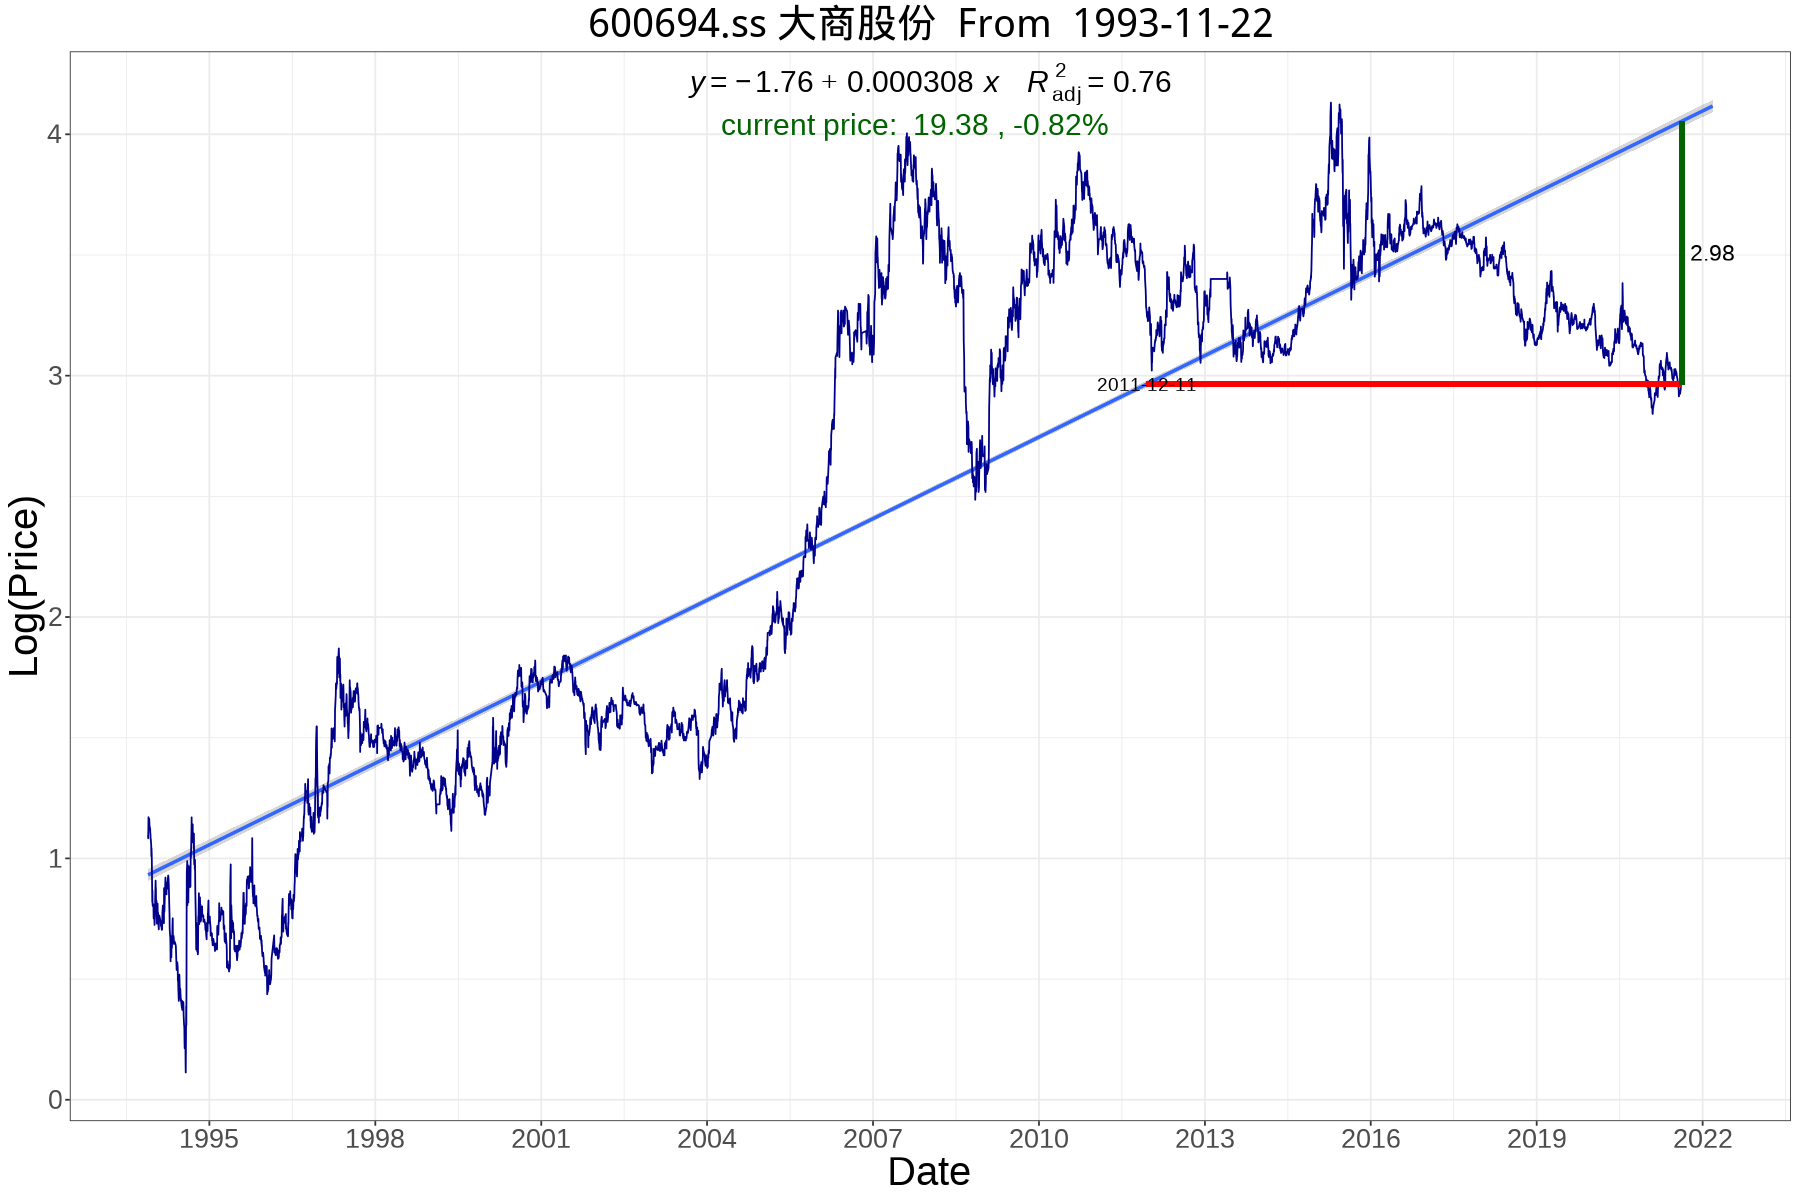

[1] 17.10137
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


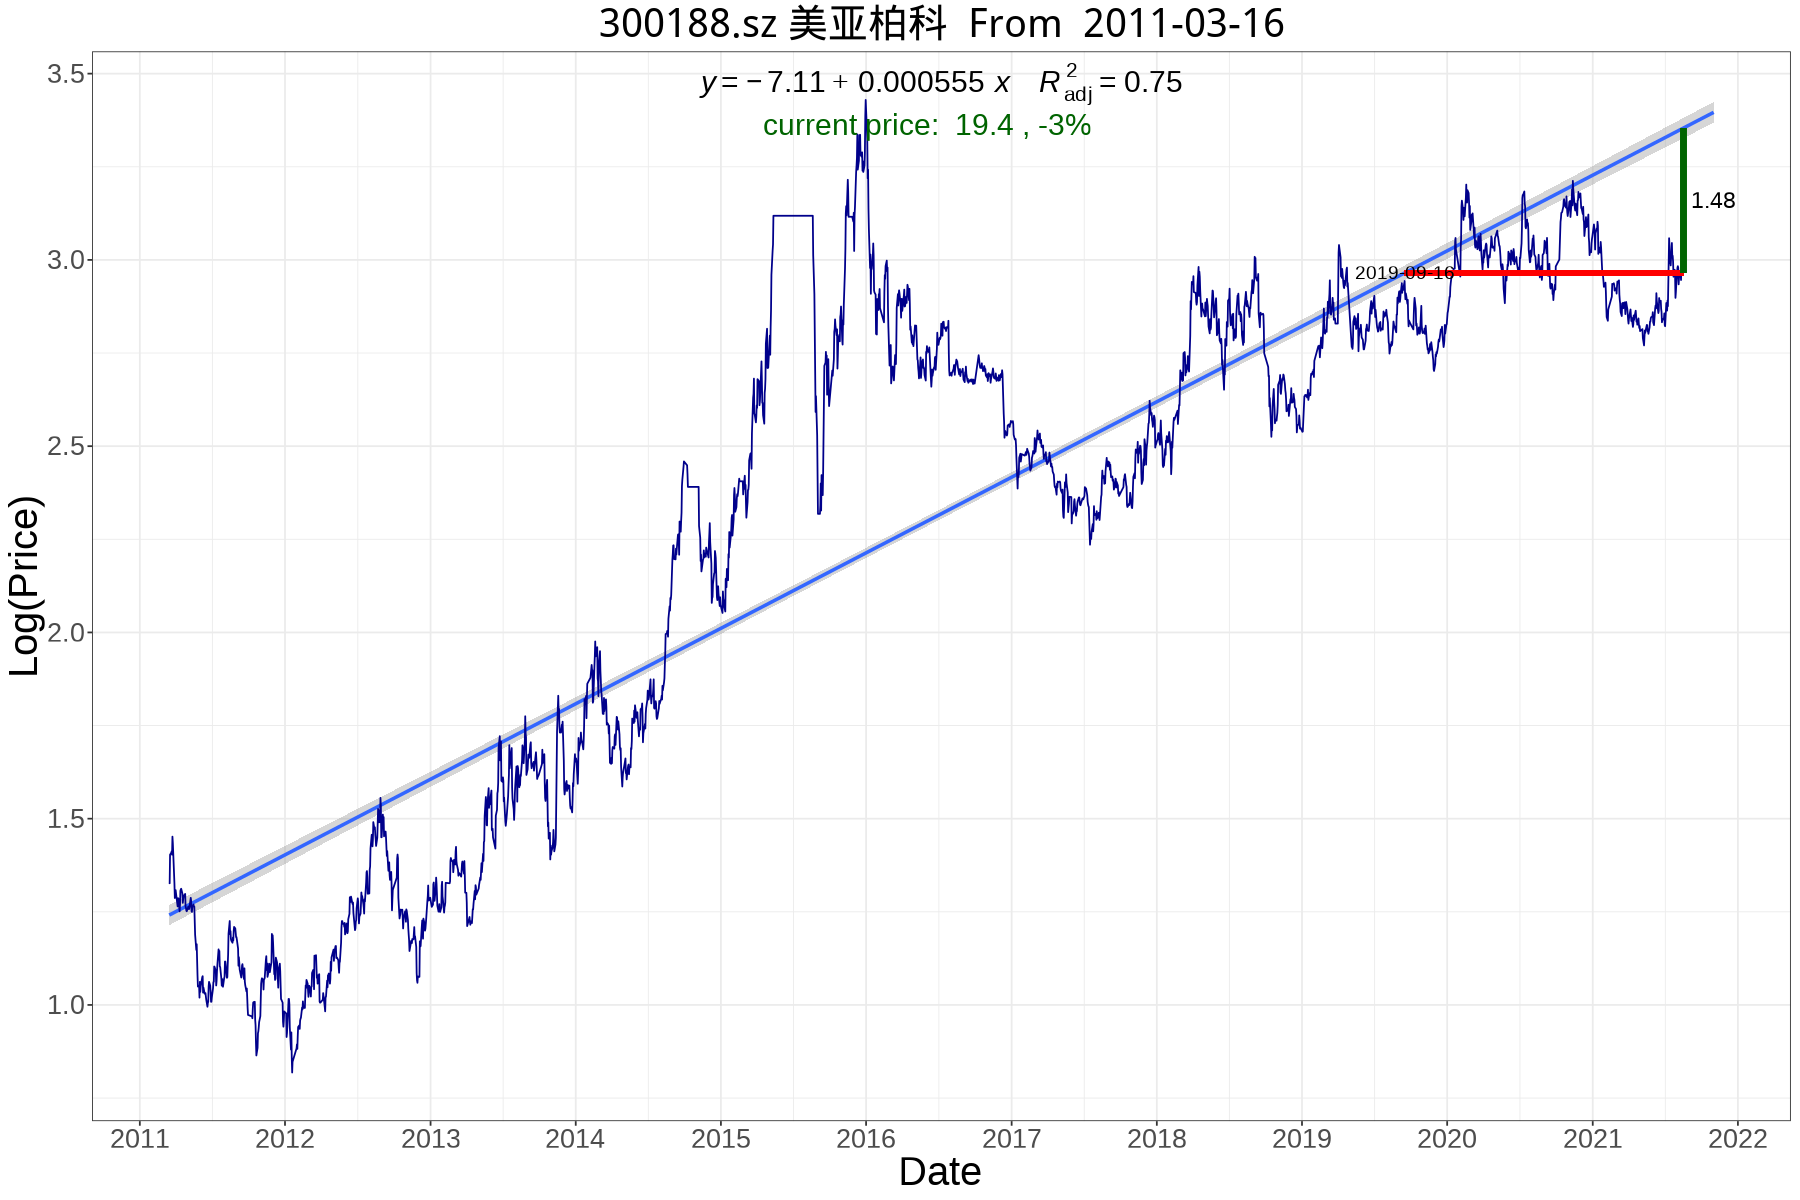

[1] 10.12055
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


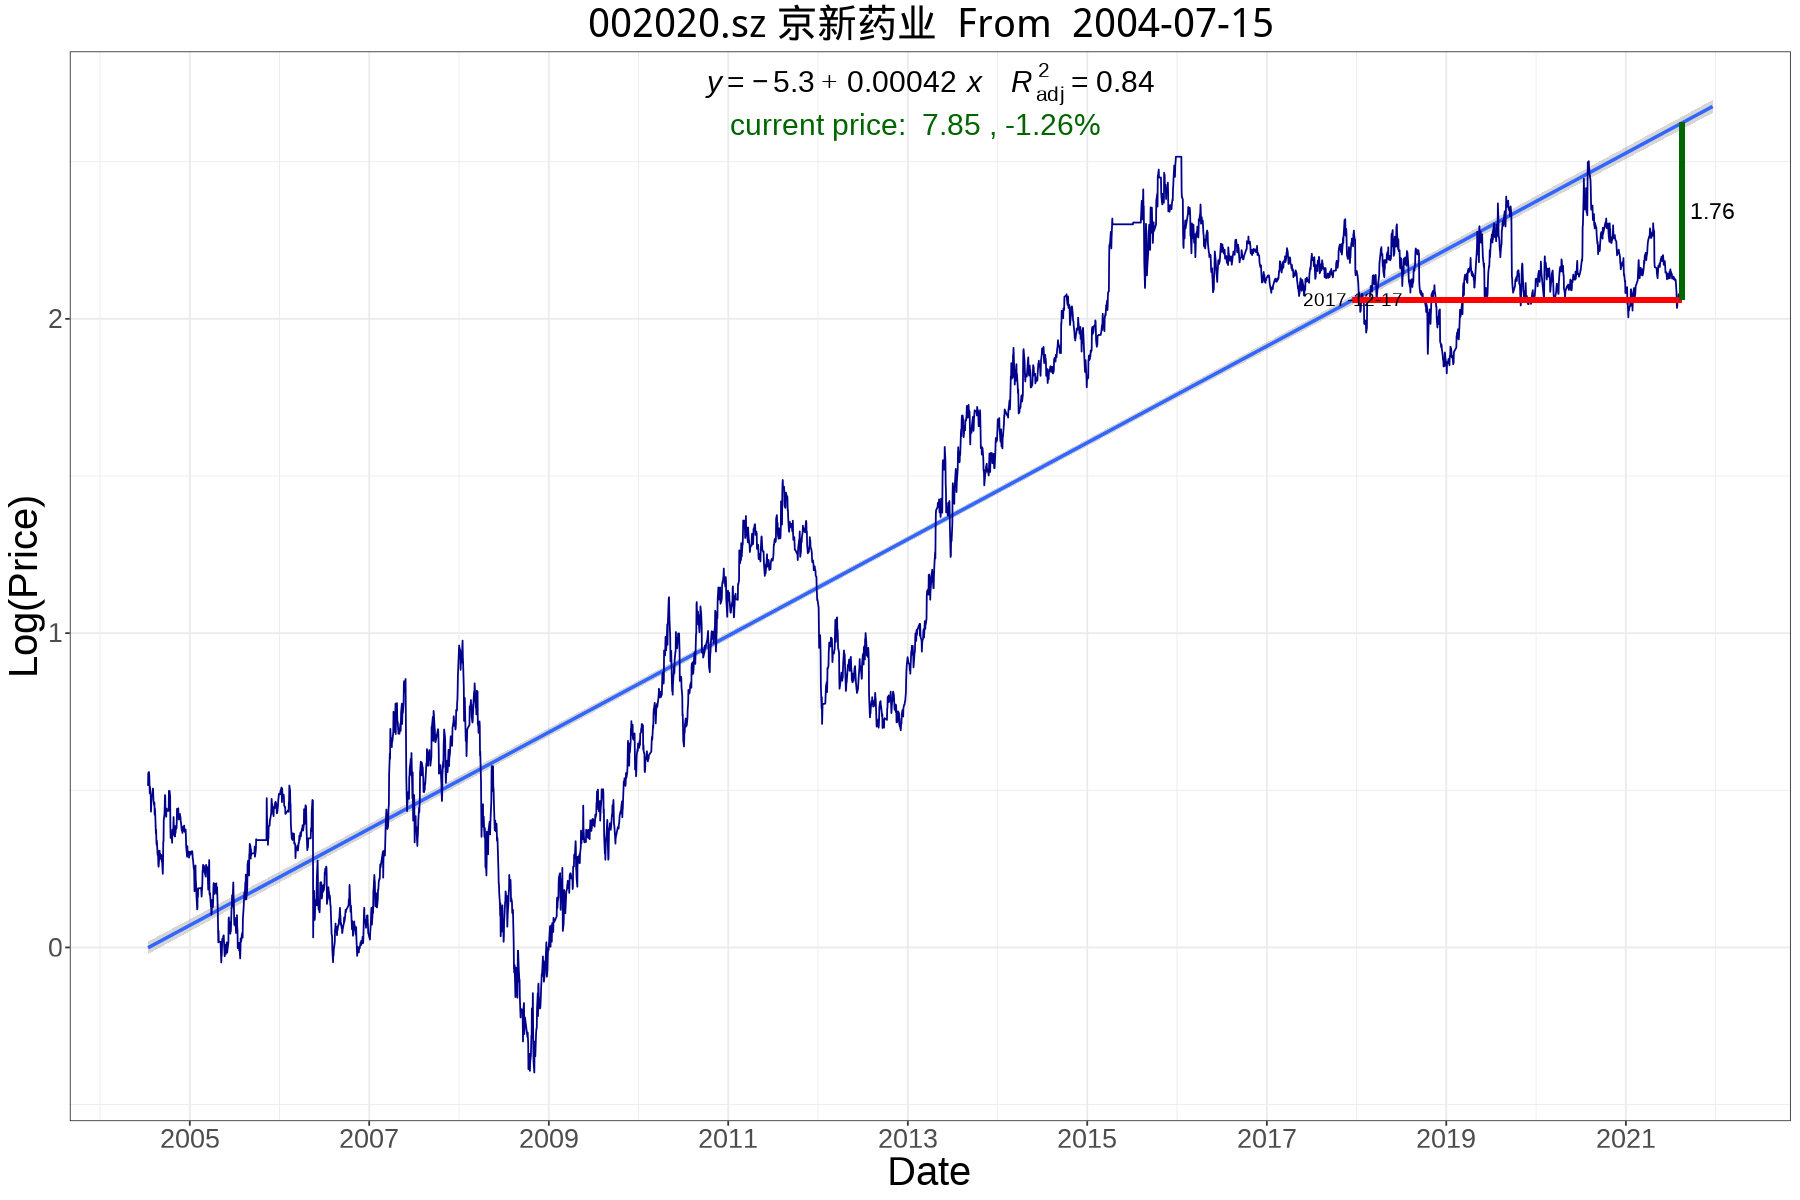

[1] 27.84932
[[1]]



r square lower than 0.75
r square lower than 0.75
r square lower than 0.75


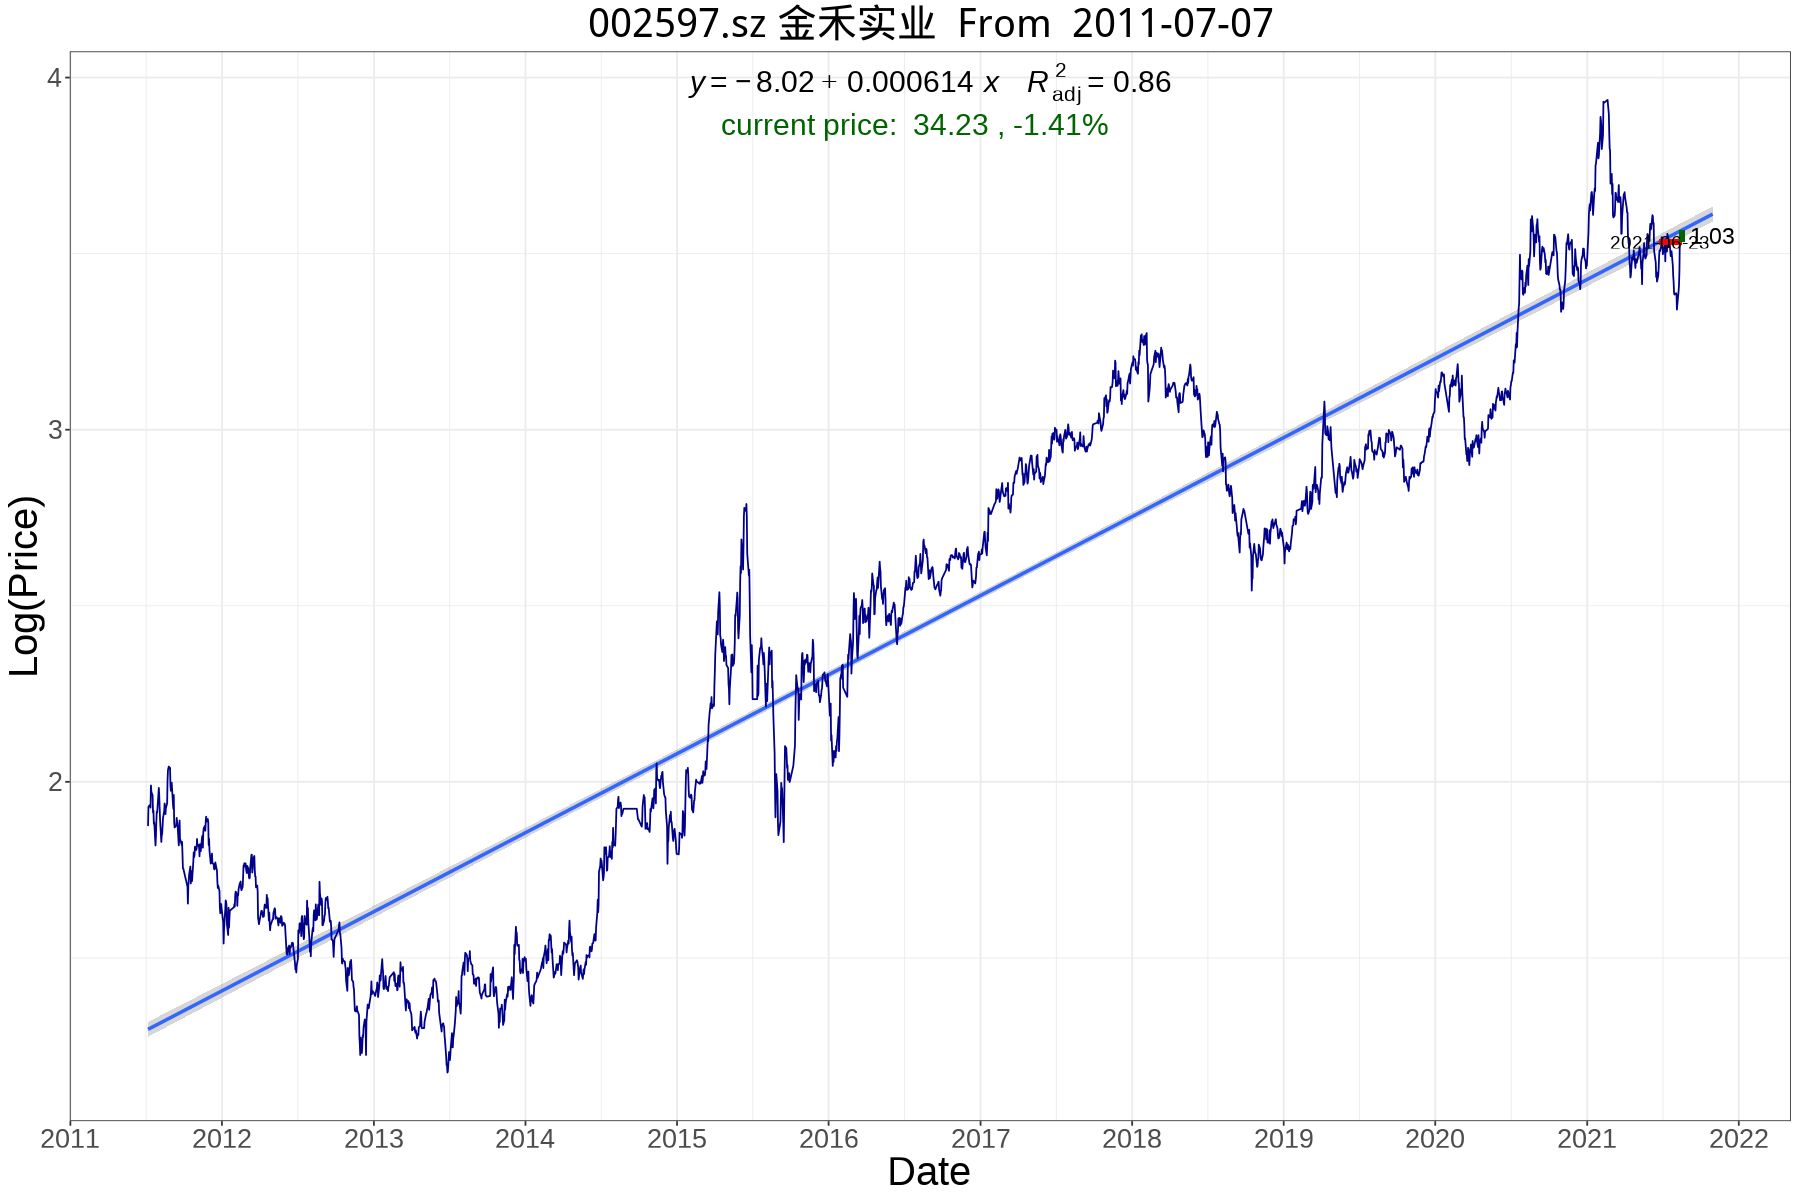

[1] 10.14247
[[1]]


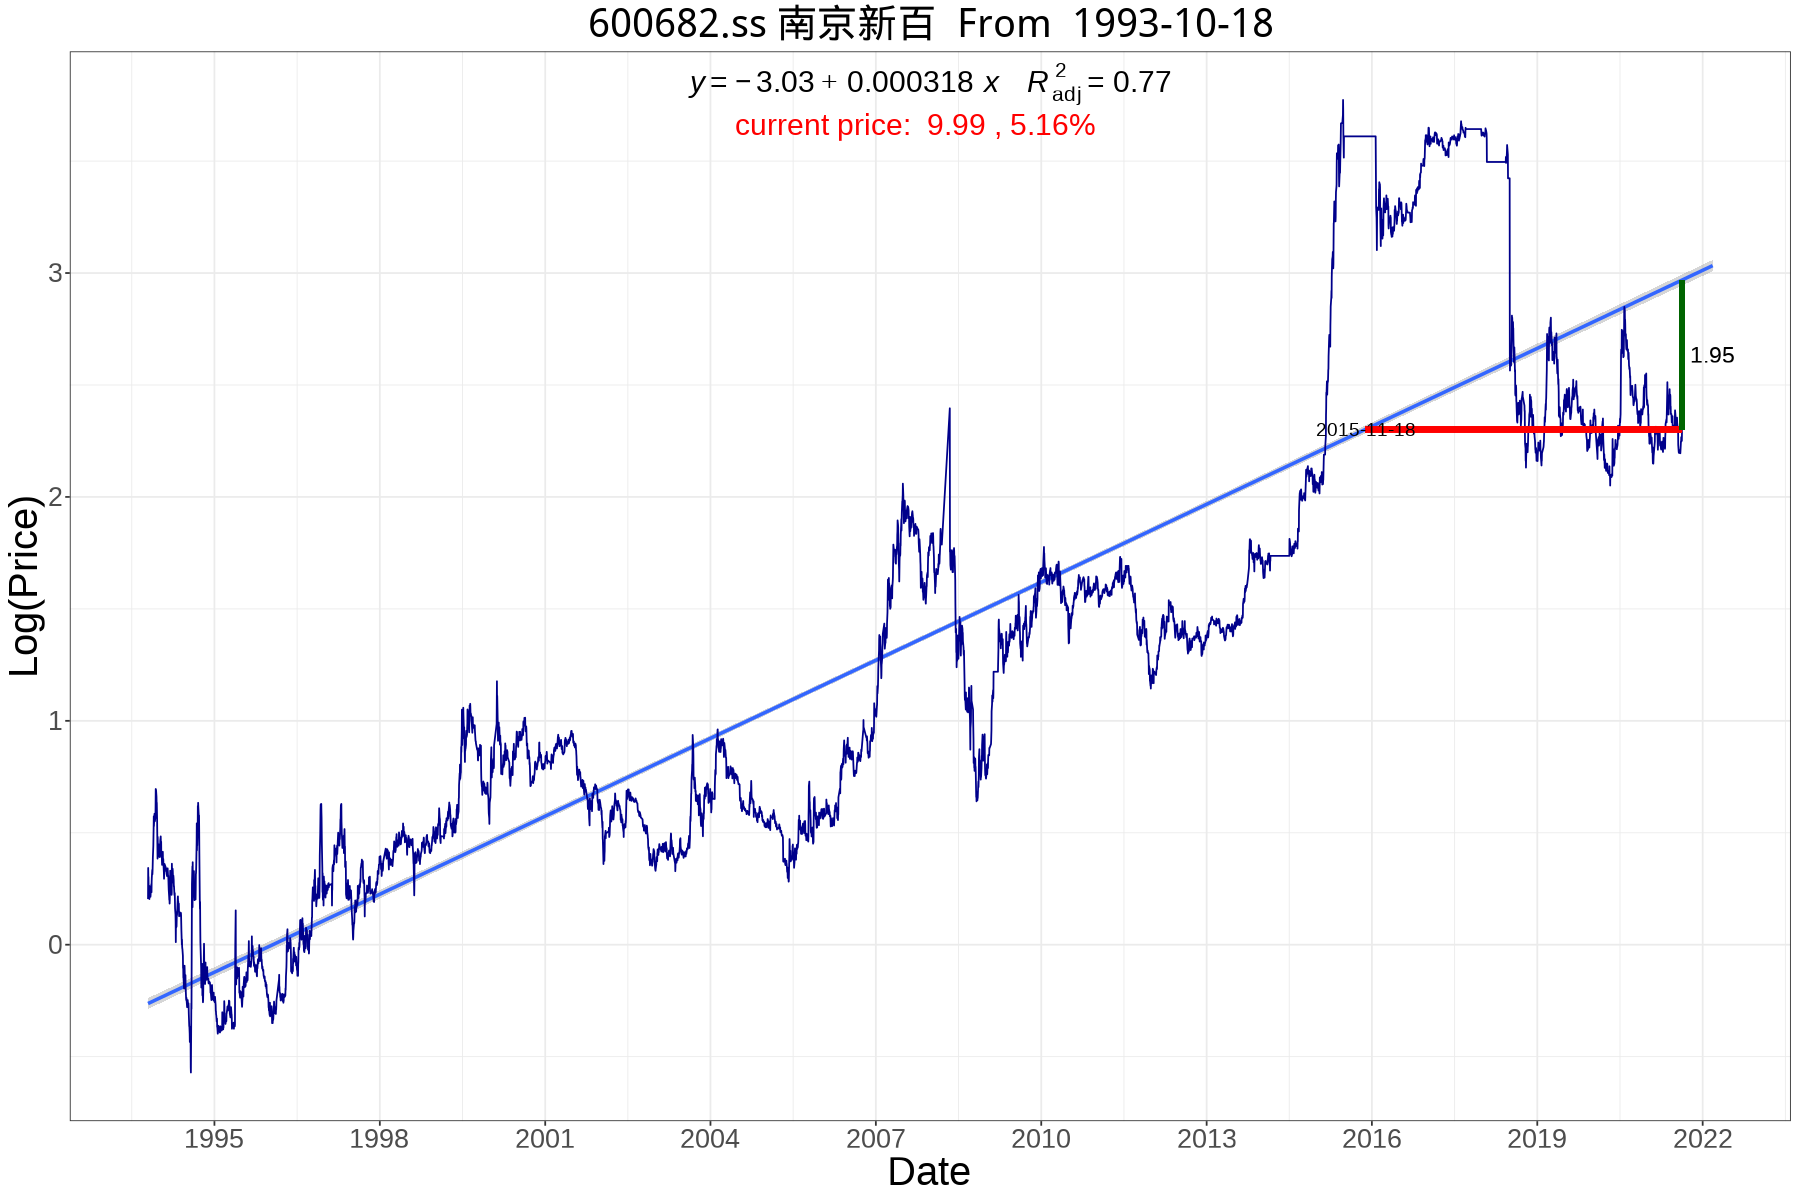

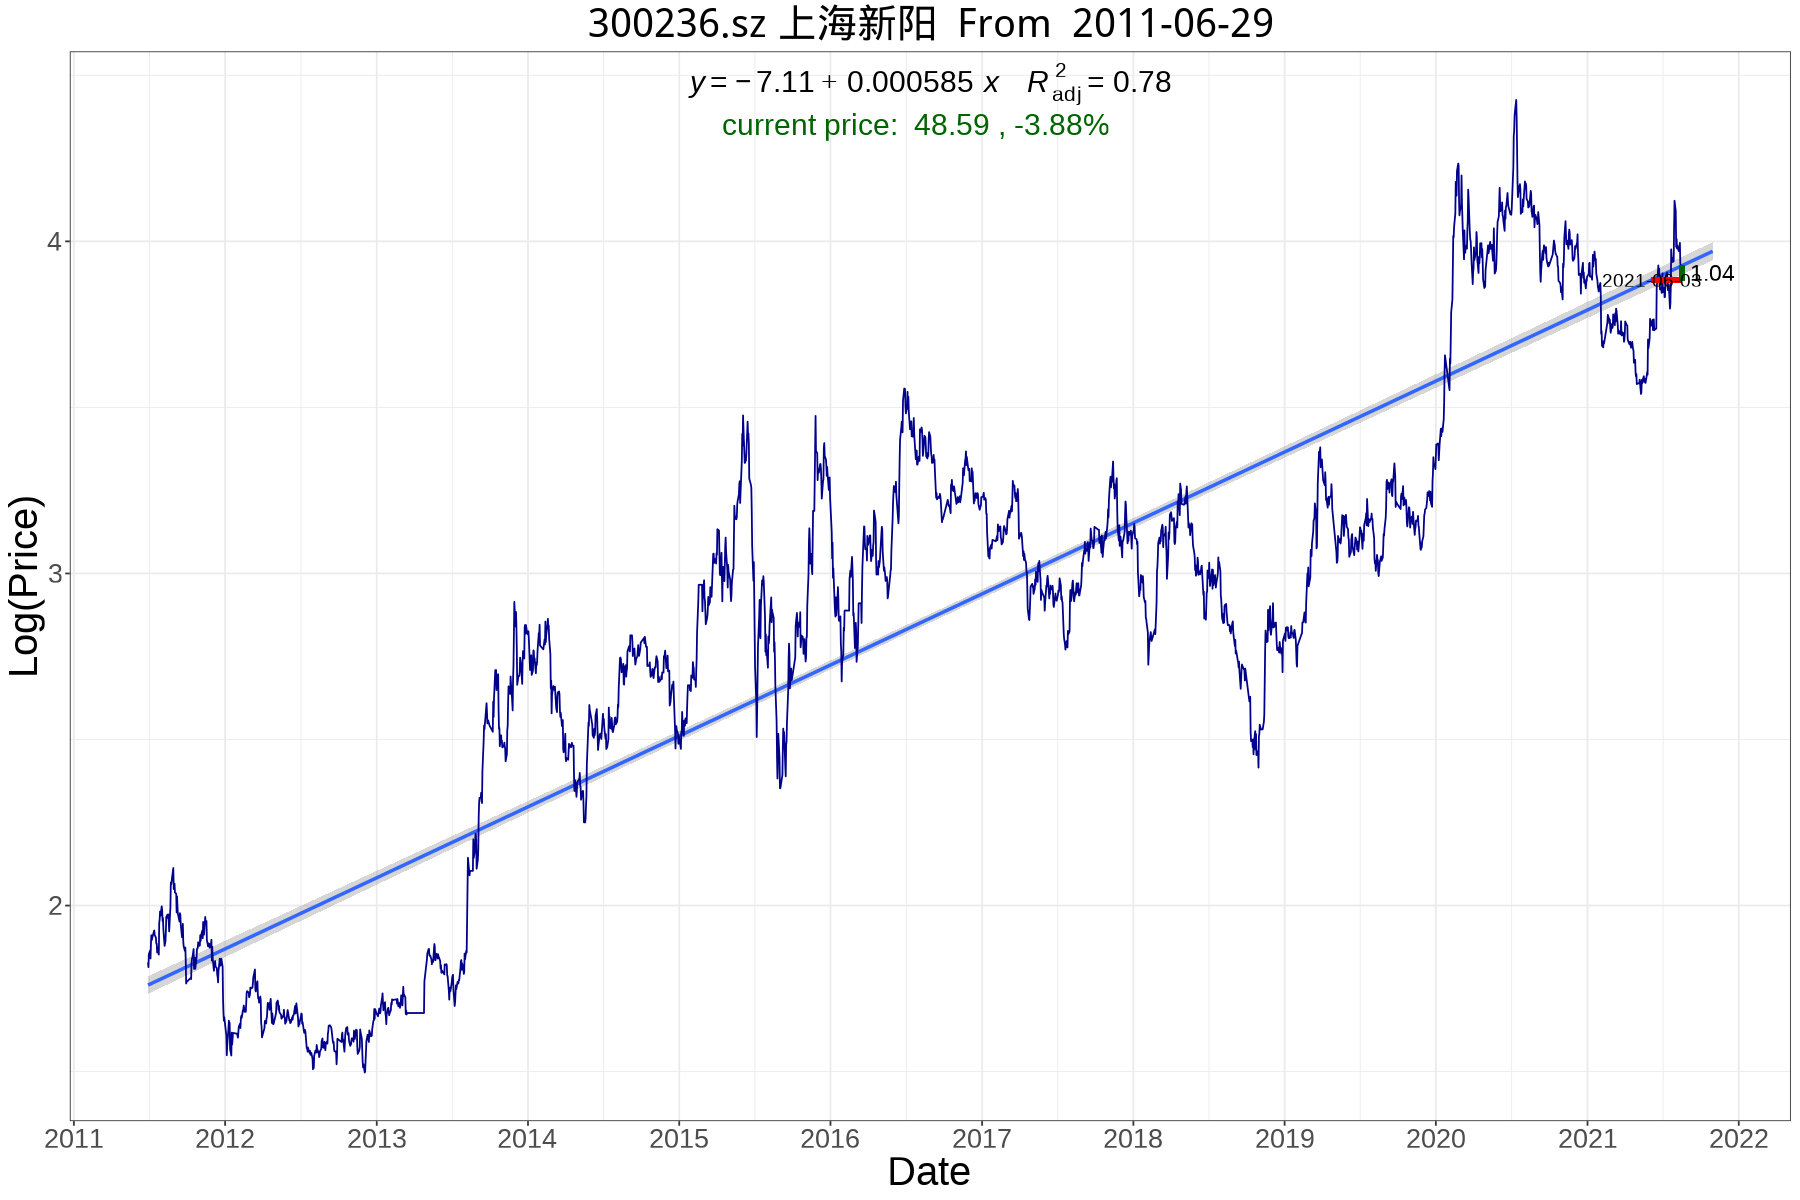

In [34]:
show(csi1000_lists,1,10,0.75)

In [ ]:
#csi300_url  = 'http://www.csindex.com.cn/uploads/file/autofile/cons/000300cons.xls'
#download.file(csi300_url, "csi300.xls")
csi300_lists = get_stock_list("csi300.xls",'xls')

In [ ]:
#沪深300很多成份股只不过是浪得虚名，很多股票被大基金操控，还不如中证500稳定
show(csi300_lists,1,10,0.75)

In [ ]:
cblists = get_stock_list("CB_list.csv",'cb')

In [ ]:
show(cblists,1,10,0)

In [ ]:
frlists = get_stock_list("CB_force_redeem_list.csv",'cb')
show(frlists,1,10,0)

In [ ]:
mylists = get_stock_list("mylist.csv","csv")

In [ ]:
show(mylists,1,5)

In [ ]:
plot('城发环境','000885.sz')

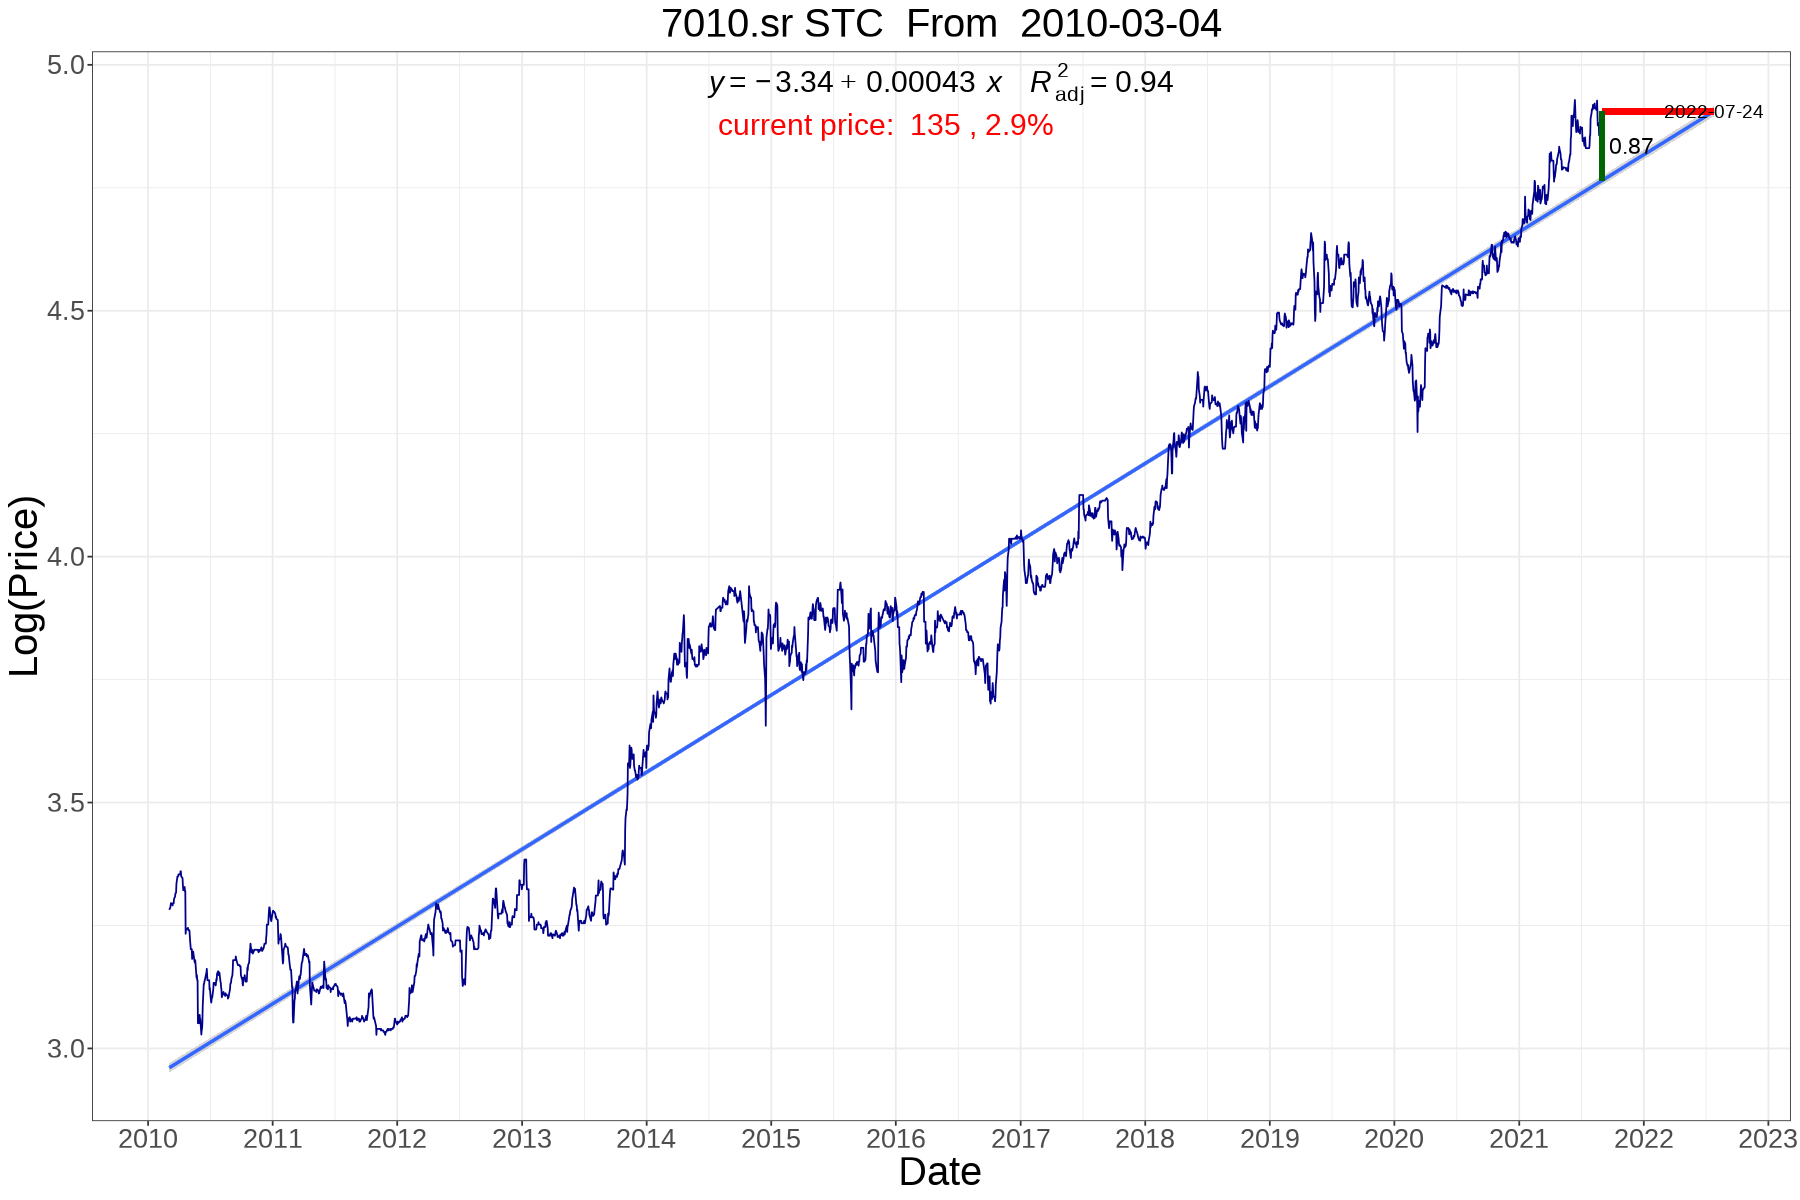

In [67]:
plot('STC','7010.sr',"Yes")

In [ ]:
plot('航天动力','600343.ss',"Yes")

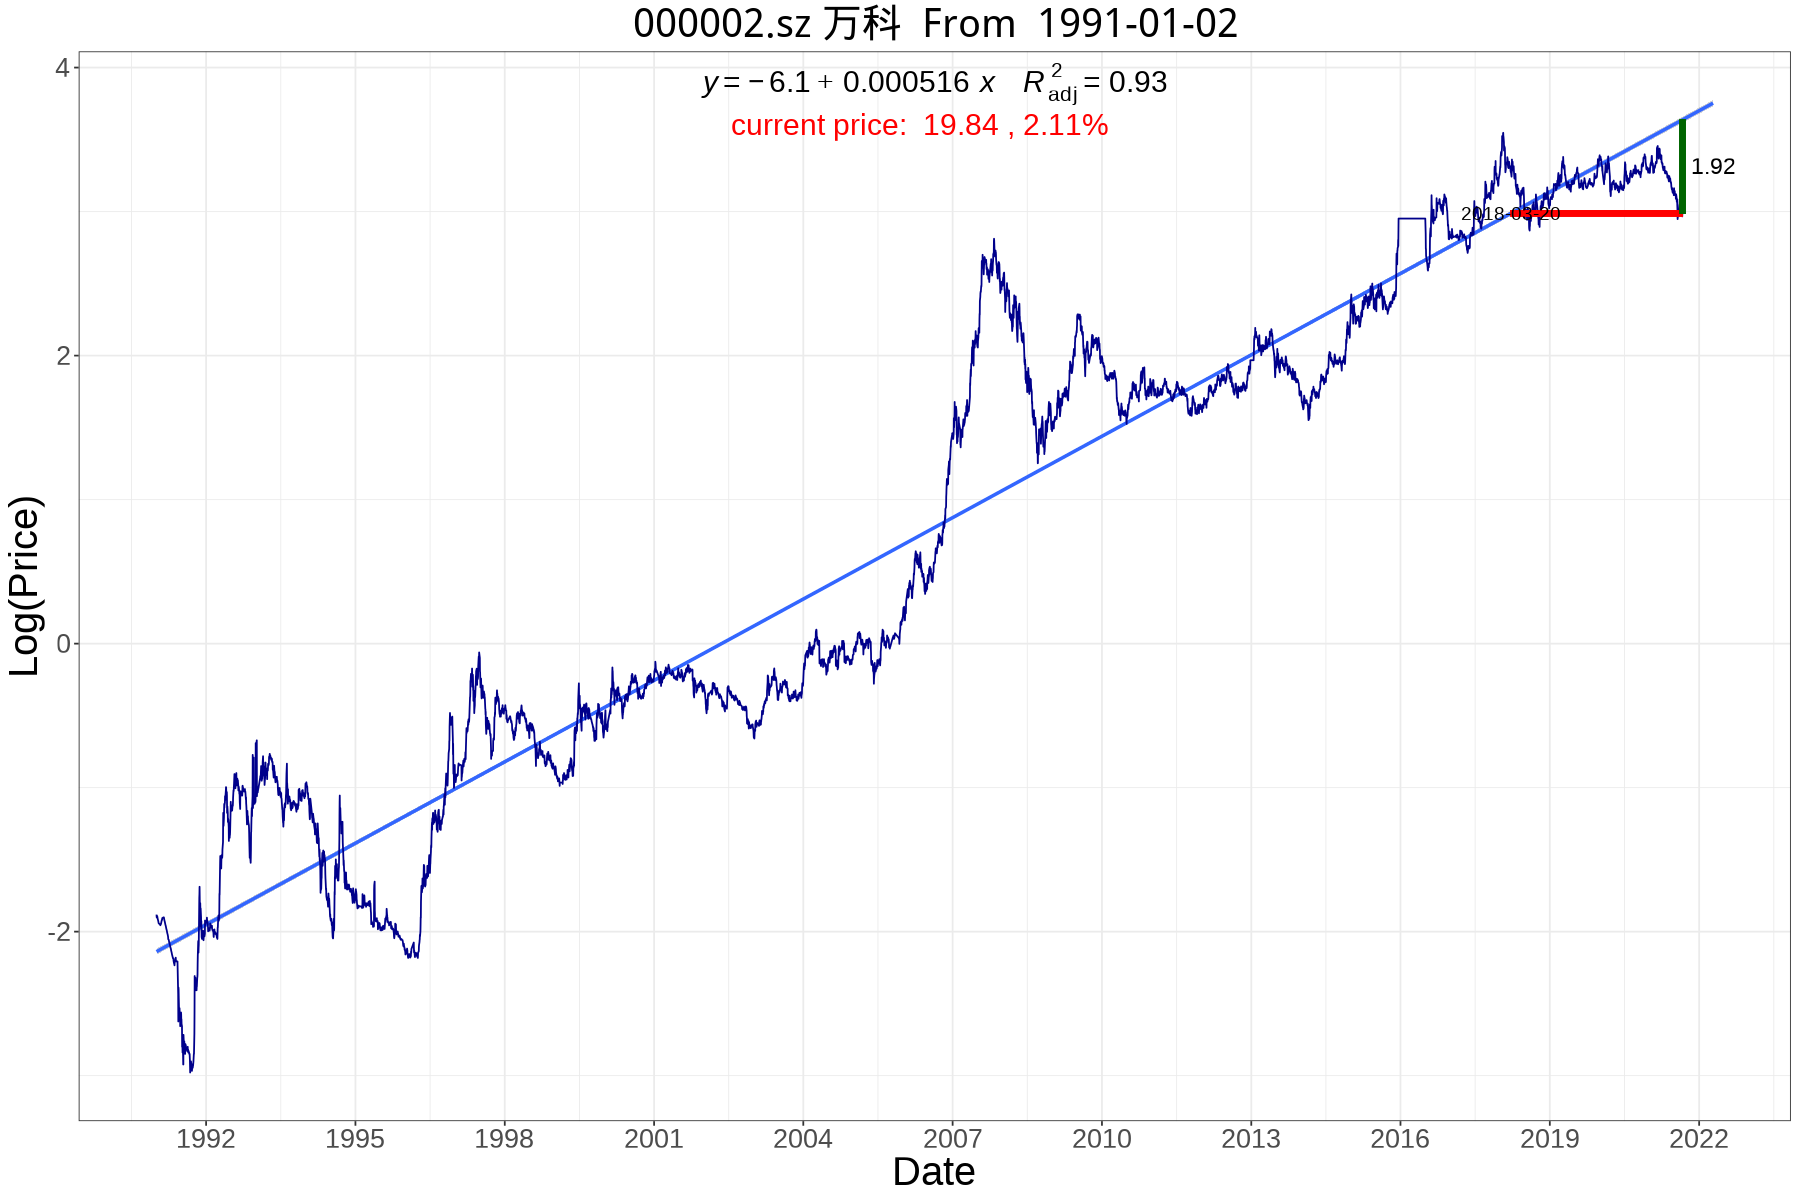

In [66]:
plot('万科','000002.sz','Yes','1900-01-01',Sys.Date(),Interval=NA)

In [61]:
Stock  = suppressWarnings(getSymbols(
                    '000002.sz', src = "yahoo",from = '1991-01-02', 
                    '2020-12-14', auto.assign = FALSE))

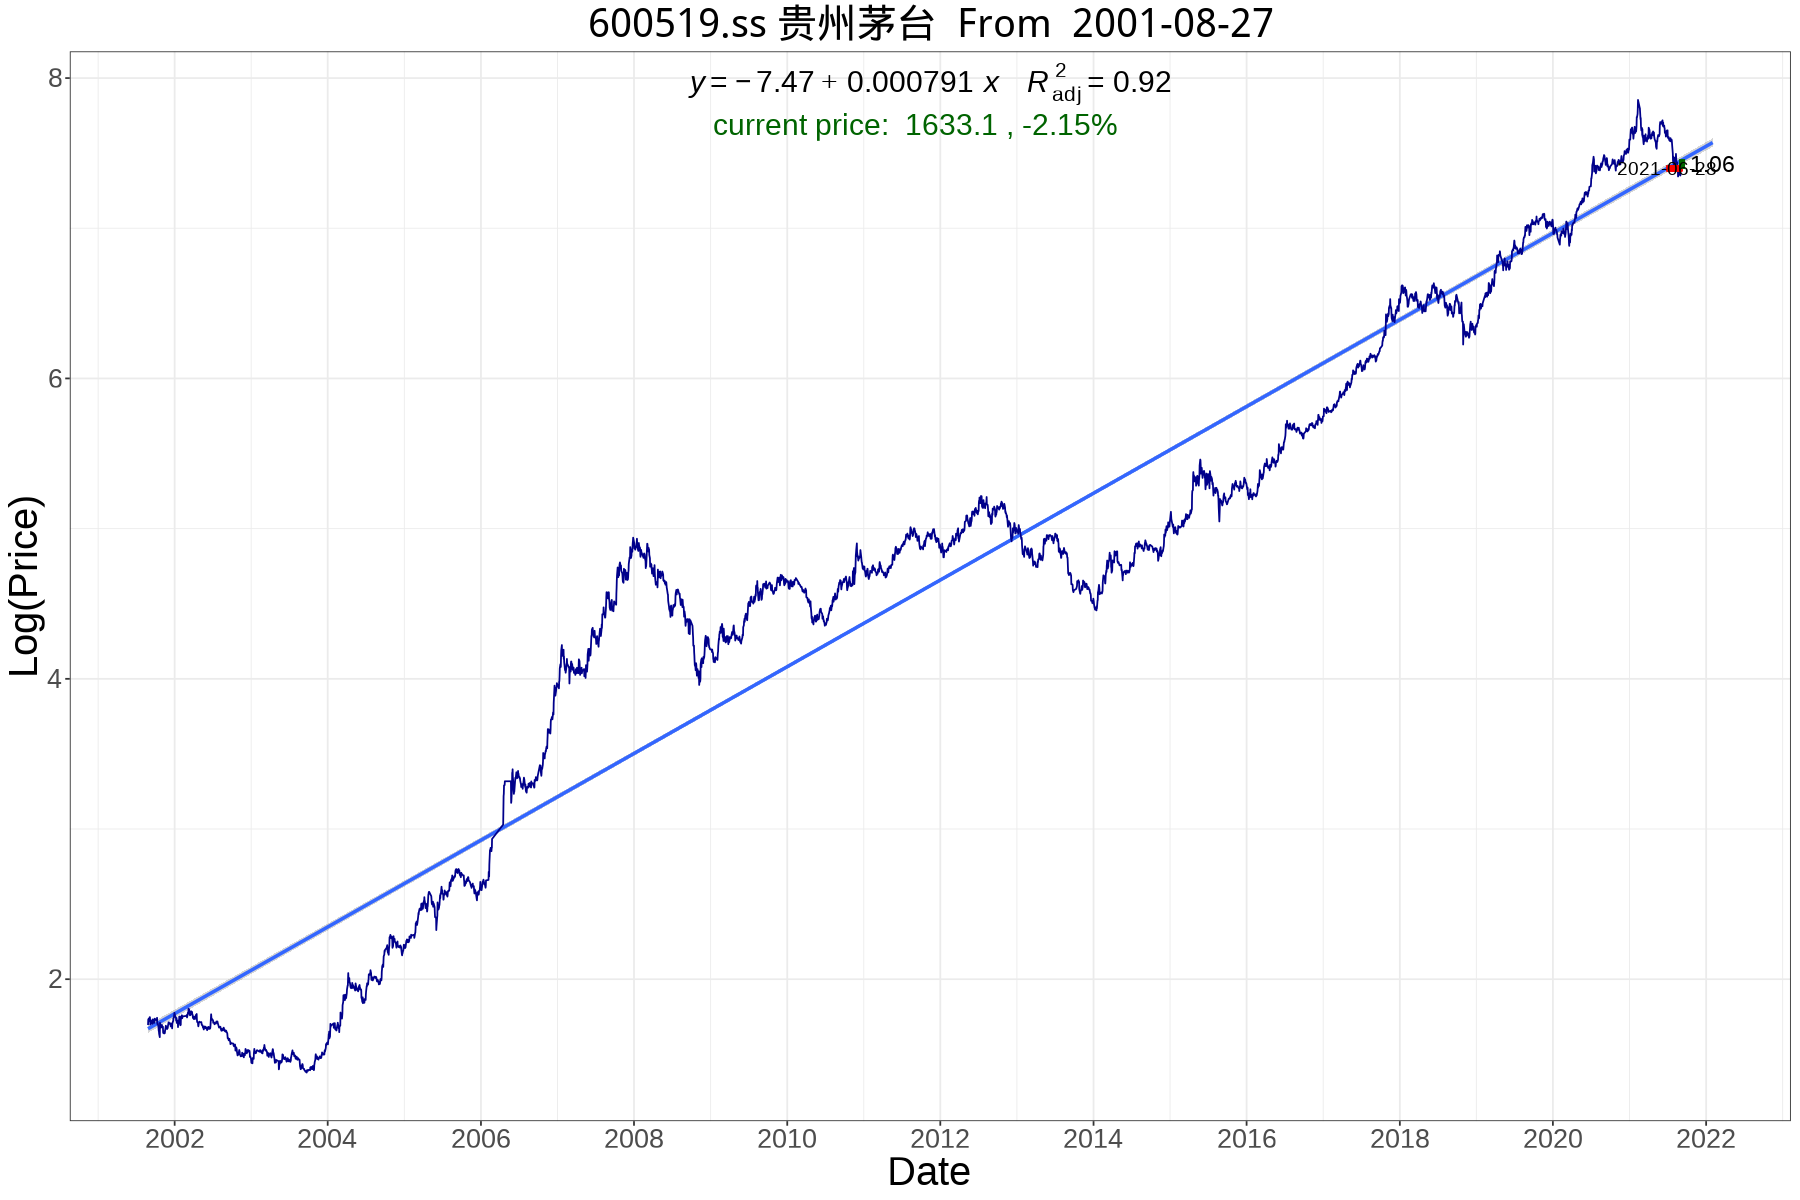

In [15]:
plot('贵州茅台','600519.ss',"Yes")

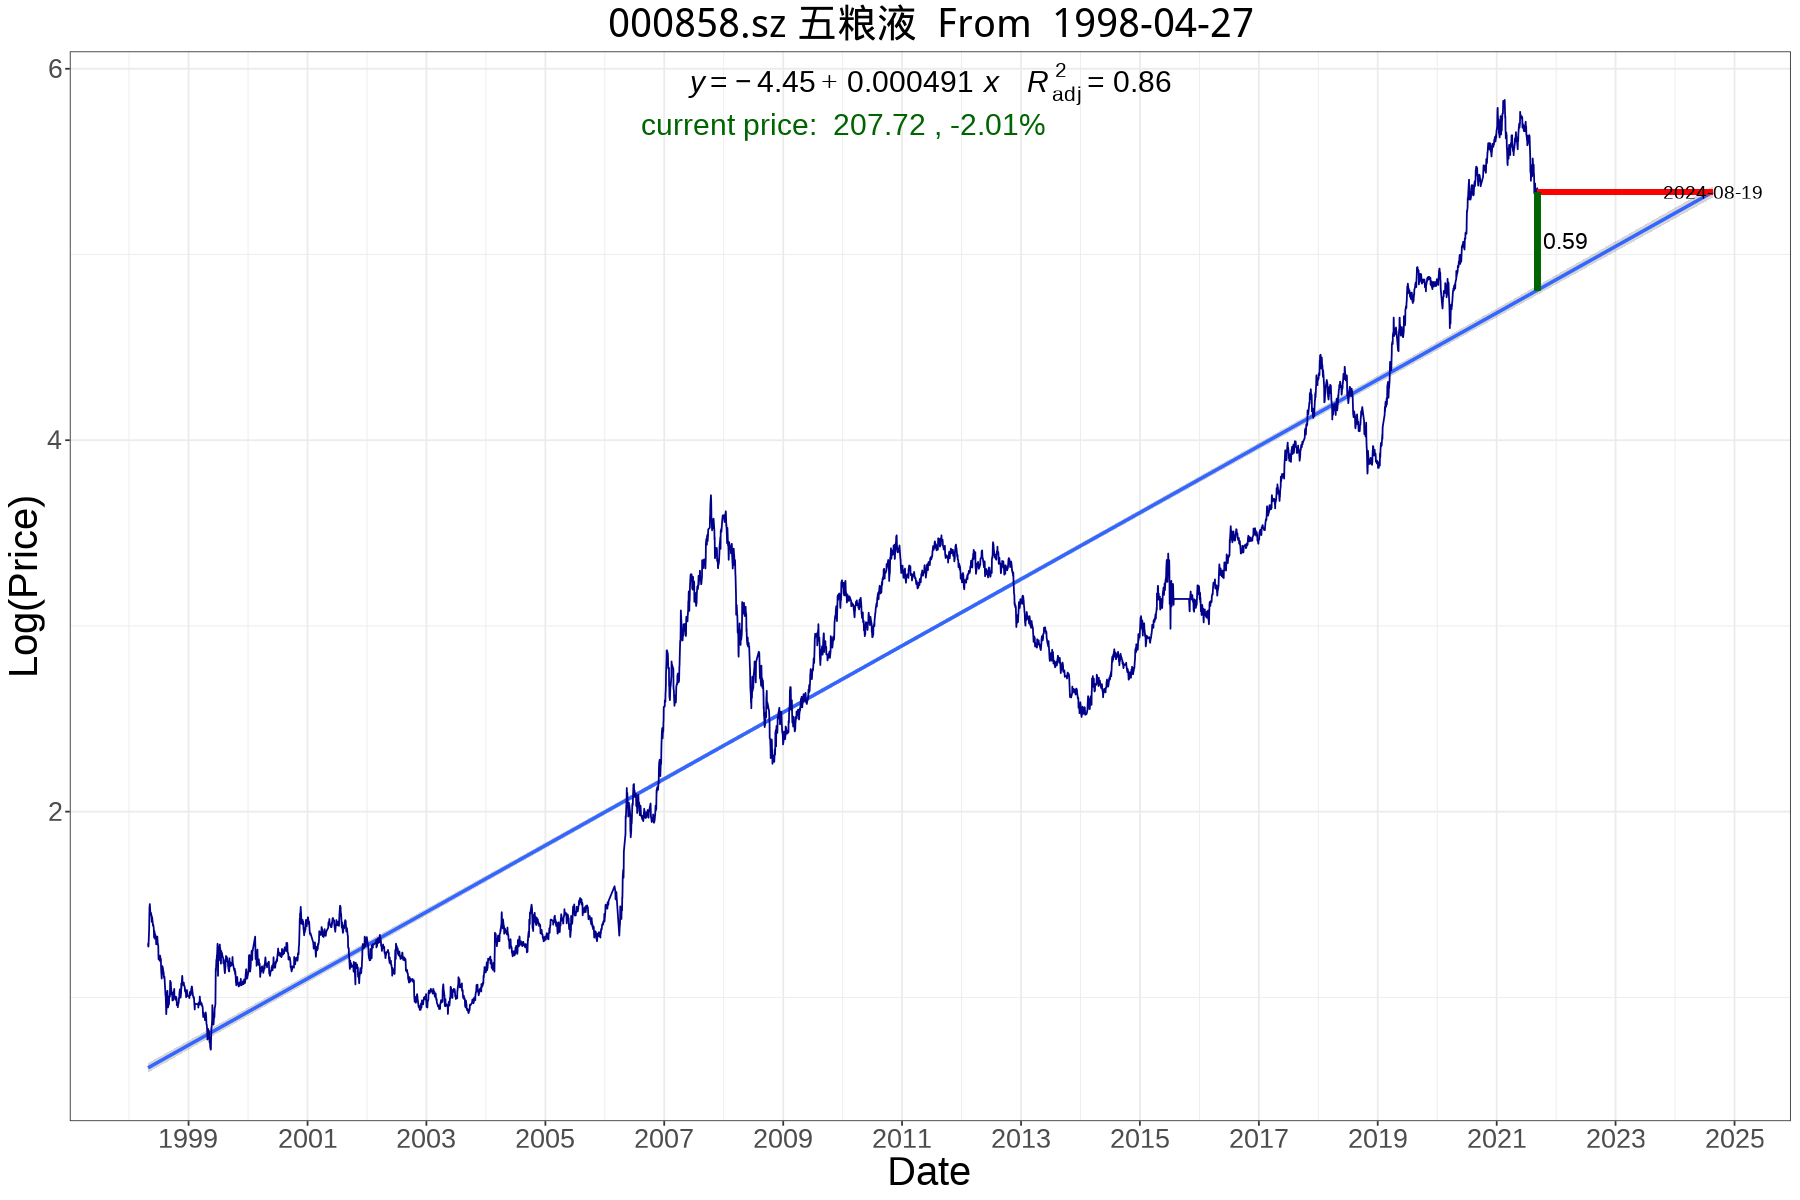

In [16]:
plot('五粮液','000858.sz',"Yes")

In [69]:
plot('中证白酒','399997.sz',"Yes")

error occur, could not find stock 399997.sz 中证白酒
1900-01-01
2021-09-01


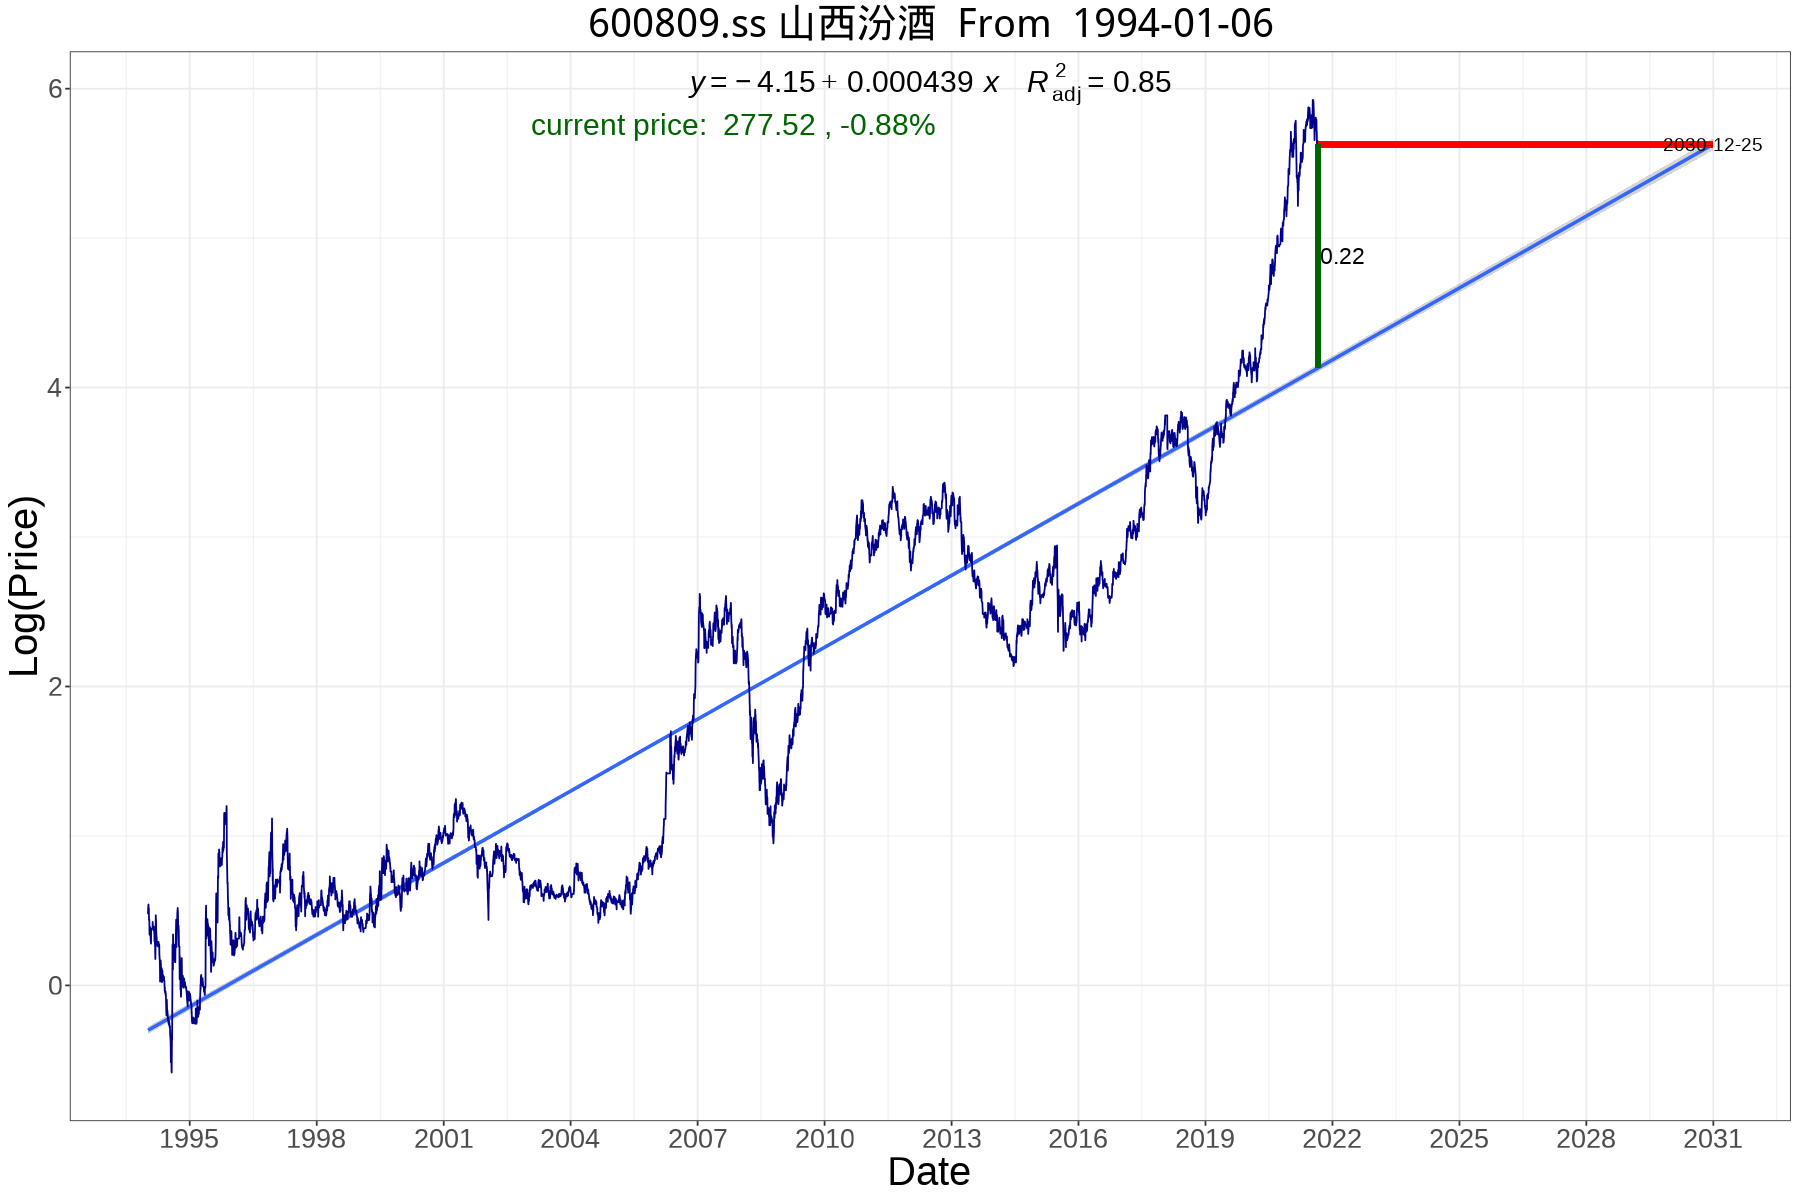

In [42]:
plot('山西汾酒','600809.ss',"Yes")

In [ ]:
plot('双汇发展','000895.sz',"Yes")

In [ ]:
plot('恒瑞医药','600276.ss',"Yes")

In [ ]:
plot('华兰生物','002007.sz',"Yes")

In [ ]:
plot('中国平安','601318.ss',"Yes")

In [ ]:
plot('华自科技','300490.sz')

In [ ]:
plot('凯撒旅业','000796.sz',"Yes")

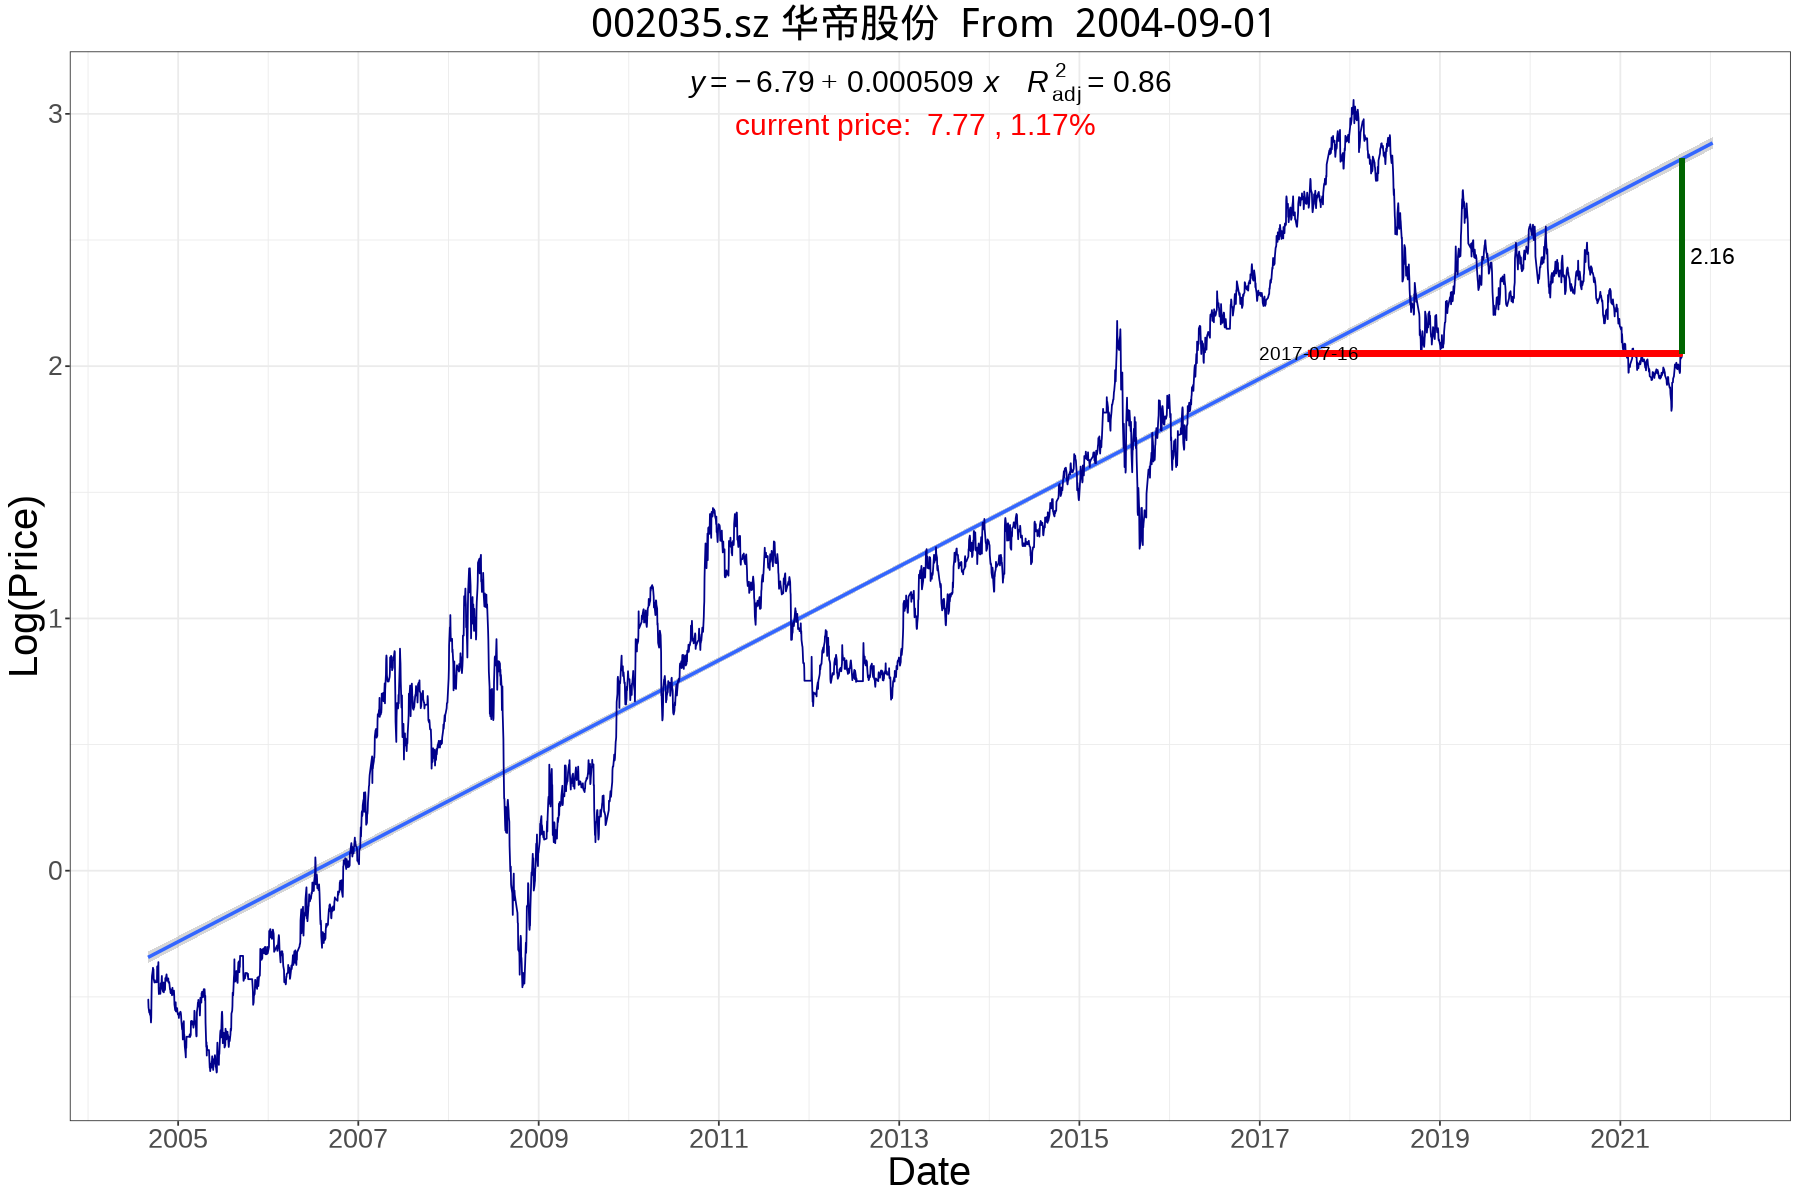

In [20]:
plot('华帝股份','002035.sz',"Yes")

In [ ]:
plot('华东医药','000963.sz',"Yes")

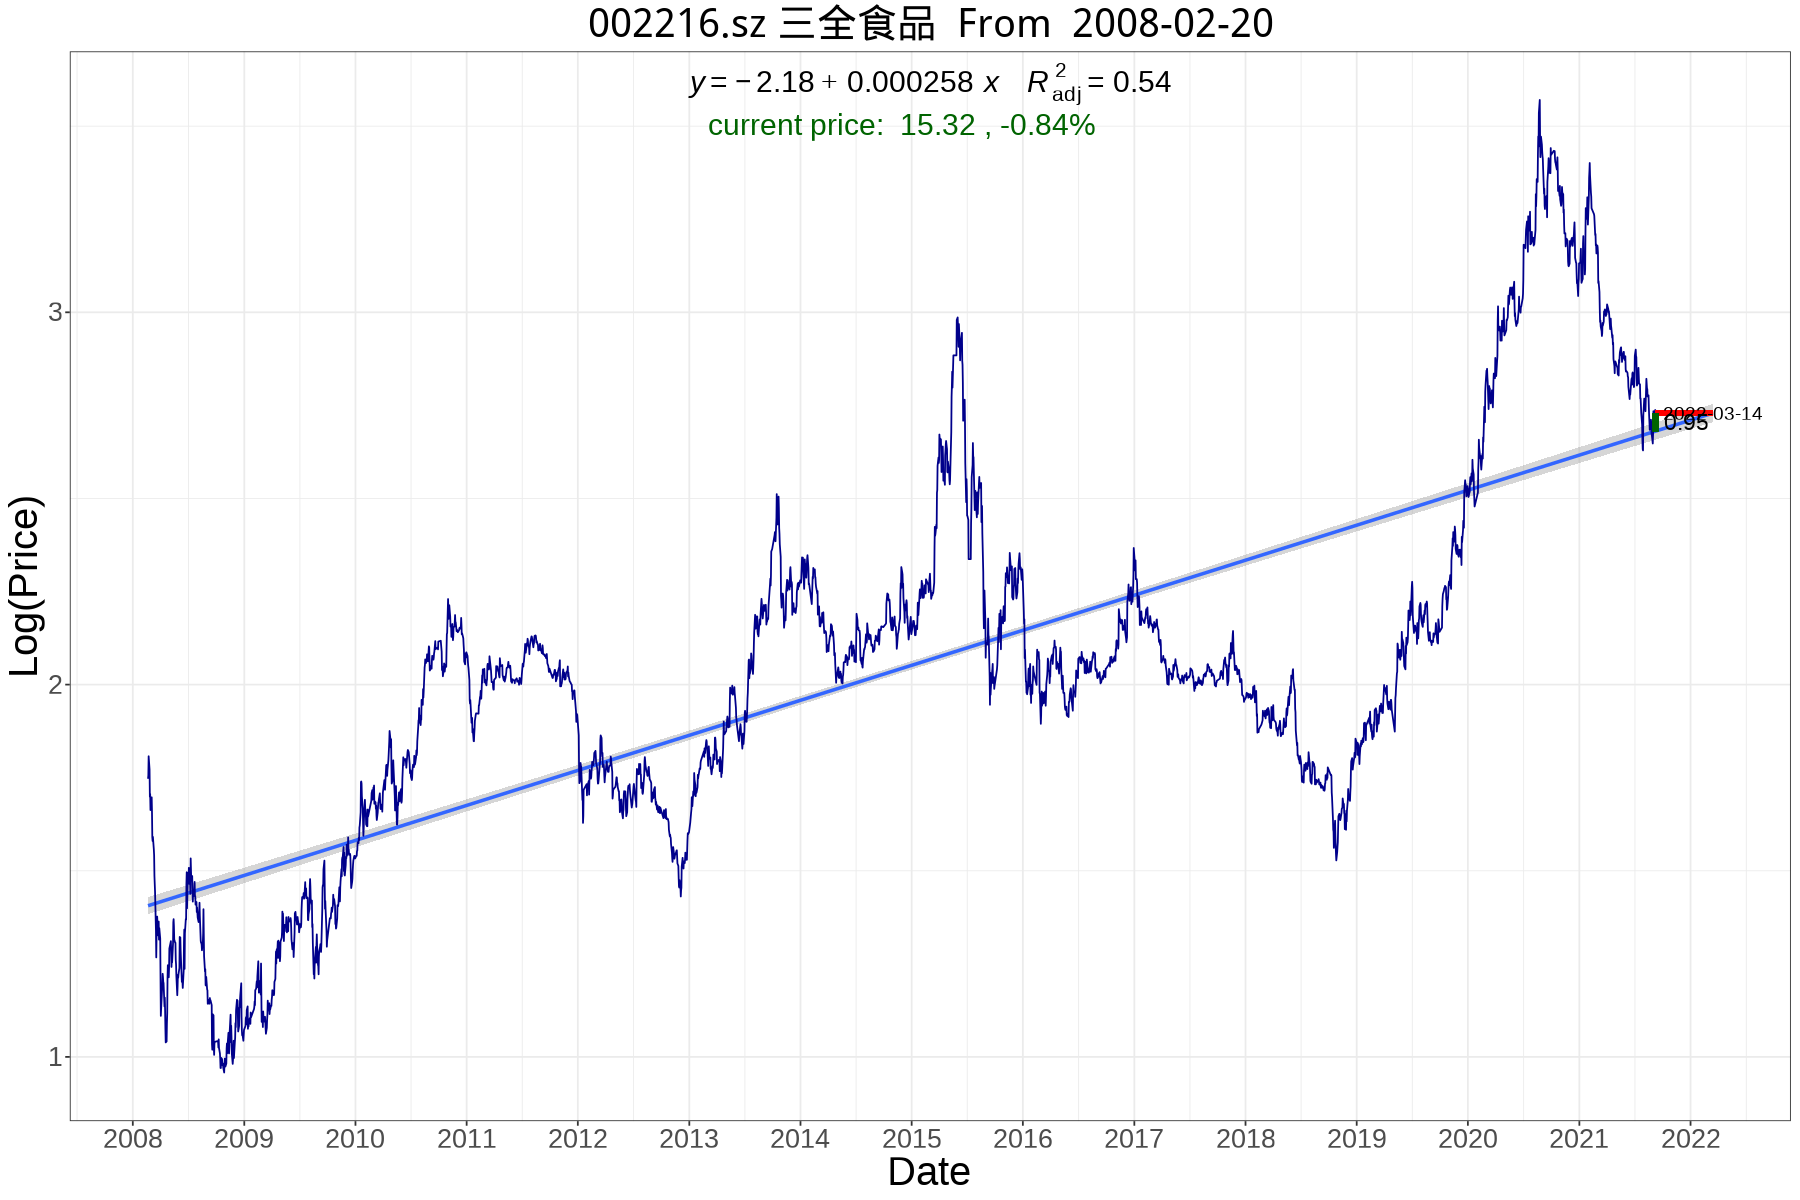

In [17]:
plot('三全食品','002216.sz',"Yes")

In [ ]:
plot('山东药玻','600529.ss',"Yes")

In [ ]:
plot('安图生物','603658.ss',"Yes")

In [ ]:
plot('药明康德','603259.ss',"Yes")

In [ ]:
plot('三一重工','600031.ss',"Yes")

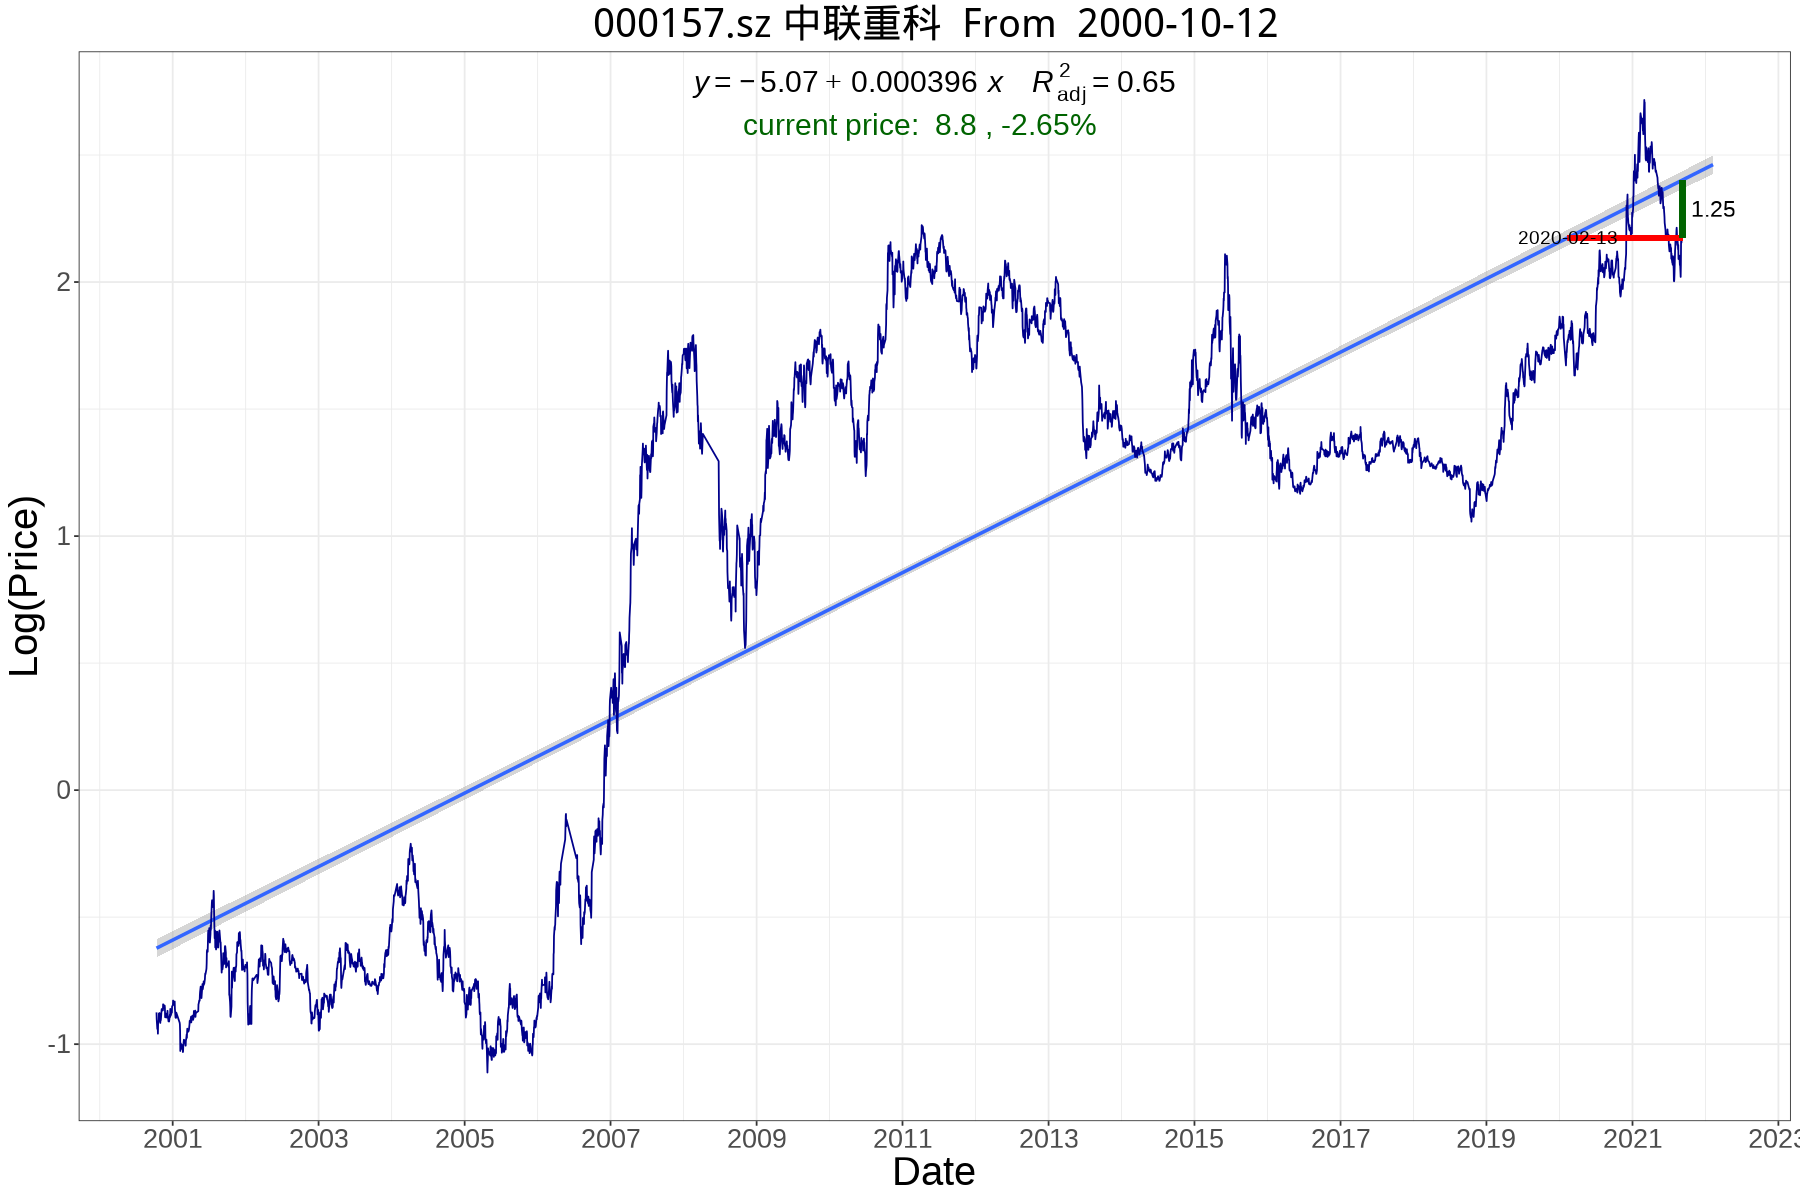

In [18]:
plot('中联重科','000157.sz',"Yes")

In [ ]:
plot('潍柴动力','000338.sz',"Yes")

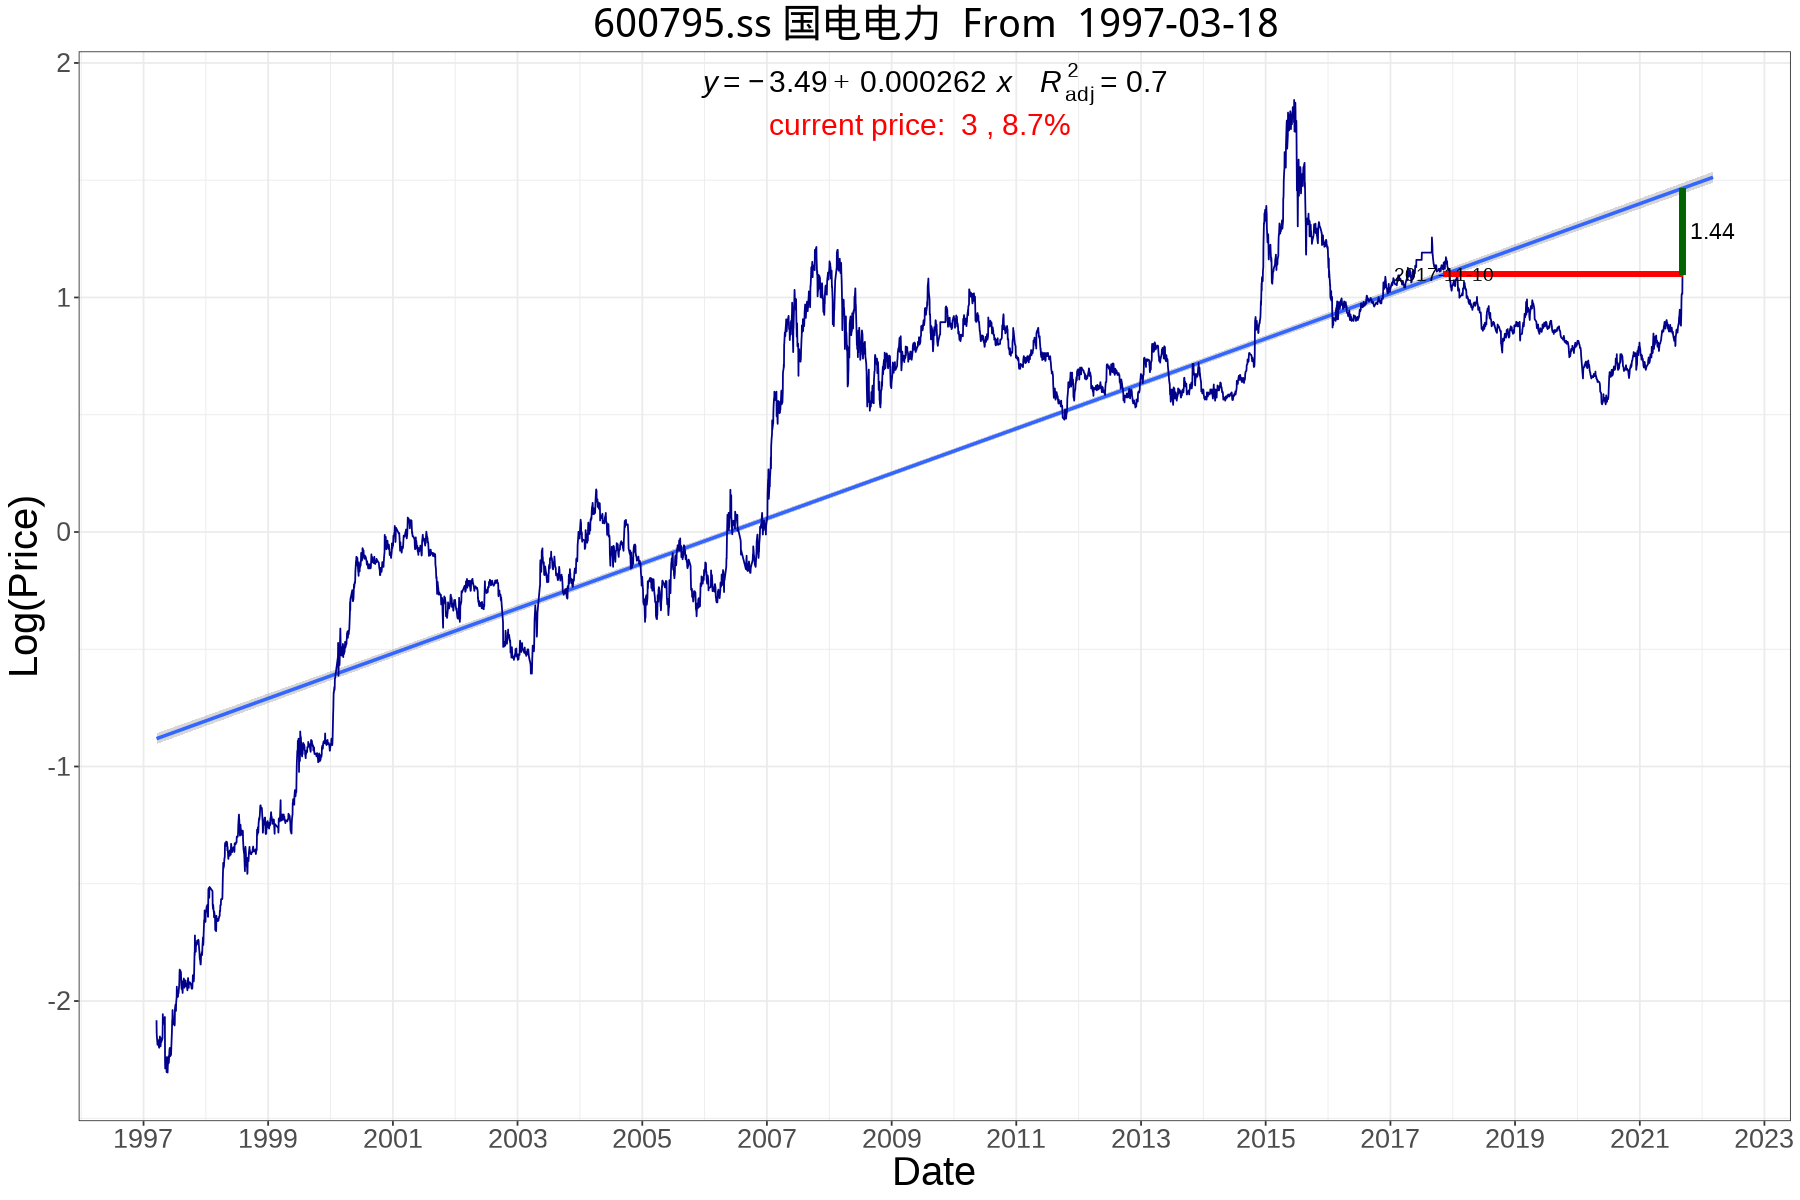

In [21]:
plot('国电电力','600795.ss',"Yes")

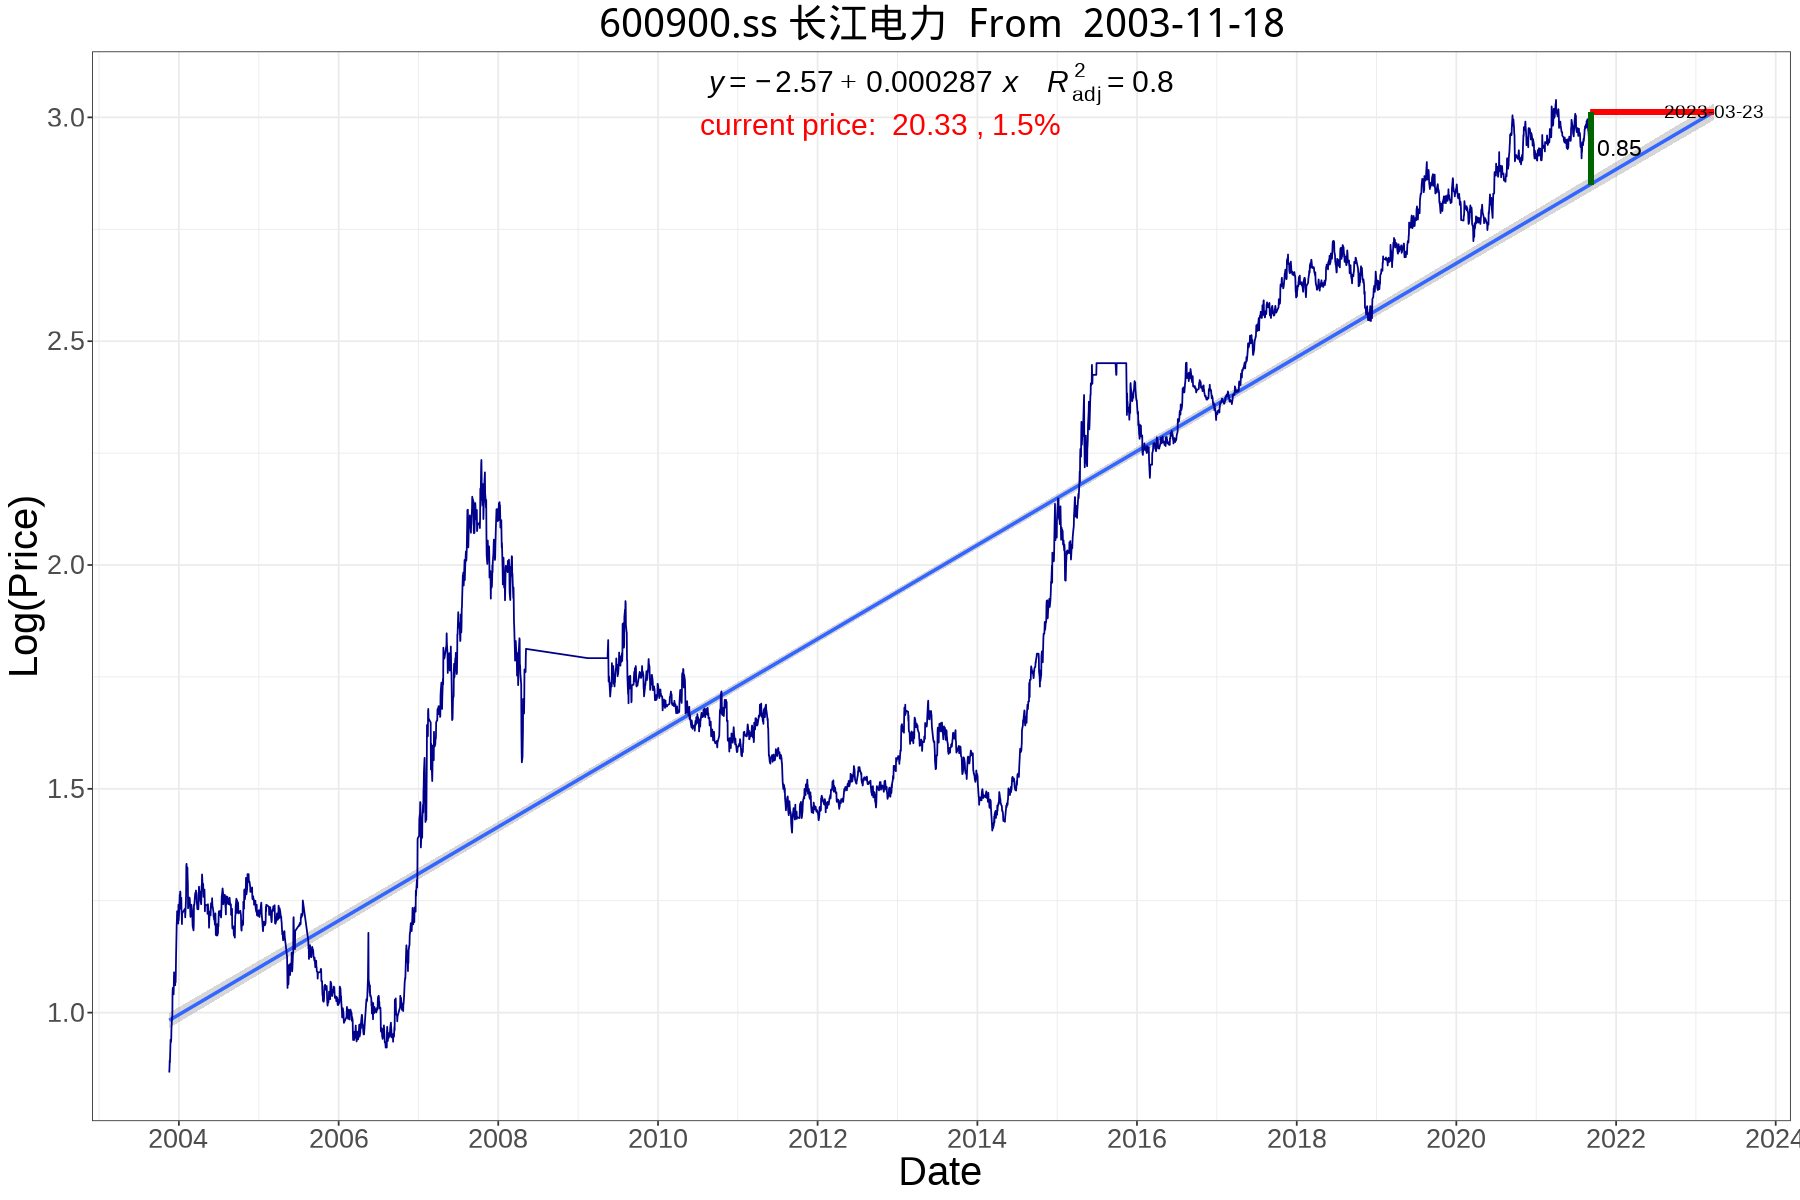

In [19]:
plot('长江电力','600900.ss',"Yes")

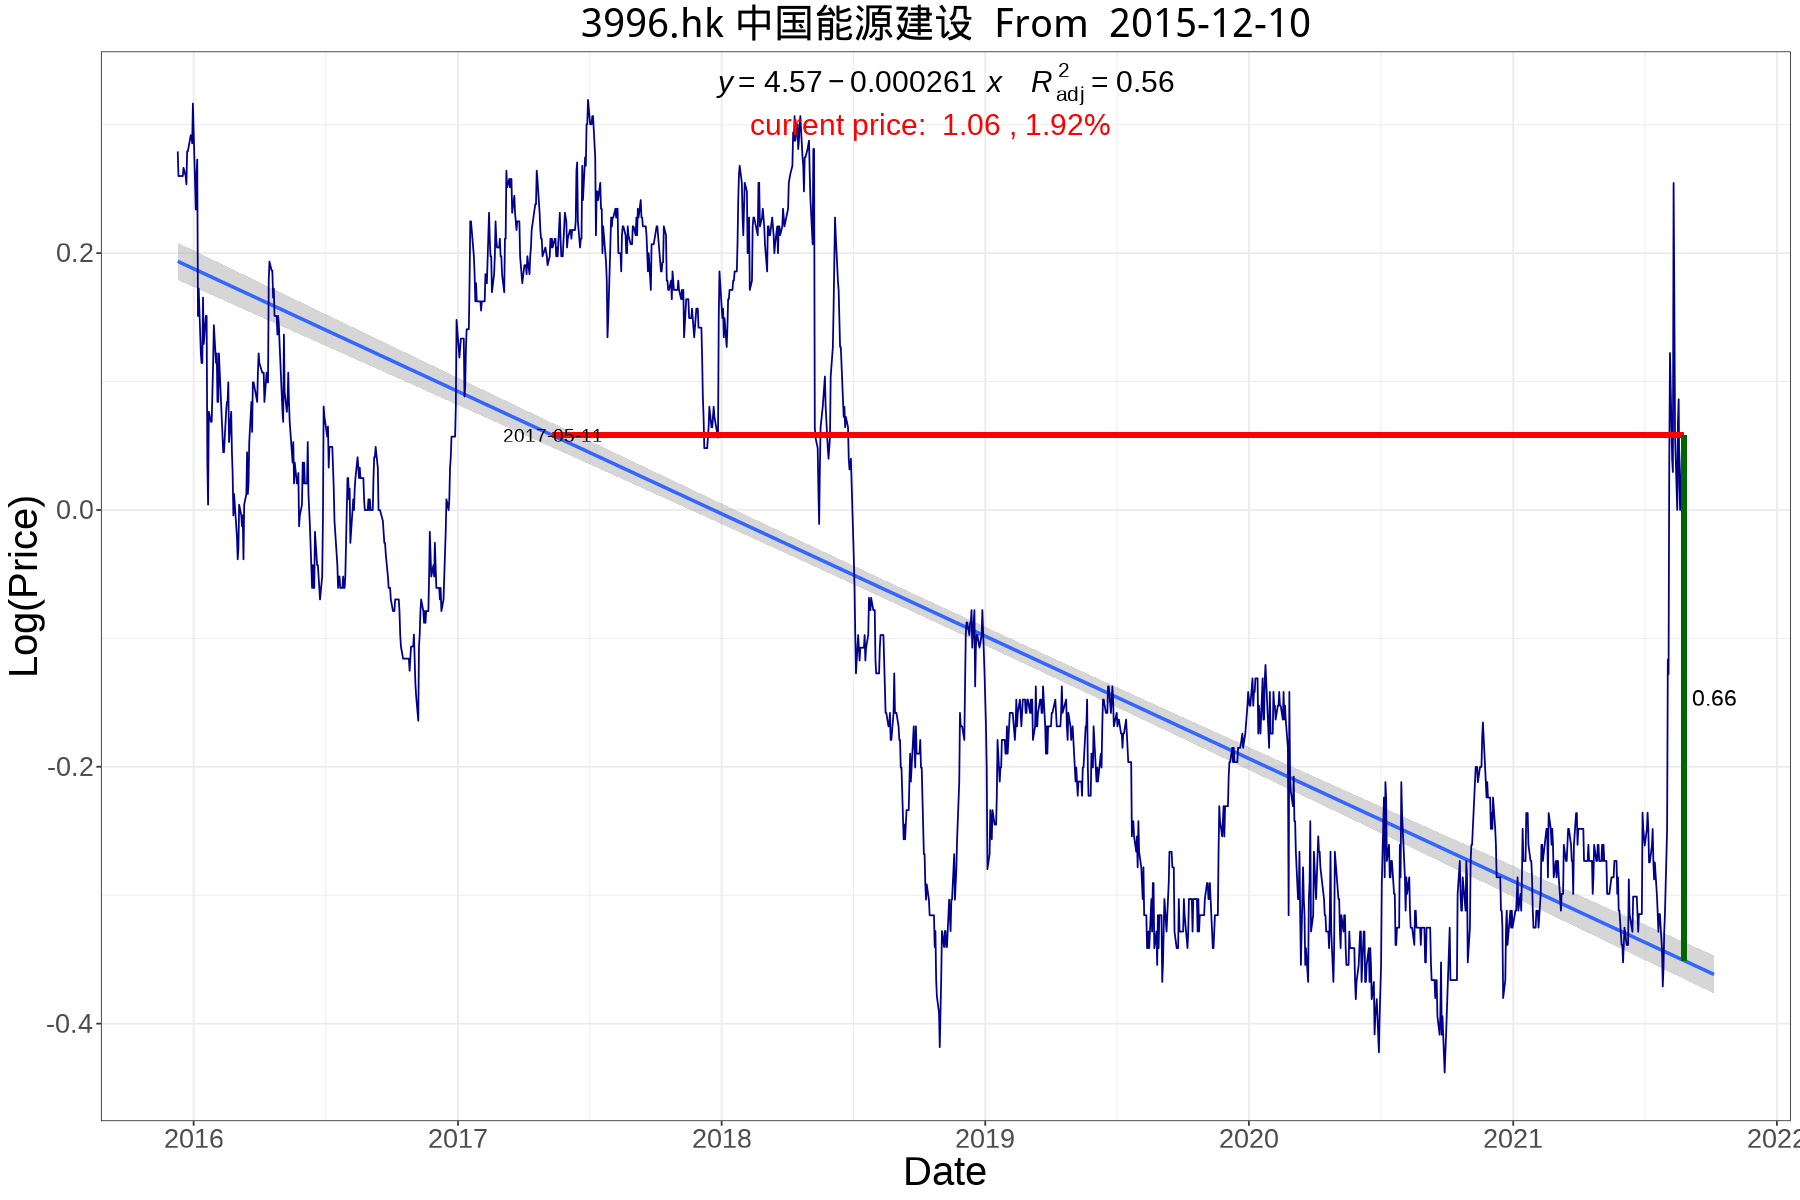

In [37]:
plot('中国能源建设','3996.hk',"Yes")

In [ ]:
plot('PG','PG','1956-01-31',Sys.Date(),'5 years')

In [ ]:
plot('高乐氏','CLX',"Yes")

In [ ]:
plot('MSFT','MSFT','1956-01-31',Sys.Date(),'5 years')

In [ ]:
plot('LMT','LMT','1956-01-31',Sys.Date(),'5 years')

In [ ]:
plot('ESLT','ESLT','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('MAXR','MAXR','1956-01-01',Sys.Date(),'1 years','2021-10-02')

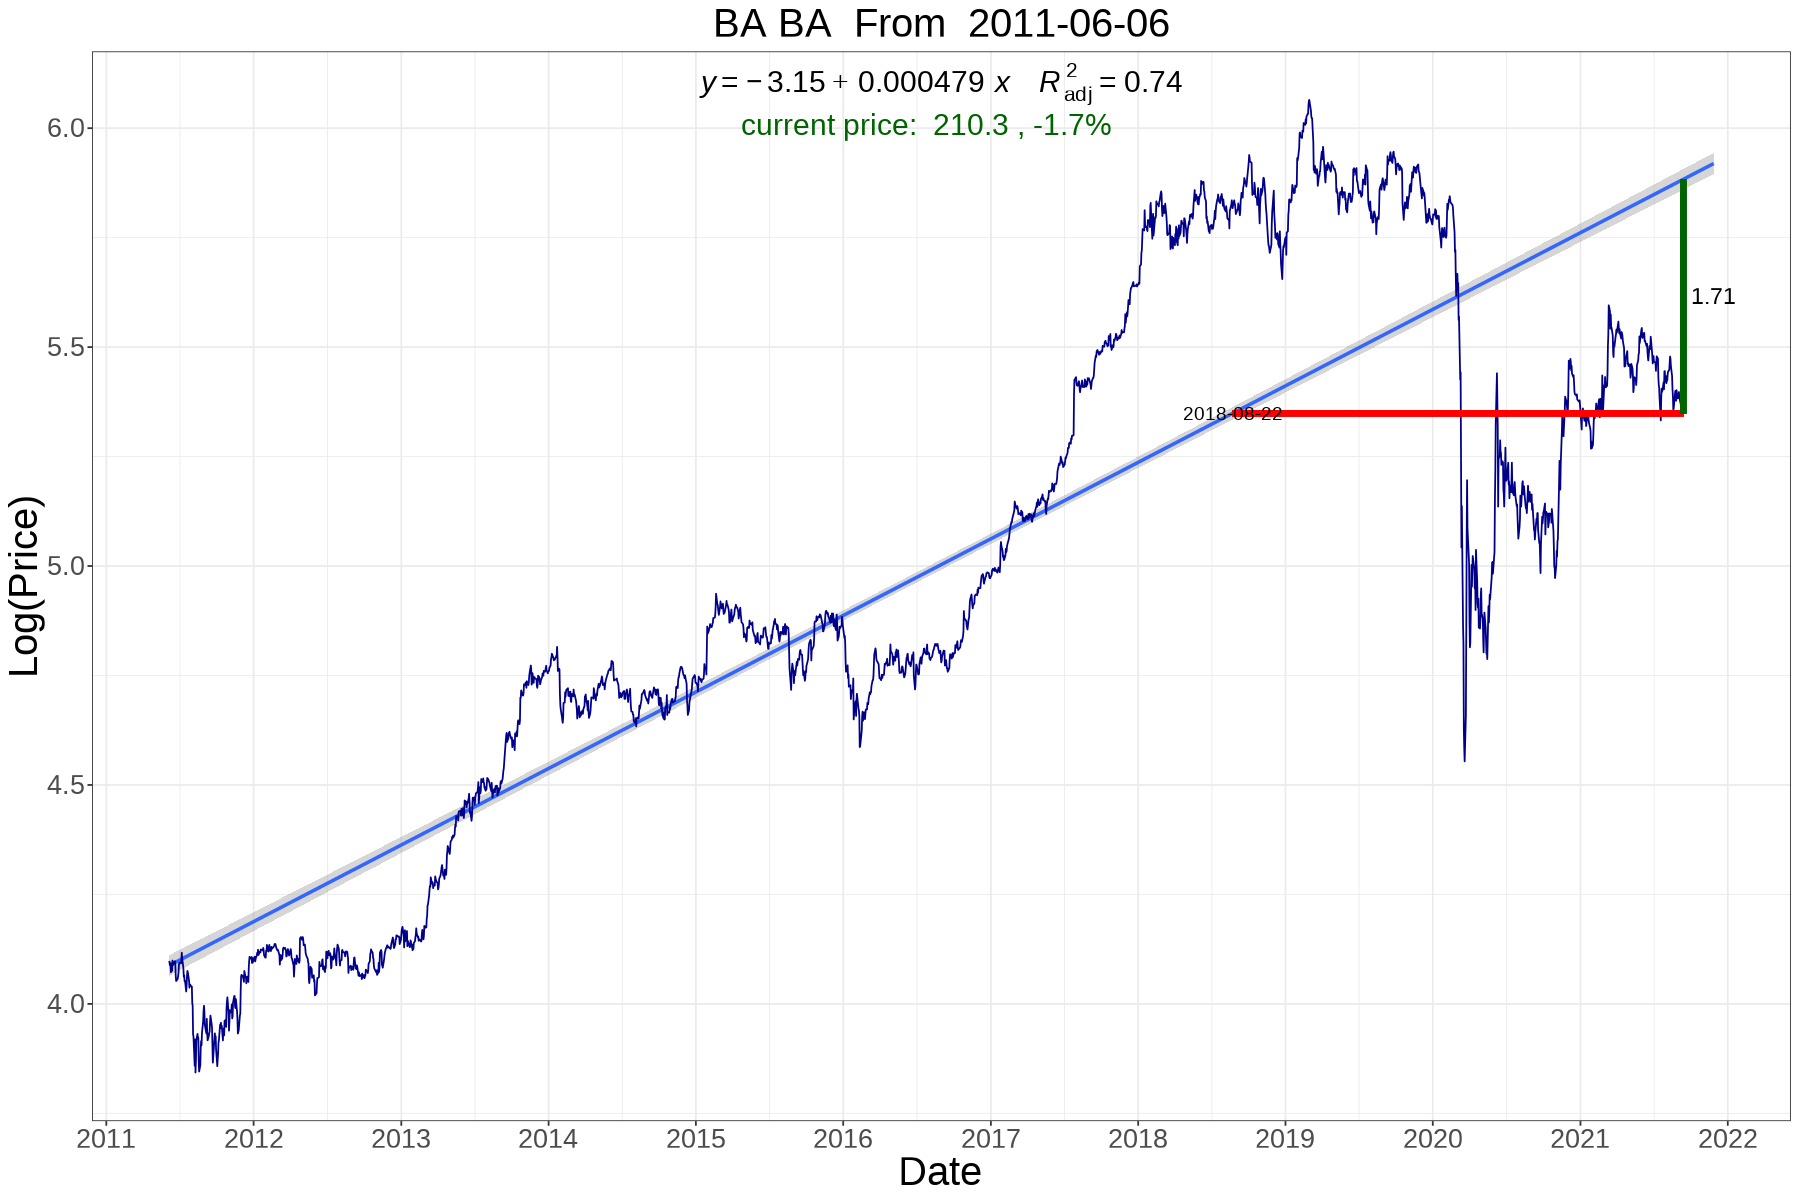

In [80]:
plot('BA','BA','Yes','2011-06-06')   ###比巴菲特的差，超过回归线就卖

In [ ]:
plot('TM','TM','1956-01-31',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('ORCL','ORCL','2004-01-04',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('INTC','INTC','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('ADBE','ADBE','2009-01-31',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('General Mills','GIS','1956-01-31',Sys.Date(),'5 years','2019-10-02')

In [ ]:
plot('VOO','VOO','1956-01-31',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('SPY','SPY','2004-01-30',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('VTV','VTV','1956-01-31',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('VTIP','VTIP','1956-01-31',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('QQQ','QQQ','2010-01-31',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('FINX','FINX','1956-01-31',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('PAVE','PAVE','1956-01-31',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('IFRA','IFRA','1956-01-31',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('XHB','XHB','2010-09-09',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('ITB','ITB','1956-09-09',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('VXUS','VXUS','1956-01-01',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('VT','VT','1956-01-01',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('VBR','VBR','1956-01-01',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('IJR','IJR','1956-01-01',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('IJS','IJS','1956-01-01',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('IJH','IJH','2007-04-03',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('CZA','CZA','1956-01-01',Sys.Date(),'2 years','2020-10-02')

In [ ]:
plot('ISRG','ISRG','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('SPG','SPG','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('FRT','FRT','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('Realty Income','O','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('VNQ','VNQ','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('TLT','TLT','1956-01-01',Sys.Date(),'2 years','2019-10-02')

In [ ]:
plot('ZROZ','ZROZ','1956-01-01',Sys.Date(),'1 years','2019-10-02')

In [ ]:
plot('SLV','SLV','1956-01-01',Sys.Date(),'1 years','2019-10-02')

In [ ]:
plot('SCHW','SCHW','1956-01-01',Sys.Date(),'5 years','2018-10-02')

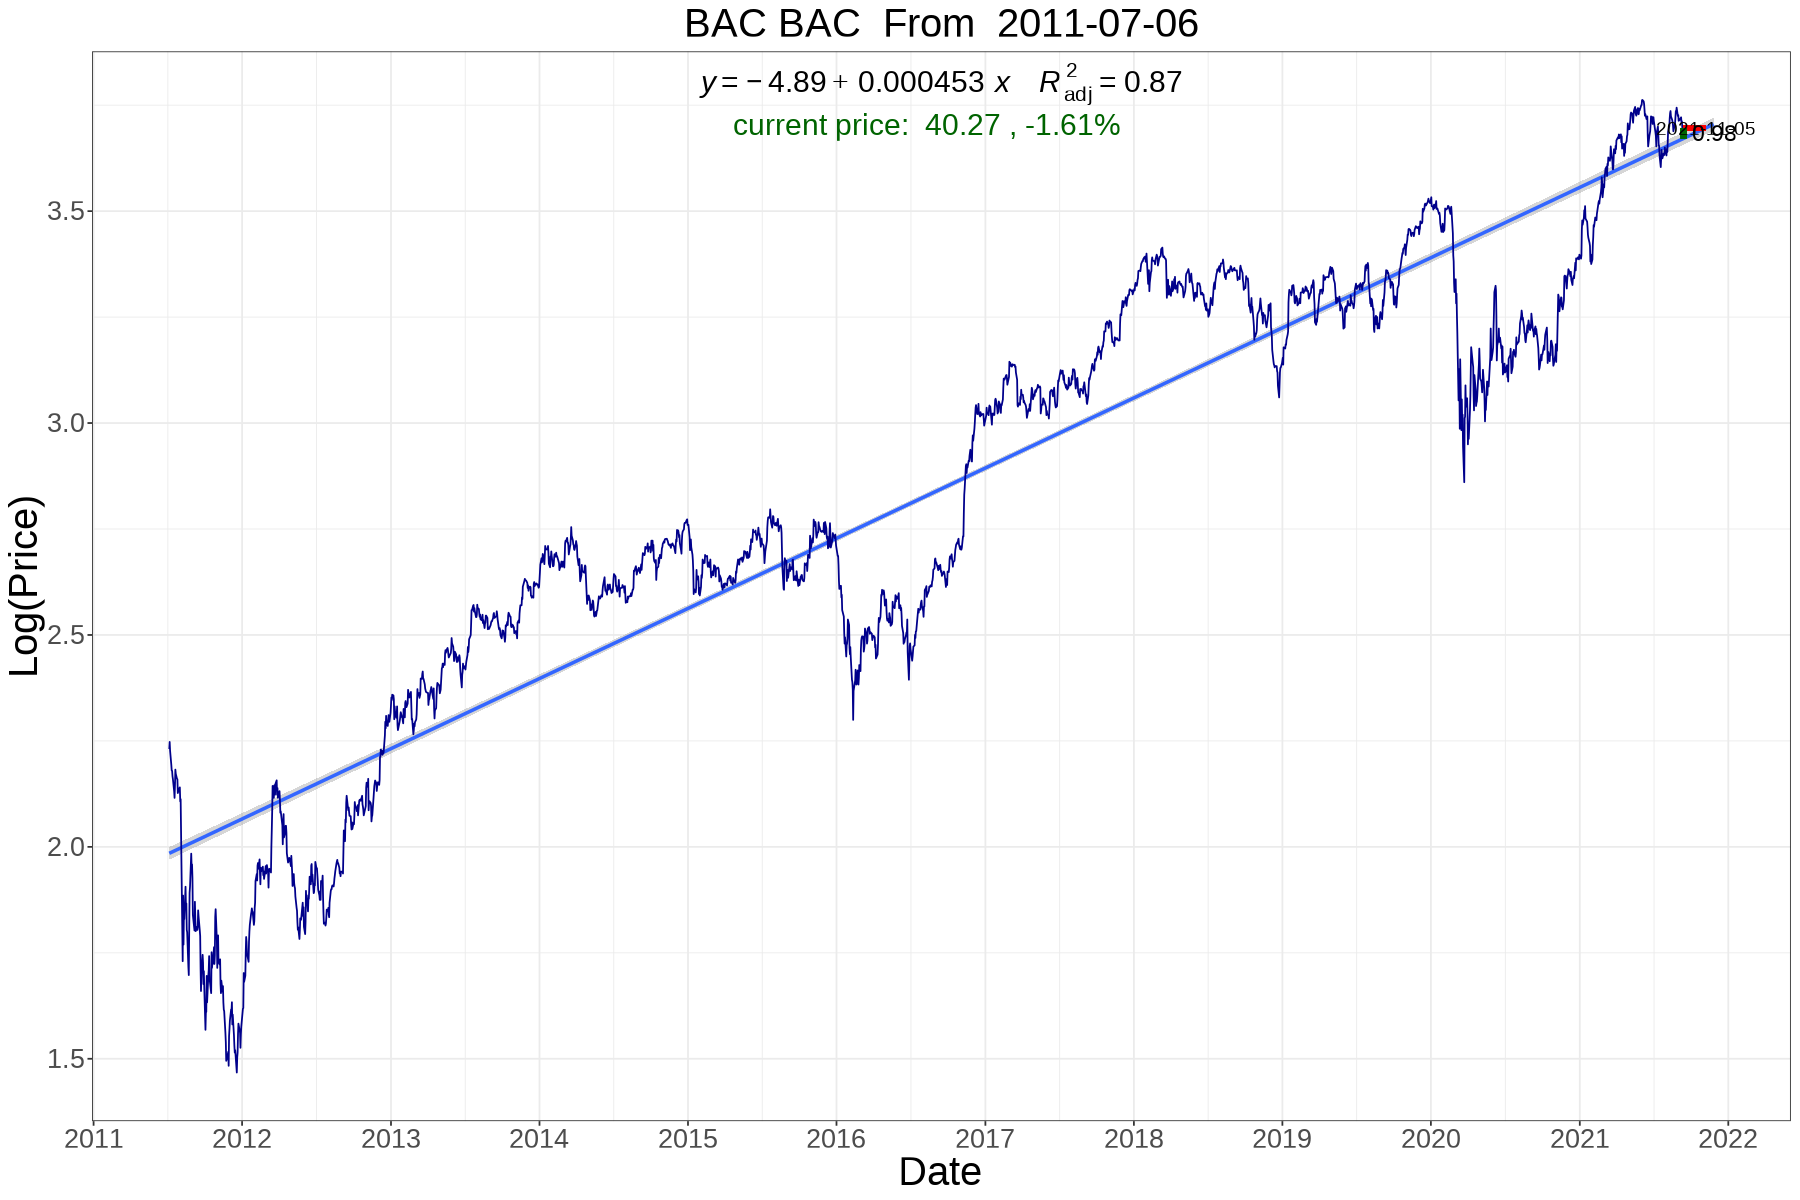

In [81]:
plot('BAC','BAC','Yes','2011-07-06') ###比巴菲特的差，超过回归线就卖

In [ ]:
plot('WU','WU','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('ASML','ASML','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('GS','GS','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('SPGI','SPGI','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('BMY','BMY','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('PFE','PFE','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('MRK','MRK','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('GILD','GILD','1956-01-01',Sys.Date(),'5 years','2020-10-02')

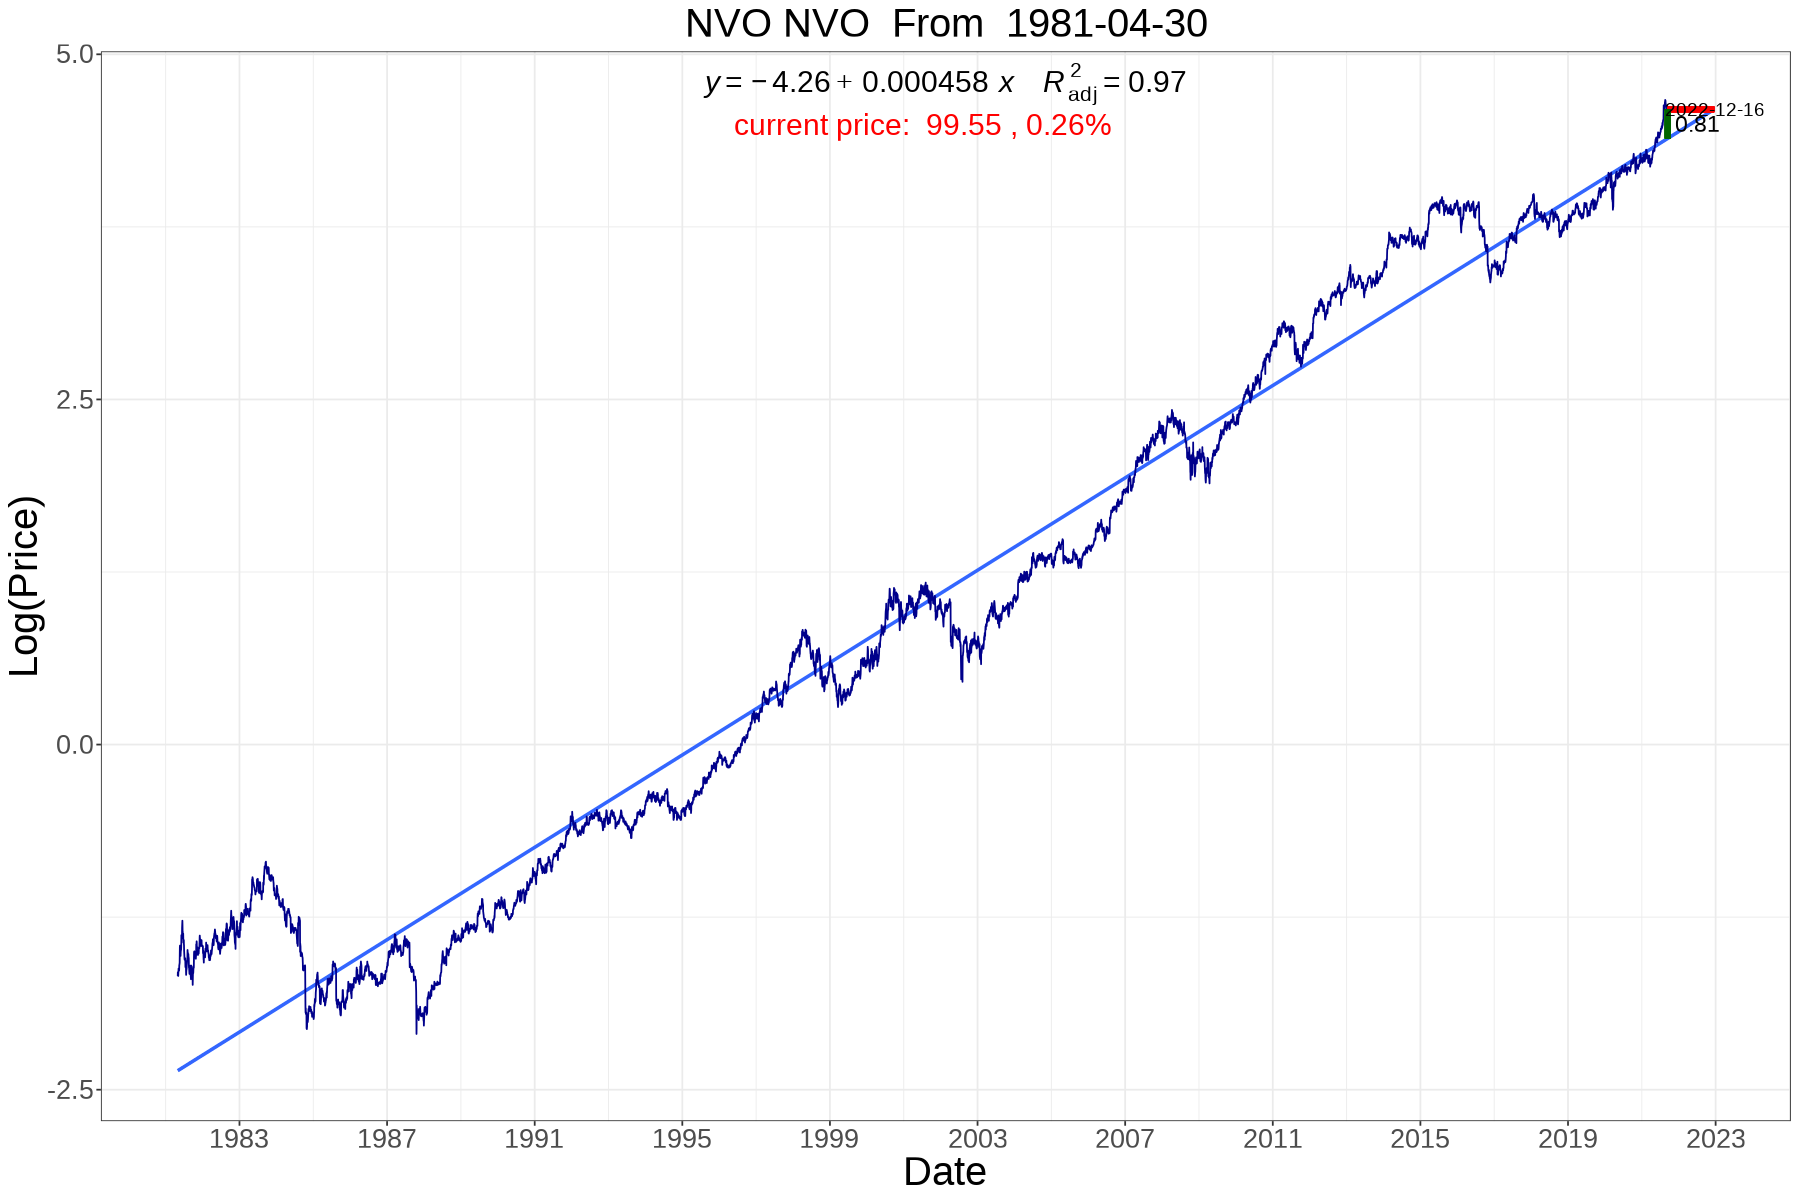

In [78]:
plot('NVO','NVO','Yes')

In [ ]:
plot('JNJ','JNJ','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('XBI','XBI','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('FBT','FBT','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('CRM','CRM','1956-01-01',Sys.Date(),'5 years','2020-10-02')

In [ ]:
plot('ARKF','ARKF','1956-01-01',Sys.Date(),'1 years','2021-10-02')

In [ ]:
plot('ARKG','ARKG','1956-01-01',Sys.Date(),'1 years','2021-10-02')

In [ ]:
plot('TSLA','TSLA','Yes')

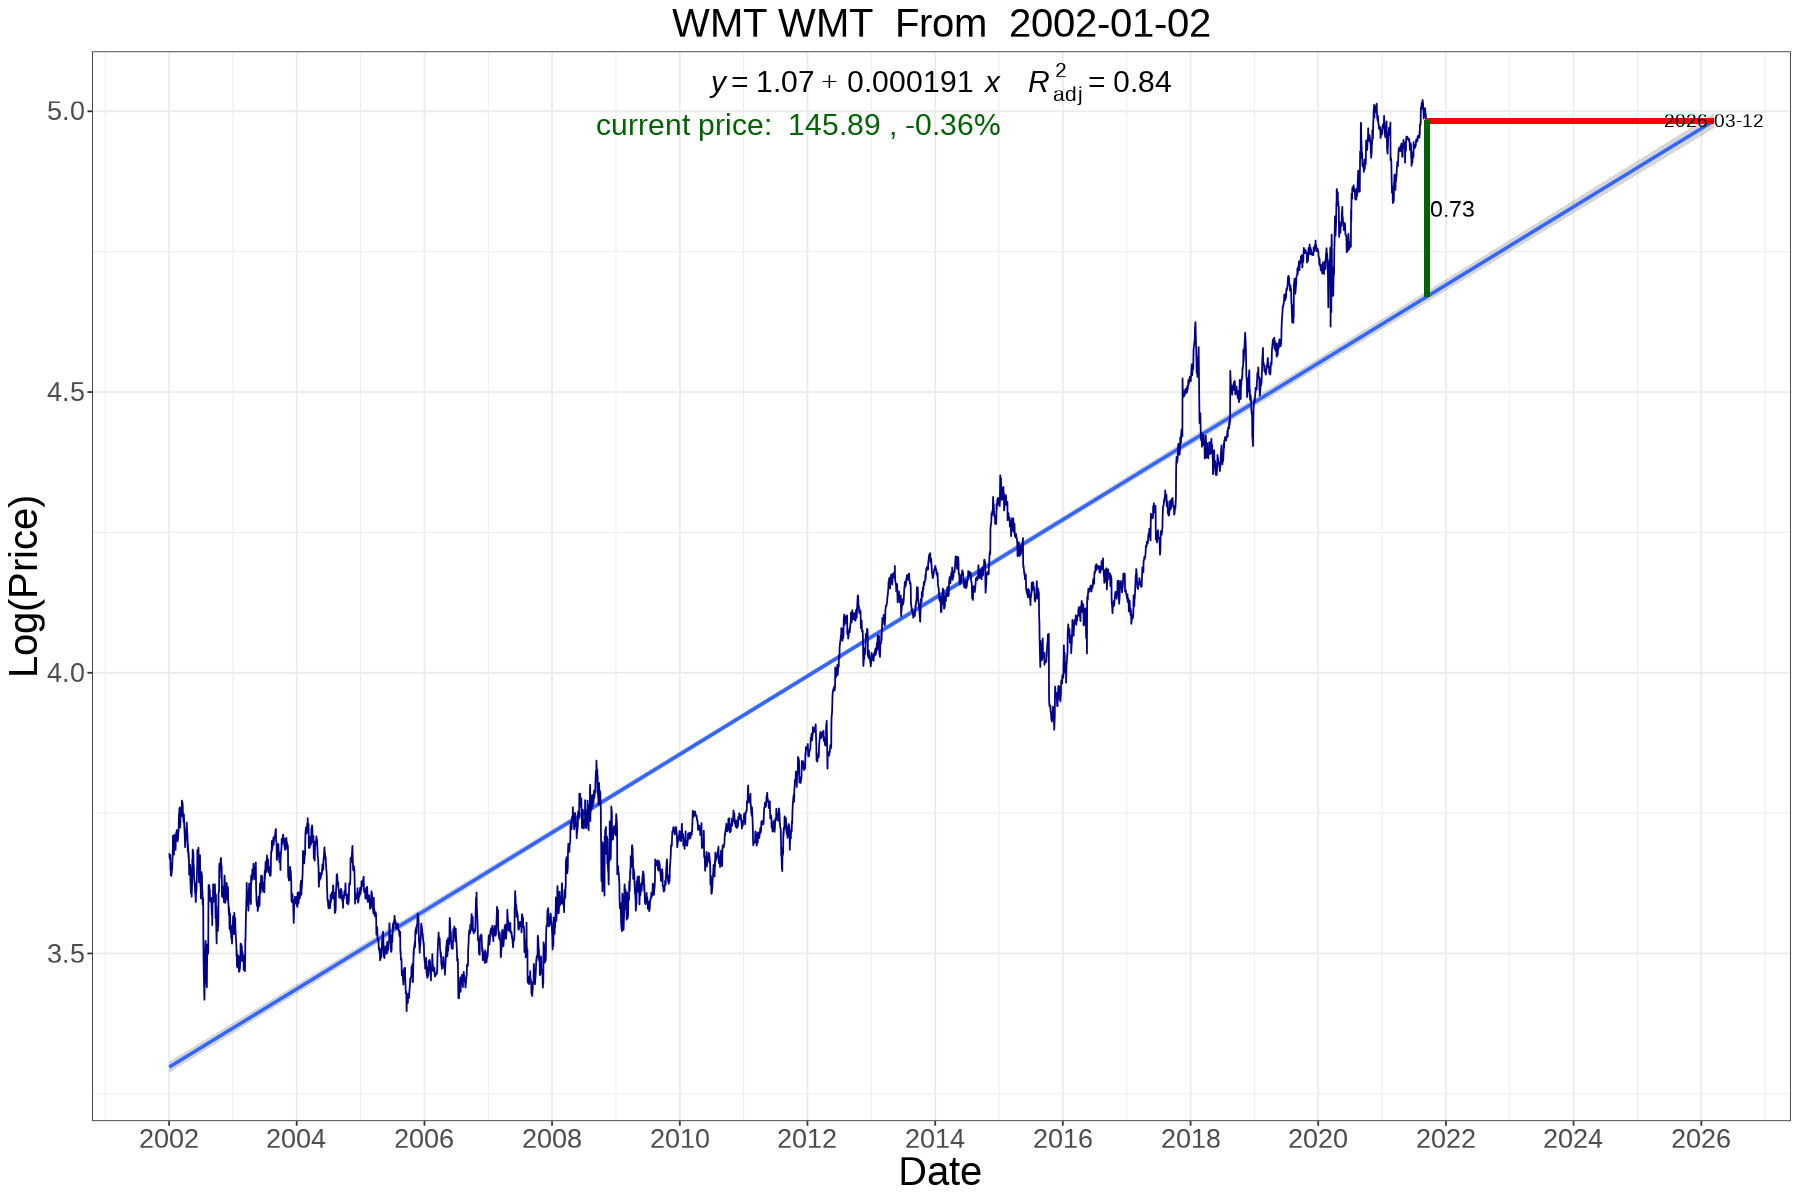

In [72]:
plot('WMT','WMT','Yes','2002-01-01')

In [ ]:
plot('BEAM','BEAM','1956-01-01',Sys.Date(),'3 months','2021-10-02')

In [ ]:
plot('BLUE','BLUE','1956-01-01',Sys.Date(),'1 years','2021-10-02')

In [ ]:
plot('CRSP','CRSP','1956-01-01',Sys.Date(),'1 years','2021-10-02')

In [ ]:
plot('NVTA','NVTA','1956-01-01',Sys.Date(),'1 years','2021-10-02')

In [ ]:
plot('NTLA','NTLA','1956-01-01',Sys.Date(),'1 years','2021-10-02')

In [ ]:
plot('EDIT','EDIT','1956-01-01',Sys.Date(),'1 years','2021-10-02')

In [ ]:
plot('PACB','PACB','1956-01-01',Sys.Date(),'1 years','2021-10-02')

In [ ]:
plot('TXG','TXG','1956-01-01',Sys.Date(),'1 years','2021-10-02')

In [ ]:
plot('ILMN','ILMN','1956-01-01',Sys.Date(),'3 years','2021-10-02')

In [ ]:
plot('BRK-A','BRK-A','1956-01-01',Sys.Date(),'3 years','2021-10-02')

In [ ]:
plot('SCO','SCO','1956-01-01',Sys.Date(),'3 years','2021-10-02')

In [ ]:
plot('UCO','UCO','1956-01-01',Sys.Date(),'3 years','2021-10-02')

In [ ]:
SCO  = getSymbols('SCO', src = "yahoo", from = '1956-01-01', to = Sys.Date(), auto.assign = FALSE)

In [ ]:
UCO  = getSymbols('UCO', src = "yahoo", from = '1956-01-01', to = Sys.Date(), auto.assign = FALSE)

In [ ]:
write.csv(UCO,'UCO.csv')
write.csv(SCO,'SCO.csv')

In [ ]:
UCO[56,]

In [ ]:
UCO[1494,]

In [ ]:
SPXU  = getSymbols('SPXU', src = "yahoo", from = '1956-01-01', to = Sys.Date(), auto.assign = FALSE)
write.csv(SPXU,'SPXU.csv')

In [ ]:
SQQQ  = getSymbols('SQQQ', src = "yahoo", from = '1956-01-01', to = Sys.Date(), auto.assign = FALSE)
write.csv(SQQQ,'SQQQ.csv')

In [ ]:
UVXY  = getSymbols('UVXY', src = "yahoo", from = '1956-01-01', to = Sys.Date(), auto.assign = FALSE)
write.csv(UVXY,'UVXY.csv')

In [ ]:
VIXY  = getSymbols('VIXY', src = "yahoo", from = '1956-01-01', to = Sys.Date(), auto.assign = FALSE)
write.csv(VIXY,'VIXY.csv')

In [ ]:
USO  = getSymbols('USO', src = "yahoo", from = '1956-01-01', to = Sys.Date(), auto.assign = FALSE)
write.csv(USO,'USO.csv')

In [ ]:
PSQ  = getSymbols('PSQ', src = "yahoo", from = '1956-01-01', to = Sys.Date(), auto.assign = FALSE)
write.csv(PSQ,'PSQ.csv')

In [ ]:
TMV  = getSymbols('TMV', src = "yahoo", from = '1956-01-01', to = Sys.Date(), auto.assign = FALSE)
write.csv(TMV,'TMV.csv')

In [ ]:
JDST  = getSymbols('JDST', src = "yahoo", from = '1956-01-01', to = Sys.Date(), auto.assign = FALSE)
write.csv(JDST,'JDST.csv')

In [ ]:
DUST  = getSymbols('DUST', src = "yahoo", from = '1956-01-01', to = Sys.Date(), auto.assign = FALSE)
write.csv(DUST,'DUST.csv')